In [162]:
# Inspired by - https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34 

In [207]:
#Here we assume that the model is in the same Directory as this notebook
#Change the value of this variable to test the desired model (classical model is used by default)
model_name = 'classical_model.h5'

In [164]:
#Use a trained model to predict Breast Cancer
#Make sure that the parent folder of Initial Model is within the same directory as the Data Folder with all the images
"""
Example:
+ Data
+ DashApp
  |--- Model
        |--- model_prediction.ipynb
"""
#Comment this to use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #Remove this line if you have a GPU device

In [165]:
import os
#Global variables
DATA_PATH = os.path.join("..","..","Data")
RANDOM_SEED = 42
TEST_FRACTION = 0.2 # Just for initial test it must be something like 0.2
VALIDATION_FRACTION = 0.2 # Use the 20% of the non test samples to build the validation set (the remaining is the Test Set)
# Input patches are 50X50
IMAGE_WIDTH = 50 
IMAGE_LENGTH = 50

In [166]:
import numpy as np
np.random.seed(RANDOM_SEED)
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)
import pandas as pd
from sklearn.model_selection import train_test_split
import glob

In [167]:
# read all patches
patches = []
for path in glob.glob(os.path.join(DATA_PATH,'**/*class*.png'), recursive = True):
    patches.append(path)

In [168]:
def createDataFrame():
    # Keep info within a Pandas dataframe
    data = pd.DataFrame({"path" : patches})
    # Obtain patient information by spliting the filename
    series_info = data["path"].str.split("idx").str[1].str.split("_")
    data['id'] = series_info.str[0] # this get the idx portion
    data['x'] = series_info.str[1].str[1:] # this get the x coord
    data['y'] = series_info.str[2].str[1:] # this get the y coord
    data['class'] = series_info.str[3] # this get the class
    data['class'] = data["class"].map({"class0.png" : "0" , "class1.png" : "1"}) #map to a number
    # Get the total number of registers from the class with the least number of samples 
    number_samples = min(data['class'].value_counts())    
    
    balanced_data = data[data['class'] == '0'].sample(n=number_samples, random_state=RANDOM_SEED, ignore_index=True)
    balanced_data = pd.concat([balanced_data, data[data['class'] == '1'].sample(n=number_samples, random_state=RANDOM_SEED, ignore_index=True)], ignore_index=True)
    
    balanced_data = balanced_data.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    # sample the dataframe in such way that the data per class is balanced (same number of samples)
    return balanced_data
df = createDataFrame()
df.head()

,path,id,x,y,class
0,..\..\Data\12748\0\12748_idx5_x401_y651_class0...,5,401,651,0
1,..\..\Data\12751\1\12751_idx5_x2351_y1401_clas...,5,2351,1401,1
2,..\..\Data\13694\1\13694_idx5_x1301_y1651_clas...,5,1301,1651,1
3,..\..\Data\10272\0\10272_idx5_x2501_y1151_clas...,5,2501,1151,0
4,..\..\Data\12949\1\12949_idx5_x1251_y1651_clas...,5,1251,1651,1


In [169]:
# Split data into train and test sets
train_val, test = train_test_split(df, test_size=TEST_FRACTION, random_state=RANDOM_SEED, stratify=df['class'])
# Split train_val into train and validation
train, validation = train_test_split(train_val, test_size=VALIDATION_FRACTION, random_state=RANDOM_SEED, stratify=train_val['class'])


In [170]:
print("Train samples: ", len(train), "class 0:", len(train[train['class'] == '0']), "class 1:", len(train[train['class'] == '1']))
print("Validation samples: ", len(validation), "class 0:", len(validation[validation['class'] == '0']), "class 1:", len(validation[validation['class'] == '1']))
print("Test samples: ", len(test), "class 0:", len(test[test['class'] == '0']), "class 1:", len(test[test['class'] == '1']))

Train samples:  100845 class 0: 50422 class 1: 50423
Validation samples:  25212 class 0: 12606 class 1: 12606
Test samples:  31515 class 0: 15758 class 1: 15757


## Clustering Stage

In [252]:
# 1. The pretained model we will use for feature extraction
start_model = tf.keras.models.load_model('classical_model.h5')
start_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [249]:
# clustering and dimension reduction
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [257]:
# remove the output layer
model = Model(inputs=start_model.inputs, outputs=start_model.layers[-3].output)
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         738

In [258]:
#convert image to a numpy array with the proper dims and preprocess
def preprocess_image(image_array): #TODO: It is important to use the same preprocessing as during TRAIINING
    return image_array/255.0

def get_img(path, size=None):
    return tf.keras.utils.load_img(path, target_size=None)

def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = preprocess_image(array)

    array = np.expand_dims(array, axis=0)
    return array

def get_array_from_img(img):
    array = tf.keras.utils.img_to_array(img) / 255.0
    array = np.expand_dims(array, axis=0)
    return array



In [259]:
image = get_img_array(test["path"].iloc[0], (50,50))
features = model.predict(image)
print(features.shape)

1/1 [==============================] - 0s 46ms/step
(1, 2048)


In [302]:
# We create a function to extract the image features
def extract_features(path, model):
    img = get_img_array(path, (50,50))
    features = model.predict(img, use_multiprocessing=True)
    return features

In [303]:
data = {}
p = r"clustering_features.pkl"
NUM = 31515

# loop through each image - testing initially with 1000 images
counter = 0
for path in test['path'].iloc[:NUM]:
    print(counter)
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(path,model)
        data[path] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
    counter += 1
            
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

0
1/1 [==============================] - 0s 14ms/step
1
1/1 [==============================] - 0s 13ms/step
2
1/1 [==============================] - 0s 13ms/step
3
1/1 [==============================] - 0s 12ms/step
4
1/1 [==============================] - 0s 12ms/step
5
1/1 [==============================] - 0s 12ms/step
6
1/1 [==============================] - 0s 12ms/step
7
1/1 [==============================] - 0s 13ms/step
8
1/1 [==============================] - 0s 14ms/step
9
1/1 [==============================] - 0s 13ms/step
10
1/1 [==============================] - 0s 13ms/step
11
1/1 [==============================] - 0s 12ms/step
12
1/1 [==============================] - 0s 13ms/step
13
1/1 [==============================] - 0s 11ms/step
14
1/1 [==============================] - 0s 12ms/step
15
1/1 [==============================] - 0s 13ms/step
16
1/1 [==============================] - 0s 13ms/step
17
1/1 [==============================] - 0s 12ms/step
18
1/1 [============

1/1 [==============================] - 0s 15ms/step
149
1/1 [==============================] - 0s 14ms/step
150
1/1 [==============================] - 0s 13ms/step
151
1/1 [==============================] - 0s 14ms/step
152
1/1 [==============================] - 0s 15ms/step
153
1/1 [==============================] - 0s 14ms/step
154
1/1 [==============================] - 0s 13ms/step
155
1/1 [==============================] - 0s 14ms/step
156
1/1 [==============================] - 0s 14ms/step
157
1/1 [==============================] - 0s 13ms/step
158
1/1 [==============================] - 0s 14ms/step
159
1/1 [==============================] - 0s 13ms/step
160
1/1 [==============================] - 0s 14ms/step
161
1/1 [==============================] - 0s 15ms/step
162
1/1 [==============================] - 0s 14ms/step
163
1/1 [==============================] - 0s 14ms/step
164
1/1 [==============================] - 0s 14ms/step
165
1/1 [==============================] - 0s 13ms/s

1/1 [==============================] - 0s 18ms/step
295
1/1 [==============================] - 0s 14ms/step
296
1/1 [==============================] - 0s 13ms/step
297
1/1 [==============================] - 0s 14ms/step
298
1/1 [==============================] - 0s 14ms/step
299
1/1 [==============================] - 0s 14ms/step
300
1/1 [==============================] - 0s 14ms/step
301
1/1 [==============================] - 0s 13ms/step
302
1/1 [==============================] - 0s 14ms/step
303
1/1 [==============================] - 0s 13ms/step
304
1/1 [==============================] - 0s 13ms/step
305
1/1 [==============================] - 0s 12ms/step
306
1/1 [==============================] - 0s 14ms/step
307
1/1 [==============================] - 0s 14ms/step
308
1/1 [==============================] - 0s 25ms/step
309
1/1 [==============================] - 0s 13ms/step
310
1/1 [==============================] - 0s 13ms/step
311
1/1 [==============================] - 0s 13ms/s

1/1 [==============================] - 0s 14ms/step
441
1/1 [==============================] - 0s 13ms/step
442
1/1 [==============================] - 0s 14ms/step
443
1/1 [==============================] - 0s 14ms/step
444
1/1 [==============================] - 0s 14ms/step
445
1/1 [==============================] - 0s 14ms/step
446
1/1 [==============================] - 0s 14ms/step
447
1/1 [==============================] - 0s 14ms/step
448
1/1 [==============================] - 0s 14ms/step
449
1/1 [==============================] - 0s 14ms/step
450
1/1 [==============================] - 0s 14ms/step
451
1/1 [==============================] - 0s 13ms/step
452
1/1 [==============================] - 0s 13ms/step
453
1/1 [==============================] - 0s 15ms/step
454
1/1 [==============================] - 0s 14ms/step
455
1/1 [==============================] - 0s 14ms/step
456
1/1 [==============================] - 0s 15ms/step
457
1/1 [==============================] - 0s 14ms/s

1/1 [==============================] - 0s 13ms/step
587
1/1 [==============================] - 0s 14ms/step
588
1/1 [==============================] - 0s 13ms/step
589
1/1 [==============================] - 0s 12ms/step
590
1/1 [==============================] - 0s 12ms/step
591
1/1 [==============================] - 0s 13ms/step
592
1/1 [==============================] - 0s 12ms/step
593
1/1 [==============================] - 0s 12ms/step
594
1/1 [==============================] - 0s 12ms/step
595
1/1 [==============================] - 0s 14ms/step
596
1/1 [==============================] - 0s 12ms/step
597
1/1 [==============================] - 0s 13ms/step
598
1/1 [==============================] - 0s 13ms/step
599
1/1 [==============================] - 0s 14ms/step
600
1/1 [==============================] - 0s 13ms/step
601
1/1 [==============================] - 0s 13ms/step
602
1/1 [==============================] - 0s 13ms/step
603
1/1 [==============================] - 0s 13ms/s

1/1 [==============================] - 0s 14ms/step
733
1/1 [==============================] - 0s 13ms/step
734
1/1 [==============================] - 0s 12ms/step
735
1/1 [==============================] - 0s 13ms/step
736
1/1 [==============================] - 0s 21ms/step
737
1/1 [==============================] - 0s 24ms/step
738
1/1 [==============================] - 0s 21ms/step
739
1/1 [==============================] - 0s 12ms/step
740
1/1 [==============================] - 0s 13ms/step
741
1/1 [==============================] - 0s 13ms/step
742
1/1 [==============================] - 0s 12ms/step
743
1/1 [==============================] - 0s 12ms/step
744
1/1 [==============================] - 0s 13ms/step
745
1/1 [==============================] - 0s 12ms/step
746
1/1 [==============================] - 0s 12ms/step
747
1/1 [==============================] - 0s 12ms/step
748
1/1 [==============================] - 0s 13ms/step
749
1/1 [==============================] - 0s 12ms/s

1/1 [==============================] - 0s 14ms/step
879
1/1 [==============================] - 0s 19ms/step
880
1/1 [==============================] - 0s 19ms/step
881
1/1 [==============================] - 0s 14ms/step
882
1/1 [==============================] - 0s 12ms/step
883
1/1 [==============================] - 0s 14ms/step
884
1/1 [==============================] - 0s 15ms/step
885
1/1 [==============================] - 0s 13ms/step
886
1/1 [==============================] - 0s 14ms/step
887
1/1 [==============================] - 0s 14ms/step
888
1/1 [==============================] - 0s 13ms/step
889
1/1 [==============================] - 0s 14ms/step
890
1/1 [==============================] - 0s 15ms/step
891
1/1 [==============================] - 0s 16ms/step
892
1/1 [==============================] - 0s 16ms/step
893
1/1 [==============================] - 0s 16ms/step
894
1/1 [==============================] - 0s 13ms/step
895
1/1 [==============================] - 0s 13ms/s

1024
1/1 [==============================] - 0s 15ms/step
1025
1/1 [==============================] - 0s 14ms/step
1026
1/1 [==============================] - 0s 12ms/step
1027
1/1 [==============================] - 0s 13ms/step
1028
1/1 [==============================] - 0s 13ms/step
1029
1/1 [==============================] - 0s 14ms/step
1030
1/1 [==============================] - 0s 12ms/step
1031
1/1 [==============================] - 0s 20ms/step
1032
1/1 [==============================] - 0s 14ms/step
1033
1/1 [==============================] - 0s 13ms/step
1034
1/1 [==============================] - 0s 13ms/step
1035
1/1 [==============================] - 0s 12ms/step
1036
1/1 [==============================] - 0s 14ms/step
1037
1/1 [==============================] - 0s 14ms/step
1038
1/1 [==============================] - 0s 13ms/step
1039
1/1 [==============================] - 0s 14ms/step
1040
1/1 [==============================] - 0s 13ms/step
1041
1/1 [=====================

1/1 [==============================] - 0s 13ms/step
1168
1/1 [==============================] - 0s 13ms/step
1169
1/1 [==============================] - 0s 12ms/step
1170
1/1 [==============================] - 0s 13ms/step
1171
1/1 [==============================] - 0s 13ms/step
1172
1/1 [==============================] - 0s 13ms/step
1173
1/1 [==============================] - 0s 14ms/step
1174
1/1 [==============================] - 0s 12ms/step
1175
1/1 [==============================] - 0s 13ms/step
1176
1/1 [==============================] - 0s 13ms/step
1177
1/1 [==============================] - 0s 12ms/step
1178
1/1 [==============================] - 0s 13ms/step
1179
1/1 [==============================] - 0s 12ms/step
1180
1/1 [==============================] - 0s 13ms/step
1181
1/1 [==============================] - 0s 12ms/step
1182
1/1 [==============================] - 0s 13ms/step
1183
1/1 [==============================] - 0s 13ms/step
1184
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
1311
1/1 [==============================] - 0s 15ms/step
1312
1/1 [==============================] - 0s 13ms/step
1313
1/1 [==============================] - 0s 14ms/step
1314
1/1 [==============================] - 0s 13ms/step
1315
1/1 [==============================] - 0s 13ms/step
1316
1/1 [==============================] - 0s 15ms/step
1317
1/1 [==============================] - 0s 14ms/step
1318
1/1 [==============================] - 0s 14ms/step
1319
1/1 [==============================] - 0s 14ms/step
1320
1/1 [==============================] - 0s 13ms/step
1321
1/1 [==============================] - 0s 13ms/step
1322
1/1 [==============================] - 0s 13ms/step
1323
1/1 [==============================] - 0s 12ms/step
1324
1/1 [==============================] - 0s 13ms/step
1325
1/1 [==============================] - 0s 14ms/step
1326
1/1 [==============================] - 0s 12ms/step
1327
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
1454
1/1 [==============================] - 0s 14ms/step
1455
1/1 [==============================] - 0s 13ms/step
1456
1/1 [==============================] - 0s 13ms/step
1457
1/1 [==============================] - 0s 13ms/step
1458
1/1 [==============================] - 0s 13ms/step
1459
1/1 [==============================] - 0s 13ms/step
1460
1/1 [==============================] - 0s 13ms/step
1461
1/1 [==============================] - 0s 13ms/step
1462
1/1 [==============================] - 0s 13ms/step
1463
1/1 [==============================] - 0s 14ms/step
1464
1/1 [==============================] - 0s 13ms/step
1465
1/1 [==============================] - 0s 13ms/step
1466
1/1 [==============================] - 0s 13ms/step
1467
1/1 [==============================] - 0s 12ms/step
1468
1/1 [==============================] - 0s 13ms/step
1469
1/1 [==============================] - 0s 12ms/step
1470
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
1597
1/1 [==============================] - 0s 13ms/step
1598
1/1 [==============================] - 0s 15ms/step
1599
1/1 [==============================] - 0s 13ms/step
1600
1/1 [==============================] - 0s 13ms/step
1601
1/1 [==============================] - 0s 12ms/step
1602
1/1 [==============================] - 0s 13ms/step
1603
1/1 [==============================] - 0s 13ms/step
1604
1/1 [==============================] - 0s 12ms/step
1605
1/1 [==============================] - 0s 12ms/step
1606
1/1 [==============================] - 0s 13ms/step
1607
1/1 [==============================] - 0s 12ms/step
1608
1/1 [==============================] - 0s 12ms/step
1609
1/1 [==============================] - 0s 12ms/step
1610
1/1 [==============================] - 0s 13ms/step
1611
1/1 [==============================] - 0s 13ms/step
1612
1/1 [==============================] - 0s 13ms/step
1613
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
1740
1/1 [==============================] - 0s 12ms/step
1741
1/1 [==============================] - 0s 12ms/step
1742
1/1 [==============================] - 0s 13ms/step
1743
1/1 [==============================] - 0s 14ms/step
1744
1/1 [==============================] - 0s 12ms/step
1745
1/1 [==============================] - 0s 13ms/step
1746
1/1 [==============================] - 0s 13ms/step
1747
1/1 [==============================] - 0s 13ms/step
1748
1/1 [==============================] - 0s 13ms/step
1749
1/1 [==============================] - 0s 13ms/step
1750
1/1 [==============================] - 0s 13ms/step
1751
1/1 [==============================] - 0s 13ms/step
1752
1/1 [==============================] - 0s 12ms/step
1753
1/1 [==============================] - 0s 13ms/step
1754
1/1 [==============================] - 0s 13ms/step
1755
1/1 [==============================] - 0s 13ms/step
1756
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
1883
1/1 [==============================] - 0s 12ms/step
1884
1/1 [==============================] - 0s 15ms/step
1885
1/1 [==============================] - 0s 13ms/step
1886
1/1 [==============================] - 0s 13ms/step
1887
1/1 [==============================] - 0s 14ms/step
1888
1/1 [==============================] - 0s 12ms/step
1889
1/1 [==============================] - 0s 13ms/step
1890
1/1 [==============================] - 0s 14ms/step
1891
1/1 [==============================] - 0s 13ms/step
1892
1/1 [==============================] - 0s 12ms/step
1893
1/1 [==============================] - 0s 14ms/step
1894
1/1 [==============================] - 0s 13ms/step
1895
1/1 [==============================] - 0s 12ms/step
1896
1/1 [==============================] - 0s 13ms/step
1897
1/1 [==============================] - 0s 13ms/step
1898
1/1 [==============================] - 0s 12ms/step
1899
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2026
1/1 [==============================] - 0s 15ms/step
2027
1/1 [==============================] - 0s 15ms/step
2028
1/1 [==============================] - 0s 15ms/step
2029
1/1 [==============================] - 0s 16ms/step
2030
1/1 [==============================] - 0s 13ms/step
2031
1/1 [==============================] - 0s 12ms/step
2032
1/1 [==============================] - 0s 12ms/step
2033
1/1 [==============================] - 0s 13ms/step
2034
1/1 [==============================] - 0s 12ms/step
2035
1/1 [==============================] - 0s 13ms/step
2036
1/1 [==============================] - 0s 14ms/step
2037
1/1 [==============================] - 0s 12ms/step
2038
1/1 [==============================] - 0s 13ms/step
2039
1/1 [==============================] - 0s 13ms/step
2040
1/1 [==============================] - 0s 12ms/step
2041
1/1 [==============================] - 0s 12ms/step
2042
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
2169
1/1 [==============================] - 0s 13ms/step
2170
1/1 [==============================] - 0s 12ms/step
2171
1/1 [==============================] - 0s 12ms/step
2172
1/1 [==============================] - 0s 13ms/step
2173
1/1 [==============================] - 0s 13ms/step
2174
1/1 [==============================] - 0s 13ms/step
2175
1/1 [==============================] - 0s 13ms/step
2176
1/1 [==============================] - 0s 12ms/step
2177
1/1 [==============================] - 0s 12ms/step
2178
1/1 [==============================] - 0s 14ms/step
2179
1/1 [==============================] - 0s 13ms/step
2180
1/1 [==============================] - 0s 13ms/step
2181
1/1 [==============================] - 0s 12ms/step
2182
1/1 [==============================] - 0s 13ms/step
2183
1/1 [==============================] - 0s 13ms/step
2184
1/1 [==============================] - 0s 13ms/step
2185
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
2312
1/1 [==============================] - 0s 13ms/step
2313
1/1 [==============================] - 0s 13ms/step
2314
1/1 [==============================] - 0s 13ms/step
2315
1/1 [==============================] - 0s 13ms/step
2316
1/1 [==============================] - 0s 12ms/step
2317
1/1 [==============================] - 0s 12ms/step
2318
1/1 [==============================] - 0s 12ms/step
2319
1/1 [==============================] - 0s 12ms/step
2320
1/1 [==============================] - 0s 13ms/step
2321
1/1 [==============================] - 0s 13ms/step
2322
1/1 [==============================] - 0s 14ms/step
2323
1/1 [==============================] - 0s 14ms/step
2324
1/1 [==============================] - 0s 14ms/step
2325
1/1 [==============================] - 0s 13ms/step
2326
1/1 [==============================] - 0s 12ms/step
2327
1/1 [==============================] - 0s 14ms/step
2328
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2455
1/1 [==============================] - 0s 13ms/step
2456
1/1 [==============================] - 0s 13ms/step
2457
1/1 [==============================] - 0s 14ms/step
2458
1/1 [==============================] - 0s 14ms/step
2459
1/1 [==============================] - 0s 14ms/step
2460
1/1 [==============================] - 0s 13ms/step
2461
1/1 [==============================] - 0s 13ms/step
2462
1/1 [==============================] - 0s 14ms/step
2463
1/1 [==============================] - 0s 14ms/step
2464
1/1 [==============================] - 0s 14ms/step
2465
1/1 [==============================] - 0s 16ms/step
2466
1/1 [==============================] - 0s 13ms/step
2467
1/1 [==============================] - 0s 14ms/step
2468
1/1 [==============================] - 0s 12ms/step
2469
1/1 [==============================] - 0s 13ms/step
2470
1/1 [==============================] - 0s 13ms/step
2471
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
2598
1/1 [==============================] - 0s 12ms/step
2599
1/1 [==============================] - 0s 13ms/step
2600
1/1 [==============================] - 0s 12ms/step
2601
1/1 [==============================] - 0s 13ms/step
2602
1/1 [==============================] - 0s 13ms/step
2603
1/1 [==============================] - 0s 14ms/step
2604
1/1 [==============================] - 0s 13ms/step
2605
1/1 [==============================] - 0s 13ms/step
2606
1/1 [==============================] - 0s 13ms/step
2607
1/1 [==============================] - 0s 13ms/step
2608
1/1 [==============================] - 0s 13ms/step
2609
1/1 [==============================] - 0s 13ms/step
2610
1/1 [==============================] - 0s 13ms/step
2611
1/1 [==============================] - 0s 12ms/step
2612
1/1 [==============================] - 0s 14ms/step
2613
1/1 [==============================] - 0s 14ms/step
2614
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
2741
1/1 [==============================] - 0s 14ms/step
2742
1/1 [==============================] - 0s 13ms/step
2743
1/1 [==============================] - 0s 14ms/step
2744
1/1 [==============================] - 0s 13ms/step
2745
1/1 [==============================] - 0s 13ms/step
2746
1/1 [==============================] - 0s 12ms/step
2747
1/1 [==============================] - 0s 13ms/step
2748
1/1 [==============================] - 0s 13ms/step
2749
1/1 [==============================] - 0s 13ms/step
2750
1/1 [==============================] - 0s 13ms/step
2751
1/1 [==============================] - 0s 12ms/step
2752
1/1 [==============================] - 0s 12ms/step
2753
1/1 [==============================] - 0s 14ms/step
2754
1/1 [==============================] - 0s 13ms/step
2755
1/1 [==============================] - 0s 13ms/step
2756
1/1 [==============================] - 0s 12ms/step
2757
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
2884
1/1 [==============================] - 0s 13ms/step
2885
1/1 [==============================] - 0s 13ms/step
2886
1/1 [==============================] - 0s 12ms/step
2887
1/1 [==============================] - 0s 12ms/step
2888
1/1 [==============================] - 0s 14ms/step
2889
1/1 [==============================] - 0s 13ms/step
2890
1/1 [==============================] - 0s 13ms/step
2891
1/1 [==============================] - 0s 12ms/step
2892
1/1 [==============================] - 0s 13ms/step
2893
1/1 [==============================] - 0s 13ms/step
2894
1/1 [==============================] - 0s 12ms/step
2895
1/1 [==============================] - 0s 12ms/step
2896
1/1 [==============================] - 0s 12ms/step
2897
1/1 [==============================] - 0s 13ms/step
2898
1/1 [==============================] - 0s 14ms/step
2899
1/1 [==============================] - 0s 12ms/step
2900
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
3027
1/1 [==============================] - 0s 13ms/step
3028
1/1 [==============================] - 0s 11ms/step
3029
1/1 [==============================] - 0s 12ms/step
3030
1/1 [==============================] - 0s 12ms/step
3031
1/1 [==============================] - 0s 14ms/step
3032
1/1 [==============================] - 0s 12ms/step
3033
1/1 [==============================] - 0s 13ms/step
3034
1/1 [==============================] - 0s 13ms/step
3035
1/1 [==============================] - 0s 13ms/step
3036
1/1 [==============================] - 0s 21ms/step
3037
1/1 [==============================] - 0s 20ms/step
3038
1/1 [==============================] - 0s 21ms/step
3039
1/1 [==============================] - 0s 21ms/step
3040
1/1 [==============================] - 0s 21ms/step
3041
1/1 [==============================] - 0s 19ms/step
3042
1/1 [==============================] - 0s 22ms/step
3043
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
3170
1/1 [==============================] - 0s 15ms/step
3171
1/1 [==============================] - 0s 15ms/step
3172
1/1 [==============================] - 0s 23ms/step
3173
1/1 [==============================] - 0s 23ms/step
3174
1/1 [==============================] - 0s 27ms/step
3175
1/1 [==============================] - 0s 20ms/step
3176
1/1 [==============================] - 0s 21ms/step
3177
1/1 [==============================] - 0s 18ms/step
3178
1/1 [==============================] - 0s 12ms/step
3179
1/1 [==============================] - 0s 13ms/step
3180
1/1 [==============================] - 0s 13ms/step
3181
1/1 [==============================] - 0s 13ms/step
3182
1/1 [==============================] - 0s 13ms/step
3183
1/1 [==============================] - 0s 12ms/step
3184
1/1 [==============================] - 0s 13ms/step
3185
1/1 [==============================] - 0s 13ms/step
3186
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
3313
1/1 [==============================] - 0s 12ms/step
3314
1/1 [==============================] - 0s 12ms/step
3315
1/1 [==============================] - 0s 12ms/step
3316
1/1 [==============================] - 0s 12ms/step
3317
1/1 [==============================] - 0s 13ms/step
3318
1/1 [==============================] - 0s 13ms/step
3319
1/1 [==============================] - 0s 13ms/step
3320
1/1 [==============================] - 0s 13ms/step
3321
1/1 [==============================] - 0s 13ms/step
3322
1/1 [==============================] - 0s 13ms/step
3323
1/1 [==============================] - 0s 12ms/step
3324
1/1 [==============================] - 0s 12ms/step
3325
1/1 [==============================] - 0s 13ms/step
3326
1/1 [==============================] - 0s 12ms/step
3327
1/1 [==============================] - 0s 13ms/step
3328
1/1 [==============================] - 0s 12ms/step
3329
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
3456
1/1 [==============================] - 0s 12ms/step
3457
1/1 [==============================] - 0s 12ms/step
3458
1/1 [==============================] - 0s 12ms/step
3459
1/1 [==============================] - 0s 13ms/step
3460
1/1 [==============================] - 0s 13ms/step
3461
1/1 [==============================] - 0s 12ms/step
3462
1/1 [==============================] - 0s 14ms/step
3463
1/1 [==============================] - 0s 12ms/step
3464
1/1 [==============================] - 0s 13ms/step
3465
1/1 [==============================] - 0s 13ms/step
3466
1/1 [==============================] - 0s 12ms/step
3467
1/1 [==============================] - 0s 12ms/step
3468
1/1 [==============================] - 0s 13ms/step
3469
1/1 [==============================] - 0s 12ms/step
3470
1/1 [==============================] - 0s 13ms/step
3471
1/1 [==============================] - 0s 13ms/step
3472
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
3599
1/1 [==============================] - 0s 13ms/step
3600
1/1 [==============================] - 0s 14ms/step
3601
1/1 [==============================] - 0s 13ms/step
3602
1/1 [==============================] - 0s 13ms/step
3603
1/1 [==============================] - 0s 14ms/step
3604
1/1 [==============================] - 0s 13ms/step
3605
1/1 [==============================] - 0s 14ms/step
3606
1/1 [==============================] - 0s 14ms/step
3607
1/1 [==============================] - 0s 13ms/step
3608
1/1 [==============================] - 0s 13ms/step
3609
1/1 [==============================] - 0s 13ms/step
3610
1/1 [==============================] - 0s 13ms/step
3611
1/1 [==============================] - 0s 12ms/step
3612
1/1 [==============================] - 0s 13ms/step
3613
1/1 [==============================] - 0s 13ms/step
3614
1/1 [==============================] - 0s 12ms/step
3615
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
3742
1/1 [==============================] - 0s 13ms/step
3743
1/1 [==============================] - 0s 13ms/step
3744
1/1 [==============================] - 0s 14ms/step
3745
1/1 [==============================] - 0s 13ms/step
3746
1/1 [==============================] - 0s 14ms/step
3747
1/1 [==============================] - 0s 12ms/step
3748
1/1 [==============================] - 0s 13ms/step
3749
1/1 [==============================] - 0s 13ms/step
3750
1/1 [==============================] - 0s 13ms/step
3751
1/1 [==============================] - 0s 13ms/step
3752
1/1 [==============================] - 0s 12ms/step
3753
1/1 [==============================] - 0s 12ms/step
3754
1/1 [==============================] - 0s 12ms/step
3755
1/1 [==============================] - 0s 12ms/step
3756
1/1 [==============================] - 0s 13ms/step
3757
1/1 [==============================] - 0s 15ms/step
3758
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
3885
1/1 [==============================] - 0s 13ms/step
3886
1/1 [==============================] - 0s 13ms/step
3887
1/1 [==============================] - 0s 13ms/step
3888
1/1 [==============================] - 0s 14ms/step
3889
1/1 [==============================] - 0s 16ms/step
3890
1/1 [==============================] - 0s 14ms/step
3891
1/1 [==============================] - 0s 13ms/step
3892
1/1 [==============================] - 0s 13ms/step
3893
1/1 [==============================] - 0s 12ms/step
3894
1/1 [==============================] - 0s 14ms/step
3895
1/1 [==============================] - 0s 14ms/step
3896
1/1 [==============================] - 0s 13ms/step
3897
1/1 [==============================] - 0s 13ms/step
3898
1/1 [==============================] - 0s 13ms/step
3899
1/1 [==============================] - 0s 13ms/step
3900
1/1 [==============================] - 0s 14ms/step
3901
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
4028
1/1 [==============================] - 0s 13ms/step
4029
1/1 [==============================] - 0s 12ms/step
4030
1/1 [==============================] - 0s 13ms/step
4031
1/1 [==============================] - 0s 13ms/step
4032
1/1 [==============================] - 0s 12ms/step
4033
1/1 [==============================] - 0s 13ms/step
4034
1/1 [==============================] - 0s 16ms/step
4035
1/1 [==============================] - 0s 12ms/step
4036
1/1 [==============================] - 0s 12ms/step
4037
1/1 [==============================] - 0s 13ms/step
4038
1/1 [==============================] - 0s 13ms/step
4039
1/1 [==============================] - 0s 13ms/step
4040
1/1 [==============================] - 0s 12ms/step
4041
1/1 [==============================] - 0s 13ms/step
4042
1/1 [==============================] - 0s 13ms/step
4043
1/1 [==============================] - 0s 12ms/step
4044
1/1 [==========================

1/1 [==============================] - 0s 21ms/step
4171
1/1 [==============================] - 0s 14ms/step
4172
1/1 [==============================] - 0s 13ms/step
4173
1/1 [==============================] - 0s 12ms/step
4174
1/1 [==============================] - 0s 15ms/step
4175
1/1 [==============================] - 0s 13ms/step
4176
1/1 [==============================] - 0s 12ms/step
4177
1/1 [==============================] - 0s 13ms/step
4178
1/1 [==============================] - 0s 14ms/step
4179
1/1 [==============================] - 0s 18ms/step
4180
1/1 [==============================] - 0s 21ms/step
4181
1/1 [==============================] - 0s 21ms/step
4182
1/1 [==============================] - 0s 17ms/step
4183
1/1 [==============================] - 0s 16ms/step
4184
1/1 [==============================] - 0s 15ms/step
4185
1/1 [==============================] - 0s 14ms/step
4186
1/1 [==============================] - 0s 14ms/step
4187
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
4314
1/1 [==============================] - 0s 13ms/step
4315
1/1 [==============================] - 0s 13ms/step
4316
1/1 [==============================] - 0s 13ms/step
4317
1/1 [==============================] - 0s 17ms/step
4318
1/1 [==============================] - 0s 13ms/step
4319
1/1 [==============================] - 0s 14ms/step
4320
1/1 [==============================] - 0s 13ms/step
4321
1/1 [==============================] - 0s 12ms/step
4322
1/1 [==============================] - 0s 13ms/step
4323
1/1 [==============================] - 0s 14ms/step
4324
1/1 [==============================] - 0s 13ms/step
4325
1/1 [==============================] - 0s 13ms/step
4326
1/1 [==============================] - 0s 13ms/step
4327
1/1 [==============================] - 0s 12ms/step
4328
1/1 [==============================] - 0s 13ms/step
4329
1/1 [==============================] - 0s 13ms/step
4330
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
4457
1/1 [==============================] - 0s 15ms/step
4458
1/1 [==============================] - 0s 13ms/step
4459
1/1 [==============================] - 0s 15ms/step
4460
1/1 [==============================] - 0s 13ms/step
4461
1/1 [==============================] - 0s 13ms/step
4462
1/1 [==============================] - 0s 14ms/step
4463
1/1 [==============================] - 0s 13ms/step
4464
1/1 [==============================] - 0s 13ms/step
4465
1/1 [==============================] - 0s 15ms/step
4466
1/1 [==============================] - 0s 14ms/step
4467
1/1 [==============================] - 0s 14ms/step
4468
1/1 [==============================] - 0s 16ms/step
4469
1/1 [==============================] - 0s 13ms/step
4470
1/1 [==============================] - 0s 16ms/step
4471
1/1 [==============================] - 0s 20ms/step
4472
1/1 [==============================] - 0s 23ms/step
4473
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
4600
1/1 [==============================] - 0s 12ms/step
4601
1/1 [==============================] - 0s 12ms/step
4602
1/1 [==============================] - 0s 13ms/step
4603
1/1 [==============================] - 0s 13ms/step
4604
1/1 [==============================] - 0s 13ms/step
4605
1/1 [==============================] - 0s 14ms/step
4606
1/1 [==============================] - 0s 13ms/step
4607
1/1 [==============================] - 0s 13ms/step
4608
1/1 [==============================] - 0s 13ms/step
4609
1/1 [==============================] - 0s 11ms/step
4610
1/1 [==============================] - 0s 13ms/step
4611
1/1 [==============================] - 0s 11ms/step
4612
1/1 [==============================] - 0s 13ms/step
4613
1/1 [==============================] - 0s 12ms/step
4614
1/1 [==============================] - 0s 12ms/step
4615
1/1 [==============================] - 0s 12ms/step
4616
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
4743
1/1 [==============================] - 0s 13ms/step
4744
1/1 [==============================] - 0s 12ms/step
4745
1/1 [==============================] - 0s 12ms/step
4746
1/1 [==============================] - 0s 13ms/step
4747
1/1 [==============================] - 0s 13ms/step
4748
1/1 [==============================] - 0s 13ms/step
4749
1/1 [==============================] - 0s 13ms/step
4750
1/1 [==============================] - 0s 13ms/step
4751
1/1 [==============================] - 0s 13ms/step
4752
1/1 [==============================] - 0s 13ms/step
4753
1/1 [==============================] - 0s 13ms/step
4754
1/1 [==============================] - 0s 13ms/step
4755
1/1 [==============================] - 0s 13ms/step
4756
1/1 [==============================] - 0s 12ms/step
4757
1/1 [==============================] - 0s 14ms/step
4758
1/1 [==============================] - 0s 12ms/step
4759
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
4886
1/1 [==============================] - 0s 13ms/step
4887
1/1 [==============================] - 0s 14ms/step
4888
1/1 [==============================] - 0s 12ms/step
4889
1/1 [==============================] - 0s 13ms/step
4890
1/1 [==============================] - 0s 12ms/step
4891
1/1 [==============================] - 0s 12ms/step
4892
1/1 [==============================] - 0s 12ms/step
4893
1/1 [==============================] - 0s 12ms/step
4894
1/1 [==============================] - 0s 12ms/step
4895
1/1 [==============================] - 0s 12ms/step
4896
1/1 [==============================] - 0s 13ms/step
4897
1/1 [==============================] - 0s 13ms/step
4898
1/1 [==============================] - 0s 13ms/step
4899
1/1 [==============================] - 0s 12ms/step
4900
1/1 [==============================] - 0s 13ms/step
4901
1/1 [==============================] - 0s 12ms/step
4902
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5029
1/1 [==============================] - 0s 14ms/step
5030
1/1 [==============================] - 0s 26ms/step
5031
1/1 [==============================] - 0s 18ms/step
5032
1/1 [==============================] - 0s 13ms/step
5033
1/1 [==============================] - 0s 13ms/step
5034
1/1 [==============================] - 0s 13ms/step
5035
1/1 [==============================] - 0s 12ms/step
5036
1/1 [==============================] - 0s 12ms/step
5037
1/1 [==============================] - 0s 13ms/step
5038
1/1 [==============================] - 0s 12ms/step
5039
1/1 [==============================] - 0s 12ms/step
5040
1/1 [==============================] - 0s 13ms/step
5041
1/1 [==============================] - 0s 12ms/step
5042
1/1 [==============================] - 0s 13ms/step
5043
1/1 [==============================] - 0s 13ms/step
5044
1/1 [==============================] - 0s 13ms/step
5045
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
5172
1/1 [==============================] - 0s 12ms/step
5173
1/1 [==============================] - 0s 14ms/step
5174
1/1 [==============================] - 0s 13ms/step
5175
1/1 [==============================] - 0s 14ms/step
5176
1/1 [==============================] - 0s 13ms/step
5177
1/1 [==============================] - 0s 13ms/step
5178
1/1 [==============================] - 0s 12ms/step
5179
1/1 [==============================] - 0s 13ms/step
5180
1/1 [==============================] - 0s 12ms/step
5181
1/1 [==============================] - 0s 13ms/step
5182
1/1 [==============================] - 0s 12ms/step
5183
1/1 [==============================] - 0s 13ms/step
5184
1/1 [==============================] - 0s 12ms/step
5185
1/1 [==============================] - 0s 13ms/step
5186
1/1 [==============================] - 0s 14ms/step
5187
1/1 [==============================] - 0s 12ms/step
5188
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5315
1/1 [==============================] - 0s 13ms/step
5316
1/1 [==============================] - 0s 14ms/step
5317
1/1 [==============================] - 0s 15ms/step
5318
1/1 [==============================] - 0s 22ms/step
5319
1/1 [==============================] - 0s 27ms/step
5320
1/1 [==============================] - 0s 22ms/step
5321
1/1 [==============================] - 0s 15ms/step
5322
1/1 [==============================] - 0s 15ms/step
5323
1/1 [==============================] - 0s 13ms/step
5324
1/1 [==============================] - 0s 16ms/step
5325
1/1 [==============================] - 0s 15ms/step
5326
1/1 [==============================] - 0s 14ms/step
5327
1/1 [==============================] - 0s 13ms/step
5328
1/1 [==============================] - 0s 13ms/step
5329
1/1 [==============================] - 0s 13ms/step
5330
1/1 [==============================] - 0s 13ms/step
5331
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
5458
1/1 [==============================] - 0s 13ms/step
5459
1/1 [==============================] - 0s 13ms/step
5460
1/1 [==============================] - 0s 13ms/step
5461
1/1 [==============================] - 0s 12ms/step
5462
1/1 [==============================] - 0s 12ms/step
5463
1/1 [==============================] - 0s 12ms/step
5464
1/1 [==============================] - 0s 12ms/step
5465
1/1 [==============================] - 0s 13ms/step
5466
1/1 [==============================] - 0s 13ms/step
5467
1/1 [==============================] - 0s 13ms/step
5468
1/1 [==============================] - 0s 12ms/step
5469
1/1 [==============================] - 0s 13ms/step
5470
1/1 [==============================] - 0s 13ms/step
5471
1/1 [==============================] - 0s 13ms/step
5472
1/1 [==============================] - 0s 13ms/step
5473
1/1 [==============================] - 0s 12ms/step
5474
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5601
1/1 [==============================] - 0s 12ms/step
5602
1/1 [==============================] - 0s 13ms/step
5603
1/1 [==============================] - 0s 12ms/step
5604
1/1 [==============================] - 0s 12ms/step
5605
1/1 [==============================] - 0s 14ms/step
5606
1/1 [==============================] - 0s 12ms/step
5607
1/1 [==============================] - 0s 13ms/step
5608
1/1 [==============================] - 0s 14ms/step
5609
1/1 [==============================] - 0s 14ms/step
5610
1/1 [==============================] - 0s 12ms/step
5611
1/1 [==============================] - 0s 13ms/step
5612
1/1 [==============================] - 0s 12ms/step
5613
1/1 [==============================] - 0s 13ms/step
5614
1/1 [==============================] - 0s 11ms/step
5615
1/1 [==============================] - 0s 12ms/step
5616
1/1 [==============================] - 0s 13ms/step
5617
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5744
1/1 [==============================] - 0s 14ms/step
5745
1/1 [==============================] - 0s 12ms/step
5746
1/1 [==============================] - 0s 13ms/step
5747
1/1 [==============================] - 0s 13ms/step
5748
1/1 [==============================] - 0s 13ms/step
5749
1/1 [==============================] - 0s 13ms/step
5750
1/1 [==============================] - 0s 13ms/step
5751
1/1 [==============================] - 0s 12ms/step
5752
1/1 [==============================] - 0s 14ms/step
5753
1/1 [==============================] - 0s 14ms/step
5754
1/1 [==============================] - 0s 15ms/step
5755
1/1 [==============================] - 0s 14ms/step
5756
1/1 [==============================] - 0s 13ms/step
5757
1/1 [==============================] - 0s 13ms/step
5758
1/1 [==============================] - 0s 13ms/step
5759
1/1 [==============================] - 0s 13ms/step
5760
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
5887
1/1 [==============================] - 0s 14ms/step
5888
1/1 [==============================] - 0s 13ms/step
5889
1/1 [==============================] - 0s 14ms/step
5890
1/1 [==============================] - 0s 14ms/step
5891
1/1 [==============================] - 0s 14ms/step
5892
1/1 [==============================] - 0s 13ms/step
5893
1/1 [==============================] - 0s 13ms/step
5894
1/1 [==============================] - 0s 14ms/step
5895
1/1 [==============================] - 0s 13ms/step
5896
1/1 [==============================] - 0s 12ms/step
5897
1/1 [==============================] - 0s 12ms/step
5898
1/1 [==============================] - 0s 12ms/step
5899
1/1 [==============================] - 0s 13ms/step
5900
1/1 [==============================] - 0s 13ms/step
5901
1/1 [==============================] - 0s 13ms/step
5902
1/1 [==============================] - 0s 13ms/step
5903
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
6030
1/1 [==============================] - 0s 13ms/step
6031
1/1 [==============================] - 0s 13ms/step
6032
1/1 [==============================] - 0s 12ms/step
6033
1/1 [==============================] - 0s 13ms/step
6034
1/1 [==============================] - 0s 12ms/step
6035
1/1 [==============================] - 0s 12ms/step
6036
1/1 [==============================] - 0s 13ms/step
6037
1/1 [==============================] - 0s 13ms/step
6038
1/1 [==============================] - 0s 14ms/step
6039
1/1 [==============================] - 0s 12ms/step
6040
1/1 [==============================] - 0s 12ms/step
6041
1/1 [==============================] - 0s 12ms/step
6042
1/1 [==============================] - 0s 14ms/step
6043
1/1 [==============================] - 0s 15ms/step
6044
1/1 [==============================] - 0s 16ms/step
6045
1/1 [==============================] - 0s 15ms/step
6046
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
6173
1/1 [==============================] - 0s 12ms/step
6174
1/1 [==============================] - 0s 13ms/step
6175
1/1 [==============================] - 0s 13ms/step
6176
1/1 [==============================] - 0s 15ms/step
6177
1/1 [==============================] - 0s 13ms/step
6178
1/1 [==============================] - 0s 13ms/step
6179
1/1 [==============================] - 0s 13ms/step
6180
1/1 [==============================] - 0s 12ms/step
6181
1/1 [==============================] - 0s 13ms/step
6182
1/1 [==============================] - 0s 13ms/step
6183
1/1 [==============================] - 0s 13ms/step
6184
1/1 [==============================] - 0s 13ms/step
6185
1/1 [==============================] - 0s 13ms/step
6186
1/1 [==============================] - 0s 14ms/step
6187
1/1 [==============================] - 0s 13ms/step
6188
1/1 [==============================] - 0s 13ms/step
6189
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
6316
1/1 [==============================] - 0s 13ms/step
6317
1/1 [==============================] - 0s 13ms/step
6318
1/1 [==============================] - 0s 14ms/step
6319
1/1 [==============================] - 0s 12ms/step
6320
1/1 [==============================] - 0s 13ms/step
6321
1/1 [==============================] - 0s 12ms/step
6322
1/1 [==============================] - 0s 12ms/step
6323
1/1 [==============================] - 0s 13ms/step
6324
1/1 [==============================] - 0s 12ms/step
6325
1/1 [==============================] - 0s 13ms/step
6326
1/1 [==============================] - 0s 12ms/step
6327
1/1 [==============================] - 0s 13ms/step
6328
1/1 [==============================] - 0s 13ms/step
6329
1/1 [==============================] - 0s 13ms/step
6330
1/1 [==============================] - 0s 13ms/step
6331
1/1 [==============================] - 0s 13ms/step
6332
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
6459
1/1 [==============================] - 0s 14ms/step
6460
1/1 [==============================] - 0s 20ms/step
6461
1/1 [==============================] - 0s 24ms/step
6462
1/1 [==============================] - 0s 22ms/step
6463
1/1 [==============================] - 0s 14ms/step
6464
1/1 [==============================] - 0s 13ms/step
6465
1/1 [==============================] - 0s 14ms/step
6466
1/1 [==============================] - 0s 13ms/step
6467
1/1 [==============================] - 0s 14ms/step
6468
1/1 [==============================] - 0s 14ms/step
6469
1/1 [==============================] - 0s 13ms/step
6470
1/1 [==============================] - 0s 15ms/step
6471
1/1 [==============================] - 0s 14ms/step
6472
1/1 [==============================] - 0s 13ms/step
6473
1/1 [==============================] - 0s 15ms/step
6474
1/1 [==============================] - 0s 13ms/step
6475
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
6602
1/1 [==============================] - 0s 14ms/step
6603
1/1 [==============================] - 0s 12ms/step
6604
1/1 [==============================] - 0s 14ms/step
6605
1/1 [==============================] - 0s 12ms/step
6606
1/1 [==============================] - 0s 13ms/step
6607
1/1 [==============================] - 0s 18ms/step
6608
1/1 [==============================] - 0s 15ms/step
6609
1/1 [==============================] - 0s 15ms/step
6610
1/1 [==============================] - 0s 13ms/step
6611
1/1 [==============================] - 0s 13ms/step
6612
1/1 [==============================] - 0s 13ms/step
6613
1/1 [==============================] - 0s 12ms/step
6614
1/1 [==============================] - 0s 13ms/step
6615
1/1 [==============================] - 0s 16ms/step
6616
1/1 [==============================] - 0s 13ms/step
6617
1/1 [==============================] - 0s 13ms/step
6618
1/1 [==========================

1/1 [==============================] - 0s 21ms/step
6745
1/1 [==============================] - 0s 21ms/step
6746
1/1 [==============================] - 0s 22ms/step
6747
1/1 [==============================] - 0s 23ms/step
6748
1/1 [==============================] - 0s 13ms/step
6749
1/1 [==============================] - 0s 14ms/step
6750
1/1 [==============================] - 0s 13ms/step
6751
1/1 [==============================] - 0s 13ms/step
6752
1/1 [==============================] - 0s 13ms/step
6753
1/1 [==============================] - 0s 14ms/step
6754
1/1 [==============================] - 0s 12ms/step
6755
1/1 [==============================] - 0s 12ms/step
6756
1/1 [==============================] - 0s 20ms/step
6757
1/1 [==============================] - 0s 21ms/step
6758
1/1 [==============================] - 0s 21ms/step
6759
1/1 [==============================] - 0s 13ms/step
6760
1/1 [==============================] - 0s 13ms/step
6761
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
6888
1/1 [==============================] - 0s 13ms/step
6889
1/1 [==============================] - 0s 12ms/step
6890
1/1 [==============================] - 0s 12ms/step
6891
1/1 [==============================] - 0s 12ms/step
6892
1/1 [==============================] - 0s 13ms/step
6893
1/1 [==============================] - 0s 13ms/step
6894
1/1 [==============================] - 0s 12ms/step
6895
1/1 [==============================] - 0s 12ms/step
6896
1/1 [==============================] - 0s 12ms/step
6897
1/1 [==============================] - 0s 12ms/step
6898
1/1 [==============================] - 0s 12ms/step
6899
1/1 [==============================] - 0s 13ms/step
6900
1/1 [==============================] - 0s 13ms/step
6901
1/1 [==============================] - 0s 12ms/step
6902
1/1 [==============================] - 0s 13ms/step
6903
1/1 [==============================] - 0s 12ms/step
6904
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
7031
1/1 [==============================] - 0s 14ms/step
7032
1/1 [==============================] - 0s 14ms/step
7033
1/1 [==============================] - 0s 13ms/step
7034
1/1 [==============================] - 0s 14ms/step
7035
1/1 [==============================] - 0s 12ms/step
7036
1/1 [==============================] - 0s 13ms/step
7037
1/1 [==============================] - 0s 13ms/step
7038
1/1 [==============================] - 0s 12ms/step
7039
1/1 [==============================] - 0s 12ms/step
7040
1/1 [==============================] - 0s 12ms/step
7041
1/1 [==============================] - 0s 14ms/step
7042
1/1 [==============================] - 0s 12ms/step
7043
1/1 [==============================] - 0s 13ms/step
7044
1/1 [==============================] - 0s 13ms/step
7045
1/1 [==============================] - 0s 12ms/step
7046
1/1 [==============================] - 0s 12ms/step
7047
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
7174
1/1 [==============================] - 0s 15ms/step
7175
1/1 [==============================] - 0s 14ms/step
7176
1/1 [==============================] - 0s 16ms/step
7177
1/1 [==============================] - 0s 14ms/step
7178
1/1 [==============================] - 0s 15ms/step
7179
1/1 [==============================] - 0s 13ms/step
7180
1/1 [==============================] - 0s 14ms/step
7181
1/1 [==============================] - 0s 16ms/step
7182
1/1 [==============================] - 0s 16ms/step
7183
1/1 [==============================] - 0s 15ms/step
7184
1/1 [==============================] - 0s 15ms/step
7185
1/1 [==============================] - 0s 16ms/step
7186
1/1 [==============================] - 0s 14ms/step
7187
1/1 [==============================] - 0s 14ms/step
7188
1/1 [==============================] - 0s 16ms/step
7189
1/1 [==============================] - 0s 15ms/step
7190
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
7317
1/1 [==============================] - 0s 15ms/step
7318
1/1 [==============================] - 0s 13ms/step
7319
1/1 [==============================] - 0s 13ms/step
7320
1/1 [==============================] - 0s 14ms/step
7321
1/1 [==============================] - 0s 14ms/step
7322
1/1 [==============================] - 0s 13ms/step
7323
1/1 [==============================] - 0s 16ms/step
7324
1/1 [==============================] - 0s 14ms/step
7325
1/1 [==============================] - 0s 18ms/step
7326
1/1 [==============================] - 0s 14ms/step
7327
1/1 [==============================] - 0s 14ms/step
7328
1/1 [==============================] - 0s 18ms/step
7329
1/1 [==============================] - 0s 23ms/step
7330
1/1 [==============================] - 0s 19ms/step
7331
1/1 [==============================] - 0s 20ms/step
7332
1/1 [==============================] - 0s 22ms/step
7333
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
7460
1/1 [==============================] - 0s 13ms/step
7461
1/1 [==============================] - 0s 13ms/step
7462
1/1 [==============================] - 0s 14ms/step
7463
1/1 [==============================] - 0s 14ms/step
7464
1/1 [==============================] - 0s 14ms/step
7465
1/1 [==============================] - 0s 14ms/step
7466
1/1 [==============================] - 0s 14ms/step
7467
1/1 [==============================] - 0s 15ms/step
7468
1/1 [==============================] - 0s 15ms/step
7469
1/1 [==============================] - 0s 14ms/step
7470
1/1 [==============================] - 0s 13ms/step
7471
1/1 [==============================] - 0s 13ms/step
7472
1/1 [==============================] - 0s 13ms/step
7473
1/1 [==============================] - 0s 17ms/step
7474
1/1 [==============================] - 0s 13ms/step
7475
1/1 [==============================] - 0s 14ms/step
7476
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
7603
1/1 [==============================] - 0s 14ms/step
7604
1/1 [==============================] - 0s 12ms/step
7605
1/1 [==============================] - 0s 14ms/step
7606
1/1 [==============================] - 0s 12ms/step
7607
1/1 [==============================] - 0s 13ms/step
7608
1/1 [==============================] - 0s 13ms/step
7609
1/1 [==============================] - 0s 12ms/step
7610
1/1 [==============================] - 0s 13ms/step
7611
1/1 [==============================] - 0s 14ms/step
7612
1/1 [==============================] - 0s 13ms/step
7613
1/1 [==============================] - 0s 13ms/step
7614
1/1 [==============================] - 0s 13ms/step
7615
1/1 [==============================] - 0s 14ms/step
7616
1/1 [==============================] - 0s 13ms/step
7617
1/1 [==============================] - 0s 13ms/step
7618
1/1 [==============================] - 0s 13ms/step
7619
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
7746
1/1 [==============================] - 0s 12ms/step
7747
1/1 [==============================] - 0s 12ms/step
7748
1/1 [==============================] - 0s 12ms/step
7749
1/1 [==============================] - 0s 12ms/step
7750
1/1 [==============================] - 0s 12ms/step
7751
1/1 [==============================] - 0s 12ms/step
7752
1/1 [==============================] - 0s 12ms/step
7753
1/1 [==============================] - 0s 13ms/step
7754
1/1 [==============================] - 0s 12ms/step
7755
1/1 [==============================] - 0s 12ms/step
7756
1/1 [==============================] - 0s 13ms/step
7757
1/1 [==============================] - 0s 13ms/step
7758
1/1 [==============================] - 0s 13ms/step
7759
1/1 [==============================] - 0s 13ms/step
7760
1/1 [==============================] - 0s 13ms/step
7761
1/1 [==============================] - 0s 12ms/step
7762
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
7889
1/1 [==============================] - 0s 14ms/step
7890
1/1 [==============================] - 0s 14ms/step
7891
1/1 [==============================] - 0s 13ms/step
7892
1/1 [==============================] - 0s 14ms/step
7893
1/1 [==============================] - 0s 13ms/step
7894
1/1 [==============================] - 0s 14ms/step
7895
1/1 [==============================] - 0s 12ms/step
7896
1/1 [==============================] - 0s 13ms/step
7897
1/1 [==============================] - 0s 13ms/step
7898
1/1 [==============================] - 0s 14ms/step
7899
1/1 [==============================] - 0s 12ms/step
7900
1/1 [==============================] - 0s 13ms/step
7901
1/1 [==============================] - 0s 12ms/step
7902
1/1 [==============================] - 0s 13ms/step
7903
1/1 [==============================] - 0s 13ms/step
7904
1/1 [==============================] - 0s 13ms/step
7905
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
8032
1/1 [==============================] - 0s 14ms/step
8033
1/1 [==============================] - 0s 14ms/step
8034
1/1 [==============================] - 0s 14ms/step
8035
1/1 [==============================] - 0s 14ms/step
8036
1/1 [==============================] - 0s 15ms/step
8037
1/1 [==============================] - 0s 12ms/step
8038
1/1 [==============================] - 0s 12ms/step
8039
1/1 [==============================] - 0s 14ms/step
8040
1/1 [==============================] - 0s 12ms/step
8041
1/1 [==============================] - 0s 13ms/step
8042
1/1 [==============================] - 0s 13ms/step
8043
1/1 [==============================] - 0s 12ms/step
8044
1/1 [==============================] - 0s 12ms/step
8045
1/1 [==============================] - 0s 12ms/step
8046
1/1 [==============================] - 0s 12ms/step
8047
1/1 [==============================] - 0s 12ms/step
8048
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
8175
1/1 [==============================] - 0s 19ms/step
8176
1/1 [==============================] - 0s 15ms/step
8177
1/1 [==============================] - 0s 13ms/step
8178
1/1 [==============================] - 0s 13ms/step
8179
1/1 [==============================] - 0s 13ms/step
8180
1/1 [==============================] - 0s 14ms/step
8181
1/1 [==============================] - 0s 15ms/step
8182
1/1 [==============================] - 0s 14ms/step
8183
1/1 [==============================] - 0s 12ms/step
8184
1/1 [==============================] - 0s 14ms/step
8185
1/1 [==============================] - 0s 13ms/step
8186
1/1 [==============================] - 0s 13ms/step
8187
1/1 [==============================] - 0s 13ms/step
8188
1/1 [==============================] - 0s 15ms/step
8189
1/1 [==============================] - 0s 14ms/step
8190
1/1 [==============================] - 0s 14ms/step
8191
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
8318
1/1 [==============================] - 0s 16ms/step
8319
1/1 [==============================] - 0s 16ms/step
8320
1/1 [==============================] - 0s 16ms/step
8321
1/1 [==============================] - 0s 14ms/step
8322
1/1 [==============================] - 0s 14ms/step
8323
1/1 [==============================] - 0s 13ms/step
8324
1/1 [==============================] - 0s 13ms/step
8325
1/1 [==============================] - 0s 13ms/step
8326
1/1 [==============================] - 0s 13ms/step
8327
1/1 [==============================] - 0s 14ms/step
8328
1/1 [==============================] - 0s 13ms/step
8329
1/1 [==============================] - 0s 14ms/step
8330
1/1 [==============================] - 0s 14ms/step
8331
1/1 [==============================] - 0s 14ms/step
8332
1/1 [==============================] - 0s 14ms/step
8333
1/1 [==============================] - 0s 15ms/step
8334
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
8461
1/1 [==============================] - 0s 12ms/step
8462
1/1 [==============================] - 0s 13ms/step
8463
1/1 [==============================] - 0s 14ms/step
8464
1/1 [==============================] - 0s 12ms/step
8465
1/1 [==============================] - 0s 13ms/step
8466
1/1 [==============================] - 0s 12ms/step
8467
1/1 [==============================] - 0s 13ms/step
8468
1/1 [==============================] - 0s 12ms/step
8469
1/1 [==============================] - 0s 16ms/step
8470
1/1 [==============================] - 0s 15ms/step
8471
1/1 [==============================] - 0s 14ms/step
8472
1/1 [==============================] - 0s 16ms/step
8473
1/1 [==============================] - 0s 13ms/step
8474
1/1 [==============================] - 0s 13ms/step
8475
1/1 [==============================] - 0s 13ms/step
8476
1/1 [==============================] - 0s 13ms/step
8477
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
8604
1/1 [==============================] - 0s 13ms/step
8605
1/1 [==============================] - 0s 12ms/step
8606
1/1 [==============================] - 0s 18ms/step
8607
1/1 [==============================] - 0s 13ms/step
8608
1/1 [==============================] - 0s 13ms/step
8609
1/1 [==============================] - 0s 14ms/step
8610
1/1 [==============================] - 0s 14ms/step
8611
1/1 [==============================] - 0s 16ms/step
8612
1/1 [==============================] - 0s 12ms/step
8613
1/1 [==============================] - 0s 13ms/step
8614
1/1 [==============================] - 0s 12ms/step
8615
1/1 [==============================] - 0s 14ms/step
8616
1/1 [==============================] - 0s 13ms/step
8617
1/1 [==============================] - 0s 13ms/step
8618
1/1 [==============================] - 0s 13ms/step
8619
1/1 [==============================] - 0s 14ms/step
8620
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
8747
1/1 [==============================] - 0s 13ms/step
8748
1/1 [==============================] - 0s 13ms/step
8749
1/1 [==============================] - 0s 13ms/step
8750
1/1 [==============================] - 0s 13ms/step
8751
1/1 [==============================] - 0s 13ms/step
8752
1/1 [==============================] - 0s 12ms/step
8753
1/1 [==============================] - 0s 12ms/step
8754
1/1 [==============================] - 0s 12ms/step
8755
1/1 [==============================] - 0s 12ms/step
8756
1/1 [==============================] - 0s 12ms/step
8757
1/1 [==============================] - 0s 13ms/step
8758
1/1 [==============================] - 0s 12ms/step
8759
1/1 [==============================] - 0s 12ms/step
8760
1/1 [==============================] - 0s 13ms/step
8761
1/1 [==============================] - 0s 13ms/step
8762
1/1 [==============================] - 0s 12ms/step
8763
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
8890
1/1 [==============================] - 0s 12ms/step
8891
1/1 [==============================] - 0s 13ms/step
8892
1/1 [==============================] - 0s 12ms/step
8893
1/1 [==============================] - 0s 12ms/step
8894
1/1 [==============================] - 0s 12ms/step
8895
1/1 [==============================] - 0s 13ms/step
8896
1/1 [==============================] - 0s 13ms/step
8897
1/1 [==============================] - 0s 13ms/step
8898
1/1 [==============================] - 0s 13ms/step
8899
1/1 [==============================] - 0s 13ms/step
8900
1/1 [==============================] - 0s 13ms/step
8901
1/1 [==============================] - 0s 12ms/step
8902
1/1 [==============================] - 0s 13ms/step
8903
1/1 [==============================] - 0s 13ms/step
8904
1/1 [==============================] - 0s 14ms/step
8905
1/1 [==============================] - 0s 14ms/step
8906
1/1 [==========================

1/1 [==============================] - 0s 14ms/step
9033
1/1 [==============================] - 0s 13ms/step
9034
1/1 [==============================] - 0s 13ms/step
9035
1/1 [==============================] - 0s 13ms/step
9036
1/1 [==============================] - 0s 13ms/step
9037
1/1 [==============================] - 0s 13ms/step
9038
1/1 [==============================] - 0s 13ms/step
9039
1/1 [==============================] - 0s 13ms/step
9040
1/1 [==============================] - 0s 13ms/step
9041
1/1 [==============================] - 0s 12ms/step
9042
1/1 [==============================] - 0s 13ms/step
9043
1/1 [==============================] - 0s 12ms/step
9044
1/1 [==============================] - 0s 12ms/step
9045
1/1 [==============================] - 0s 13ms/step
9046
1/1 [==============================] - 0s 13ms/step
9047
1/1 [==============================] - 0s 13ms/step
9048
1/1 [==============================] - 0s 13ms/step
9049
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
9176
1/1 [==============================] - 0s 13ms/step
9177
1/1 [==============================] - 0s 13ms/step
9178
1/1 [==============================] - 0s 13ms/step
9179
1/1 [==============================] - 0s 13ms/step
9180
1/1 [==============================] - 0s 13ms/step
9181
1/1 [==============================] - 0s 12ms/step
9182
1/1 [==============================] - 0s 13ms/step
9183
1/1 [==============================] - 0s 13ms/step
9184
1/1 [==============================] - 0s 13ms/step
9185
1/1 [==============================] - 0s 12ms/step
9186
1/1 [==============================] - 0s 13ms/step
9187
1/1 [==============================] - 0s 13ms/step
9188
1/1 [==============================] - 0s 12ms/step
9189
1/1 [==============================] - 0s 12ms/step
9190
1/1 [==============================] - 0s 14ms/step
9191
1/1 [==============================] - 0s 13ms/step
9192
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
9319
1/1 [==============================] - 0s 13ms/step
9320
1/1 [==============================] - 0s 13ms/step
9321
1/1 [==============================] - 0s 12ms/step
9322
1/1 [==============================] - 0s 13ms/step
9323
1/1 [==============================] - 0s 13ms/step
9324
1/1 [==============================] - 0s 13ms/step
9325
1/1 [==============================] - 0s 13ms/step
9326
1/1 [==============================] - 0s 12ms/step
9327
1/1 [==============================] - 0s 14ms/step
9328
1/1 [==============================] - 0s 12ms/step
9329
1/1 [==============================] - 0s 13ms/step
9330
1/1 [==============================] - 0s 13ms/step
9331
1/1 [==============================] - 0s 13ms/step
9332
1/1 [==============================] - 0s 13ms/step
9333
1/1 [==============================] - 0s 14ms/step
9334
1/1 [==============================] - 0s 13ms/step
9335
1/1 [==========================

1/1 [==============================] - 0s 12ms/step
9462
1/1 [==============================] - 0s 13ms/step
9463
1/1 [==============================] - 0s 12ms/step
9464
1/1 [==============================] - 0s 12ms/step
9465
1/1 [==============================] - 0s 13ms/step
9466
1/1 [==============================] - 0s 13ms/step
9467
1/1 [==============================] - 0s 13ms/step
9468
1/1 [==============================] - 0s 13ms/step
9469
1/1 [==============================] - 0s 12ms/step
9470
1/1 [==============================] - 0s 12ms/step
9471
1/1 [==============================] - 0s 12ms/step
9472
1/1 [==============================] - 0s 13ms/step
9473
1/1 [==============================] - 0s 12ms/step
9474
1/1 [==============================] - 0s 12ms/step
9475
1/1 [==============================] - 0s 12ms/step
9476
1/1 [==============================] - 0s 12ms/step
9477
1/1 [==============================] - 0s 12ms/step
9478
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
9605
1/1 [==============================] - 0s 13ms/step
9606
1/1 [==============================] - 0s 13ms/step
9607
1/1 [==============================] - 0s 13ms/step
9608
1/1 [==============================] - 0s 13ms/step
9609
1/1 [==============================] - 0s 12ms/step
9610
1/1 [==============================] - 0s 12ms/step
9611
1/1 [==============================] - 0s 13ms/step
9612
1/1 [==============================] - 0s 12ms/step
9613
1/1 [==============================] - 0s 12ms/step
9614
1/1 [==============================] - 0s 13ms/step
9615
1/1 [==============================] - 0s 12ms/step
9616
1/1 [==============================] - 0s 13ms/step
9617
1/1 [==============================] - 0s 13ms/step
9618
1/1 [==============================] - 0s 13ms/step
9619
1/1 [==============================] - 0s 14ms/step
9620
1/1 [==============================] - 0s 13ms/step
9621
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
9748
1/1 [==============================] - 0s 13ms/step
9749
1/1 [==============================] - 0s 13ms/step
9750
1/1 [==============================] - 0s 13ms/step
9751
1/1 [==============================] - 0s 14ms/step
9752
1/1 [==============================] - 0s 12ms/step
9753
1/1 [==============================] - 0s 13ms/step
9754
1/1 [==============================] - 0s 13ms/step
9755
1/1 [==============================] - 0s 13ms/step
9756
1/1 [==============================] - 0s 13ms/step
9757
1/1 [==============================] - 0s 13ms/step
9758
1/1 [==============================] - 0s 13ms/step
9759
1/1 [==============================] - 0s 12ms/step
9760
1/1 [==============================] - 0s 12ms/step
9761
1/1 [==============================] - 0s 12ms/step
9762
1/1 [==============================] - 0s 13ms/step
9763
1/1 [==============================] - 0s 12ms/step
9764
1/1 [==========================

1/1 [==============================] - 0s 16ms/step
9891
1/1 [==============================] - 0s 13ms/step
9892
1/1 [==============================] - 0s 12ms/step
9893
1/1 [==============================] - 0s 12ms/step
9894
1/1 [==============================] - 0s 13ms/step
9895
1/1 [==============================] - 0s 13ms/step
9896
1/1 [==============================] - 0s 13ms/step
9897
1/1 [==============================] - 0s 14ms/step
9898
1/1 [==============================] - 0s 16ms/step
9899
1/1 [==============================] - 0s 14ms/step
9900
1/1 [==============================] - 0s 13ms/step
9901
1/1 [==============================] - 0s 14ms/step
9902
1/1 [==============================] - 0s 14ms/step
9903
1/1 [==============================] - 0s 14ms/step
9904
1/1 [==============================] - 0s 13ms/step
9905
1/1 [==============================] - 0s 13ms/step
9906
1/1 [==============================] - 0s 14ms/step
9907
1/1 [==========================

1/1 [==============================] - 0s 13ms/step
10034
1/1 [==============================] - 0s 13ms/step
10035
1/1 [==============================] - 0s 13ms/step
10036
1/1 [==============================] - 0s 14ms/step
10037
1/1 [==============================] - 0s 12ms/step
10038
1/1 [==============================] - 0s 13ms/step
10039
1/1 [==============================] - 0s 13ms/step
10040
1/1 [==============================] - 0s 12ms/step
10041
1/1 [==============================] - 0s 12ms/step
10042
1/1 [==============================] - 0s 13ms/step
10043
1/1 [==============================] - 0s 13ms/step
10044
1/1 [==============================] - 0s 13ms/step
10045
1/1 [==============================] - 0s 14ms/step
10046
1/1 [==============================] - 0s 12ms/step
10047
1/1 [==============================] - 0s 13ms/step
10048
1/1 [==============================] - 0s 13ms/step
10049
1/1 [==============================] - 0s 13ms/step
10050
1/1 [=========

1/1 [==============================] - 0s 15ms/step
10175
1/1 [==============================] - 0s 13ms/step
10176
1/1 [==============================] - 0s 12ms/step
10177
1/1 [==============================] - 0s 13ms/step
10178
1/1 [==============================] - 0s 13ms/step
10179
1/1 [==============================] - 0s 13ms/step
10180
1/1 [==============================] - 0s 13ms/step
10181
1/1 [==============================] - 0s 13ms/step
10182
1/1 [==============================] - 0s 13ms/step
10183
1/1 [==============================] - 0s 14ms/step
10184
1/1 [==============================] - 0s 15ms/step
10185
1/1 [==============================] - 0s 13ms/step
10186
1/1 [==============================] - 0s 14ms/step
10187
1/1 [==============================] - 0s 14ms/step
10188
1/1 [==============================] - 0s 15ms/step
10189
1/1 [==============================] - 0s 13ms/step
10190
1/1 [==============================] - 0s 13ms/step
10191
1/1 [=========

1/1 [==============================] - 0s 13ms/step
10316
1/1 [==============================] - 0s 12ms/step
10317
1/1 [==============================] - 0s 13ms/step
10318
1/1 [==============================] - 0s 12ms/step
10319
1/1 [==============================] - 0s 12ms/step
10320
1/1 [==============================] - 0s 13ms/step
10321
1/1 [==============================] - 0s 12ms/step
10322
1/1 [==============================] - 0s 13ms/step
10323
1/1 [==============================] - 0s 13ms/step
10324
1/1 [==============================] - 0s 13ms/step
10325
1/1 [==============================] - 0s 12ms/step
10326
1/1 [==============================] - 0s 14ms/step
10327
1/1 [==============================] - 0s 15ms/step
10328
1/1 [==============================] - 0s 13ms/step
10329
1/1 [==============================] - 0s 12ms/step
10330
1/1 [==============================] - 0s 13ms/step
10331
1/1 [==============================] - 0s 13ms/step
10332
1/1 [=========

1/1 [==============================] - 0s 14ms/step
10457
1/1 [==============================] - 0s 15ms/step
10458
1/1 [==============================] - 0s 14ms/step
10459
1/1 [==============================] - 0s 14ms/step
10460
1/1 [==============================] - 0s 16ms/step
10461
1/1 [==============================] - 0s 14ms/step
10462
1/1 [==============================] - 0s 16ms/step
10463
1/1 [==============================] - 0s 15ms/step
10464
1/1 [==============================] - 0s 14ms/step
10465
1/1 [==============================] - 0s 13ms/step
10466
1/1 [==============================] - 0s 13ms/step
10467
1/1 [==============================] - 0s 14ms/step
10468
1/1 [==============================] - 0s 13ms/step
10469
1/1 [==============================] - 0s 15ms/step
10470
1/1 [==============================] - 0s 15ms/step
10471
1/1 [==============================] - 0s 16ms/step
10472
1/1 [==============================] - 0s 14ms/step
10473
1/1 [=========

1/1 [==============================] - 0s 14ms/step
10598
1/1 [==============================] - 0s 15ms/step
10599
1/1 [==============================] - 0s 14ms/step
10600
1/1 [==============================] - 0s 14ms/step
10601
1/1 [==============================] - 0s 14ms/step
10602
1/1 [==============================] - 0s 14ms/step
10603
1/1 [==============================] - 0s 18ms/step
10604
1/1 [==============================] - 0s 18ms/step
10605
1/1 [==============================] - 0s 17ms/step
10606
1/1 [==============================] - 0s 16ms/step
10607
1/1 [==============================] - 0s 16ms/step
10608
1/1 [==============================] - 0s 16ms/step
10609
1/1 [==============================] - 0s 18ms/step
10610
1/1 [==============================] - 0s 17ms/step
10611
1/1 [==============================] - 0s 16ms/step
10612
1/1 [==============================] - 0s 13ms/step
10613
1/1 [==============================] - 0s 13ms/step
10614
1/1 [=========

1/1 [==============================] - 0s 14ms/step
10739
1/1 [==============================] - 0s 13ms/step
10740
1/1 [==============================] - 0s 13ms/step
10741
1/1 [==============================] - 0s 13ms/step
10742
1/1 [==============================] - 0s 13ms/step
10743
1/1 [==============================] - 0s 15ms/step
10744
1/1 [==============================] - 0s 14ms/step
10745
1/1 [==============================] - 0s 13ms/step
10746
1/1 [==============================] - 0s 16ms/step
10747
1/1 [==============================] - 0s 15ms/step
10748
1/1 [==============================] - 0s 13ms/step
10749
1/1 [==============================] - 0s 13ms/step
10750
1/1 [==============================] - 0s 14ms/step
10751
1/1 [==============================] - 0s 13ms/step
10752
1/1 [==============================] - 0s 13ms/step
10753
1/1 [==============================] - 0s 13ms/step
10754
1/1 [==============================] - 0s 13ms/step
10755
1/1 [=========

1/1 [==============================] - 0s 12ms/step
10880
1/1 [==============================] - 0s 12ms/step
10881
1/1 [==============================] - 0s 16ms/step
10882
1/1 [==============================] - 0s 16ms/step
10883
1/1 [==============================] - 0s 16ms/step
10884
1/1 [==============================] - 0s 15ms/step
10885
1/1 [==============================] - 0s 15ms/step
10886
1/1 [==============================] - 0s 16ms/step
10887
1/1 [==============================] - 0s 15ms/step
10888
1/1 [==============================] - 0s 16ms/step
10889
1/1 [==============================] - 0s 16ms/step
10890
1/1 [==============================] - 0s 14ms/step
10891
1/1 [==============================] - 0s 19ms/step
10892
1/1 [==============================] - 0s 15ms/step
10893
1/1 [==============================] - 0s 20ms/step
10894
1/1 [==============================] - 0s 15ms/step
10895
1/1 [==============================] - 0s 17ms/step
10896
1/1 [=========

1/1 [==============================] - 0s 14ms/step
11021
1/1 [==============================] - 0s 13ms/step
11022
1/1 [==============================] - 0s 13ms/step
11023
1/1 [==============================] - 0s 15ms/step
11024
1/1 [==============================] - 0s 13ms/step
11025
1/1 [==============================] - 0s 13ms/step
11026
1/1 [==============================] - 0s 13ms/step
11027
1/1 [==============================] - 0s 13ms/step
11028
1/1 [==============================] - 0s 14ms/step
11029
1/1 [==============================] - 0s 13ms/step
11030
1/1 [==============================] - 0s 13ms/step
11031
1/1 [==============================] - 0s 13ms/step
11032
1/1 [==============================] - 0s 13ms/step
11033
1/1 [==============================] - 0s 12ms/step
11034
1/1 [==============================] - 0s 13ms/step
11035
1/1 [==============================] - 0s 14ms/step
11036
1/1 [==============================] - 0s 14ms/step
11037
1/1 [=========

1/1 [==============================] - 0s 12ms/step
11162
1/1 [==============================] - 0s 13ms/step
11163
1/1 [==============================] - 0s 12ms/step
11164
1/1 [==============================] - 0s 22ms/step
11165
1/1 [==============================] - 0s 22ms/step
11166
1/1 [==============================] - 0s 21ms/step
11167
1/1 [==============================] - 0s 13ms/step
11168
1/1 [==============================] - 0s 13ms/step
11169
1/1 [==============================] - 0s 16ms/step
11170
1/1 [==============================] - 0s 13ms/step
11171
1/1 [==============================] - 0s 20ms/step
11172
1/1 [==============================] - 0s 24ms/step
11173
1/1 [==============================] - 0s 30ms/step
11174
1/1 [==============================] - 0s 15ms/step
11175
1/1 [==============================] - 0s 13ms/step
11176
1/1 [==============================] - 0s 12ms/step
11177
1/1 [==============================] - 0s 13ms/step
11178
1/1 [=========

1/1 [==============================] - 0s 14ms/step
11303
1/1 [==============================] - 0s 13ms/step
11304
1/1 [==============================] - 0s 14ms/step
11305
1/1 [==============================] - 0s 13ms/step
11306
1/1 [==============================] - 0s 13ms/step
11307
1/1 [==============================] - 0s 13ms/step
11308
1/1 [==============================] - 0s 12ms/step
11309
1/1 [==============================] - 0s 13ms/step
11310
1/1 [==============================] - 0s 21ms/step
11311
1/1 [==============================] - 0s 20ms/step
11312
1/1 [==============================] - 0s 23ms/step
11313
1/1 [==============================] - 0s 23ms/step
11314
1/1 [==============================] - 0s 16ms/step
11315
1/1 [==============================] - 0s 13ms/step
11316
1/1 [==============================] - 0s 12ms/step
11317
1/1 [==============================] - 0s 12ms/step
11318
1/1 [==============================] - 0s 13ms/step
11319
1/1 [=========

1/1 [==============================] - 0s 13ms/step
11444
1/1 [==============================] - 0s 12ms/step
11445
1/1 [==============================] - 0s 13ms/step
11446
1/1 [==============================] - 0s 13ms/step
11447
1/1 [==============================] - 0s 13ms/step
11448
1/1 [==============================] - 0s 12ms/step
11449
1/1 [==============================] - 0s 12ms/step
11450
1/1 [==============================] - 0s 13ms/step
11451
1/1 [==============================] - 0s 13ms/step
11452
1/1 [==============================] - 0s 13ms/step
11453
1/1 [==============================] - 0s 12ms/step
11454
1/1 [==============================] - 0s 13ms/step
11455
1/1 [==============================] - 0s 13ms/step
11456
1/1 [==============================] - 0s 12ms/step
11457
1/1 [==============================] - 0s 13ms/step
11458
1/1 [==============================] - 0s 12ms/step
11459
1/1 [==============================] - 0s 13ms/step
11460
1/1 [=========

1/1 [==============================] - 0s 14ms/step
11585
1/1 [==============================] - 0s 12ms/step
11586
1/1 [==============================] - 0s 12ms/step
11587
1/1 [==============================] - 0s 13ms/step
11588
1/1 [==============================] - 0s 12ms/step
11589
1/1 [==============================] - 0s 13ms/step
11590
1/1 [==============================] - 0s 13ms/step
11591
1/1 [==============================] - 0s 13ms/step
11592
1/1 [==============================] - 0s 13ms/step
11593
1/1 [==============================] - 0s 12ms/step
11594
1/1 [==============================] - 0s 13ms/step
11595
1/1 [==============================] - 0s 12ms/step
11596
1/1 [==============================] - 0s 12ms/step
11597
1/1 [==============================] - 0s 11ms/step
11598
1/1 [==============================] - 0s 12ms/step
11599
1/1 [==============================] - 0s 12ms/step
11600
1/1 [==============================] - 0s 12ms/step
11601
1/1 [=========

1/1 [==============================] - 0s 13ms/step
11726
1/1 [==============================] - 0s 13ms/step
11727
1/1 [==============================] - 0s 13ms/step
11728
1/1 [==============================] - 0s 20ms/step
11729
1/1 [==============================] - 0s 22ms/step
11730
1/1 [==============================] - 0s 19ms/step
11731
1/1 [==============================] - 0s 21ms/step
11732
1/1 [==============================] - 0s 19ms/step
11733
1/1 [==============================] - 0s 18ms/step
11734
1/1 [==============================] - 0s 20ms/step
11735
1/1 [==============================] - 0s 18ms/step
11736
1/1 [==============================] - 0s 17ms/step
11737
1/1 [==============================] - 0s 14ms/step
11738
1/1 [==============================] - 0s 20ms/step
11739
1/1 [==============================] - 0s 20ms/step
11740
1/1 [==============================] - 0s 20ms/step
11741
1/1 [==============================] - 0s 23ms/step
11742
1/1 [=========

1/1 [==============================] - 0s 14ms/step
11867
1/1 [==============================] - 0s 17ms/step
11868
1/1 [==============================] - 0s 13ms/step
11869
1/1 [==============================] - 0s 14ms/step
11870
1/1 [==============================] - 0s 13ms/step
11871
1/1 [==============================] - 0s 13ms/step
11872
1/1 [==============================] - 0s 16ms/step
11873
1/1 [==============================] - 0s 16ms/step
11874
1/1 [==============================] - 0s 19ms/step
11875
1/1 [==============================] - 0s 17ms/step
11876
1/1 [==============================] - 0s 18ms/step
11877
1/1 [==============================] - 0s 18ms/step
11878
1/1 [==============================] - 0s 16ms/step
11879
1/1 [==============================] - 0s 21ms/step
11880
1/1 [==============================] - 0s 25ms/step
11881
1/1 [==============================] - 0s 18ms/step
11882
1/1 [==============================] - 0s 19ms/step
11883
1/1 [=========

1/1 [==============================] - 0s 14ms/step
12008
1/1 [==============================] - 0s 13ms/step
12009
1/1 [==============================] - 0s 14ms/step
12010
1/1 [==============================] - 0s 13ms/step
12011
1/1 [==============================] - 0s 14ms/step
12012
1/1 [==============================] - 0s 15ms/step
12013
1/1 [==============================] - 0s 14ms/step
12014
1/1 [==============================] - 0s 13ms/step
12015
1/1 [==============================] - 0s 14ms/step
12016
1/1 [==============================] - 0s 14ms/step
12017
1/1 [==============================] - 0s 14ms/step
12018
1/1 [==============================] - 0s 15ms/step
12019
1/1 [==============================] - 0s 14ms/step
12020
1/1 [==============================] - 0s 13ms/step
12021
1/1 [==============================] - 0s 13ms/step
12022
1/1 [==============================] - 0s 14ms/step
12023
1/1 [==============================] - 0s 37ms/step
12024
1/1 [=========

1/1 [==============================] - 0s 18ms/step
12149
1/1 [==============================] - 0s 22ms/step
12150
1/1 [==============================] - 0s 19ms/step
12151
1/1 [==============================] - 0s 14ms/step
12152
1/1 [==============================] - 0s 12ms/step
12153
1/1 [==============================] - 0s 12ms/step
12154
1/1 [==============================] - 0s 23ms/step
12155
1/1 [==============================] - 0s 22ms/step
12156
1/1 [==============================] - 0s 22ms/step
12157
1/1 [==============================] - 0s 20ms/step
12158
1/1 [==============================] - 0s 12ms/step
12159
1/1 [==============================] - 0s 13ms/step
12160
1/1 [==============================] - 0s 12ms/step
12161
1/1 [==============================] - 0s 12ms/step
12162
1/1 [==============================] - 0s 14ms/step
12163
1/1 [==============================] - 0s 13ms/step
12164
1/1 [==============================] - 0s 13ms/step
12165
1/1 [=========

1/1 [==============================] - 0s 12ms/step
12290
1/1 [==============================] - 0s 12ms/step
12291
1/1 [==============================] - 0s 12ms/step
12292
1/1 [==============================] - 0s 12ms/step
12293
1/1 [==============================] - 0s 13ms/step
12294
1/1 [==============================] - 0s 13ms/step
12295
1/1 [==============================] - 0s 20ms/step
12296
1/1 [==============================] - 0s 20ms/step
12297
1/1 [==============================] - 0s 23ms/step
12298
1/1 [==============================] - 0s 14ms/step
12299
1/1 [==============================] - 0s 15ms/step
12300
1/1 [==============================] - 0s 14ms/step
12301
1/1 [==============================] - 0s 25ms/step
12302
1/1 [==============================] - 0s 21ms/step
12303
1/1 [==============================] - 0s 25ms/step
12304
1/1 [==============================] - 0s 15ms/step
12305
1/1 [==============================] - 0s 15ms/step
12306
1/1 [=========

1/1 [==============================] - 0s 13ms/step
12431
1/1 [==============================] - 0s 14ms/step
12432
1/1 [==============================] - 0s 13ms/step
12433
1/1 [==============================] - 0s 12ms/step
12434
1/1 [==============================] - 0s 13ms/step
12435
1/1 [==============================] - 0s 13ms/step
12436
1/1 [==============================] - 0s 12ms/step
12437
1/1 [==============================] - 0s 13ms/step
12438
1/1 [==============================] - 0s 13ms/step
12439
1/1 [==============================] - 0s 13ms/step
12440
1/1 [==============================] - 0s 13ms/step
12441
1/1 [==============================] - 0s 13ms/step
12442
1/1 [==============================] - 0s 13ms/step
12443
1/1 [==============================] - 0s 14ms/step
12444
1/1 [==============================] - 0s 14ms/step
12445
1/1 [==============================] - 0s 14ms/step
12446
1/1 [==============================] - 0s 14ms/step
12447
1/1 [=========

1/1 [==============================] - 0s 12ms/step
12572
1/1 [==============================] - 0s 12ms/step
12573
1/1 [==============================] - 0s 13ms/step
12574
1/1 [==============================] - 0s 13ms/step
12575
1/1 [==============================] - 0s 13ms/step
12576
1/1 [==============================] - 0s 13ms/step
12577
1/1 [==============================] - 0s 12ms/step
12578
1/1 [==============================] - 0s 12ms/step
12579
1/1 [==============================] - 0s 12ms/step
12580
1/1 [==============================] - 0s 13ms/step
12581
1/1 [==============================] - 0s 13ms/step
12582
1/1 [==============================] - 0s 13ms/step
12583
1/1 [==============================] - 0s 13ms/step
12584
1/1 [==============================] - 0s 14ms/step
12585
1/1 [==============================] - 0s 14ms/step
12586
1/1 [==============================] - 0s 18ms/step
12587
1/1 [==============================] - 0s 15ms/step
12588
1/1 [=========

1/1 [==============================] - 0s 13ms/step
12713
1/1 [==============================] - 0s 13ms/step
12714
1/1 [==============================] - 0s 12ms/step
12715
1/1 [==============================] - 0s 12ms/step
12716
1/1 [==============================] - 0s 13ms/step
12717
1/1 [==============================] - 0s 14ms/step
12718
1/1 [==============================] - 0s 14ms/step
12719
1/1 [==============================] - 0s 13ms/step
12720
1/1 [==============================] - 0s 13ms/step
12721
1/1 [==============================] - 0s 13ms/step
12722
1/1 [==============================] - 0s 14ms/step
12723
1/1 [==============================] - 0s 14ms/step
12724
1/1 [==============================] - 0s 20ms/step
12725
1/1 [==============================] - 0s 14ms/step
12726
1/1 [==============================] - 0s 14ms/step
12727
1/1 [==============================] - 0s 13ms/step
12728
1/1 [==============================] - 0s 14ms/step
12729
1/1 [=========

1/1 [==============================] - 0s 13ms/step
12854
1/1 [==============================] - 0s 14ms/step
12855
1/1 [==============================] - 0s 13ms/step
12856
1/1 [==============================] - 0s 13ms/step
12857
1/1 [==============================] - 0s 13ms/step
12858
1/1 [==============================] - 0s 13ms/step
12859
1/1 [==============================] - 0s 15ms/step
12860
1/1 [==============================] - 0s 13ms/step
12861
1/1 [==============================] - 0s 13ms/step
12862
1/1 [==============================] - 0s 13ms/step
12863
1/1 [==============================] - 0s 13ms/step
12864
1/1 [==============================] - 0s 14ms/step
12865
1/1 [==============================] - 0s 13ms/step
12866
1/1 [==============================] - 0s 13ms/step
12867
1/1 [==============================] - 0s 14ms/step
12868
1/1 [==============================] - 0s 13ms/step
12869
1/1 [==============================] - 0s 13ms/step
12870
1/1 [=========

1/1 [==============================] - 0s 14ms/step
12995
1/1 [==============================] - 0s 13ms/step
12996
1/1 [==============================] - 0s 13ms/step
12997
1/1 [==============================] - 0s 13ms/step
12998
1/1 [==============================] - 0s 14ms/step
12999
1/1 [==============================] - 0s 14ms/step
13000
1/1 [==============================] - 0s 14ms/step
13001
1/1 [==============================] - 0s 14ms/step
13002
1/1 [==============================] - 0s 13ms/step
13003
1/1 [==============================] - 0s 14ms/step
13004
1/1 [==============================] - 0s 14ms/step
13005
1/1 [==============================] - 0s 13ms/step
13006
1/1 [==============================] - 0s 13ms/step
13007
1/1 [==============================] - 0s 13ms/step
13008
1/1 [==============================] - 0s 13ms/step
13009
1/1 [==============================] - 0s 13ms/step
13010
1/1 [==============================] - 0s 13ms/step
13011
1/1 [=========

1/1 [==============================] - 0s 13ms/step
13136
1/1 [==============================] - 0s 13ms/step
13137
1/1 [==============================] - 0s 14ms/step
13138
1/1 [==============================] - 0s 15ms/step
13139
1/1 [==============================] - 0s 14ms/step
13140
1/1 [==============================] - 0s 12ms/step
13141
1/1 [==============================] - 0s 13ms/step
13142
1/1 [==============================] - 0s 16ms/step
13143
1/1 [==============================] - 0s 12ms/step
13144
1/1 [==============================] - 0s 13ms/step
13145
1/1 [==============================] - 0s 13ms/step
13146
1/1 [==============================] - 0s 13ms/step
13147
1/1 [==============================] - 0s 13ms/step
13148
1/1 [==============================] - 0s 14ms/step
13149
1/1 [==============================] - 0s 14ms/step
13150
1/1 [==============================] - 0s 14ms/step
13151
1/1 [==============================] - 0s 13ms/step
13152
1/1 [=========

1/1 [==============================] - 0s 13ms/step
13277
1/1 [==============================] - 0s 12ms/step
13278
1/1 [==============================] - 0s 13ms/step
13279
1/1 [==============================] - 0s 13ms/step
13280
1/1 [==============================] - 0s 13ms/step
13281
1/1 [==============================] - 0s 12ms/step
13282
1/1 [==============================] - 0s 13ms/step
13283
1/1 [==============================] - 0s 13ms/step
13284
1/1 [==============================] - 0s 12ms/step
13285
1/1 [==============================] - 0s 13ms/step
13286
1/1 [==============================] - 0s 13ms/step
13287
1/1 [==============================] - 0s 13ms/step
13288
1/1 [==============================] - 0s 14ms/step
13289
1/1 [==============================] - 0s 13ms/step
13290
1/1 [==============================] - 0s 13ms/step
13291
1/1 [==============================] - 0s 12ms/step
13292
1/1 [==============================] - 0s 13ms/step
13293
1/1 [=========

1/1 [==============================] - 0s 17ms/step
13418
1/1 [==============================] - 0s 16ms/step
13419
1/1 [==============================] - 0s 16ms/step
13420
1/1 [==============================] - 0s 17ms/step
13421
1/1 [==============================] - 0s 19ms/step
13422
1/1 [==============================] - 0s 17ms/step
13423
1/1 [==============================] - 0s 14ms/step
13424
1/1 [==============================] - 0s 14ms/step
13425
1/1 [==============================] - 0s 16ms/step
13426
1/1 [==============================] - 0s 19ms/step
13427
1/1 [==============================] - 0s 25ms/step
13428
1/1 [==============================] - 0s 17ms/step
13429
1/1 [==============================] - 0s 27ms/step
13430
1/1 [==============================] - 0s 24ms/step
13431
1/1 [==============================] - 0s 19ms/step
13432
1/1 [==============================] - 0s 16ms/step
13433
1/1 [==============================] - 0s 17ms/step
13434
1/1 [=========

1/1 [==============================] - 0s 28ms/step
13559
1/1 [==============================] - 0s 27ms/step
13560
1/1 [==============================] - 0s 24ms/step
13561
1/1 [==============================] - 0s 24ms/step
13562
1/1 [==============================] - 0s 17ms/step
13563
1/1 [==============================] - 0s 15ms/step
13564
1/1 [==============================] - 0s 16ms/step
13565
1/1 [==============================] - 0s 15ms/step
13566
1/1 [==============================] - 0s 14ms/step
13567
1/1 [==============================] - 0s 17ms/step
13568
1/1 [==============================] - 0s 16ms/step
13569
1/1 [==============================] - 0s 17ms/step
13570
1/1 [==============================] - 0s 14ms/step
13571
1/1 [==============================] - 0s 23ms/step
13572
1/1 [==============================] - 0s 13ms/step
13573
1/1 [==============================] - 0s 20ms/step
13574
1/1 [==============================] - 0s 13ms/step
13575
1/1 [=========

1/1 [==============================] - 0s 15ms/step
13700
1/1 [==============================] - 0s 12ms/step
13701
1/1 [==============================] - 0s 14ms/step
13702
1/1 [==============================] - 0s 15ms/step
13703
1/1 [==============================] - 0s 14ms/step
13704
1/1 [==============================] - 0s 12ms/step
13705
1/1 [==============================] - 0s 13ms/step
13706
1/1 [==============================] - 0s 15ms/step
13707
1/1 [==============================] - 0s 14ms/step
13708
1/1 [==============================] - 0s 13ms/step
13709
1/1 [==============================] - 0s 13ms/step
13710
1/1 [==============================] - 0s 11ms/step
13711
1/1 [==============================] - 0s 13ms/step
13712
1/1 [==============================] - 0s 13ms/step
13713
1/1 [==============================] - 0s 13ms/step
13714
1/1 [==============================] - 0s 14ms/step
13715
1/1 [==============================] - 0s 13ms/step
13716
1/1 [=========

1/1 [==============================] - 0s 16ms/step
13841
1/1 [==============================] - 0s 17ms/step
13842
1/1 [==============================] - 0s 15ms/step
13843
1/1 [==============================] - 0s 13ms/step
13844
1/1 [==============================] - 0s 12ms/step
13845
1/1 [==============================] - 0s 13ms/step
13846
1/1 [==============================] - 0s 12ms/step
13847
1/1 [==============================] - 0s 13ms/step
13848
1/1 [==============================] - 0s 12ms/step
13849
1/1 [==============================] - 0s 13ms/step
13850
1/1 [==============================] - 0s 13ms/step
13851
1/1 [==============================] - 0s 13ms/step
13852
1/1 [==============================] - 0s 13ms/step
13853
1/1 [==============================] - 0s 14ms/step
13854
1/1 [==============================] - 0s 12ms/step
13855
1/1 [==============================] - 0s 12ms/step
13856
1/1 [==============================] - 0s 13ms/step
13857
1/1 [=========

1/1 [==============================] - 0s 17ms/step
13982
1/1 [==============================] - 0s 15ms/step
13983
1/1 [==============================] - 0s 14ms/step
13984
1/1 [==============================] - 0s 15ms/step
13985
1/1 [==============================] - 0s 15ms/step
13986
1/1 [==============================] - 0s 14ms/step
13987
1/1 [==============================] - 0s 14ms/step
13988
1/1 [==============================] - 0s 17ms/step
13989
1/1 [==============================] - 0s 14ms/step
13990
1/1 [==============================] - 0s 13ms/step
13991
1/1 [==============================] - 0s 14ms/step
13992
1/1 [==============================] - 0s 21ms/step
13993
1/1 [==============================] - 0s 14ms/step
13994
1/1 [==============================] - 0s 13ms/step
13995
1/1 [==============================] - 0s 18ms/step
13996
1/1 [==============================] - 0s 14ms/step
13997
1/1 [==============================] - 0s 14ms/step
13998
1/1 [=========

1/1 [==============================] - 0s 13ms/step
14123
1/1 [==============================] - 0s 14ms/step
14124
1/1 [==============================] - 0s 12ms/step
14125
1/1 [==============================] - 0s 13ms/step
14126
1/1 [==============================] - 0s 12ms/step
14127
1/1 [==============================] - 0s 12ms/step
14128
1/1 [==============================] - 0s 13ms/step
14129
1/1 [==============================] - 0s 12ms/step
14130
1/1 [==============================] - 0s 12ms/step
14131
1/1 [==============================] - 0s 13ms/step
14132
1/1 [==============================] - 0s 12ms/step
14133
1/1 [==============================] - 0s 17ms/step
14134
1/1 [==============================] - 0s 27ms/step
14135
1/1 [==============================] - 0s 16ms/step
14136
1/1 [==============================] - 0s 22ms/step
14137
1/1 [==============================] - 0s 15ms/step
14138
1/1 [==============================] - 0s 13ms/step
14139
1/1 [=========

1/1 [==============================] - 0s 14ms/step
14264
1/1 [==============================] - 0s 14ms/step
14265
1/1 [==============================] - 0s 14ms/step
14266
1/1 [==============================] - 0s 16ms/step
14267
1/1 [==============================] - 0s 13ms/step
14268
1/1 [==============================] - 0s 14ms/step
14269
1/1 [==============================] - 0s 15ms/step
14270
1/1 [==============================] - 0s 16ms/step
14271
1/1 [==============================] - 0s 13ms/step
14272
1/1 [==============================] - 0s 26ms/step
14273
1/1 [==============================] - 0s 13ms/step
14274
1/1 [==============================] - 0s 13ms/step
14275
1/1 [==============================] - 0s 13ms/step
14276
1/1 [==============================] - 0s 14ms/step
14277
1/1 [==============================] - 0s 13ms/step
14278
1/1 [==============================] - 0s 13ms/step
14279
1/1 [==============================] - 0s 14ms/step
14280
1/1 [=========

1/1 [==============================] - 0s 13ms/step
14405
1/1 [==============================] - 0s 12ms/step
14406
1/1 [==============================] - 0s 13ms/step
14407
1/1 [==============================] - 0s 12ms/step
14408
1/1 [==============================] - 0s 12ms/step
14409
1/1 [==============================] - 0s 13ms/step
14410
1/1 [==============================] - 0s 13ms/step
14411
1/1 [==============================] - 0s 13ms/step
14412
1/1 [==============================] - 0s 13ms/step
14413
1/1 [==============================] - 0s 14ms/step
14414
1/1 [==============================] - 0s 12ms/step
14415
1/1 [==============================] - 0s 13ms/step
14416
1/1 [==============================] - 0s 12ms/step
14417
1/1 [==============================] - 0s 12ms/step
14418
1/1 [==============================] - 0s 13ms/step
14419
1/1 [==============================] - 0s 13ms/step
14420
1/1 [==============================] - 0s 12ms/step
14421
1/1 [=========

1/1 [==============================] - 0s 12ms/step
14546
1/1 [==============================] - 0s 12ms/step
14547
1/1 [==============================] - 0s 12ms/step
14548
1/1 [==============================] - 0s 12ms/step
14549
1/1 [==============================] - 0s 12ms/step
14550
1/1 [==============================] - 0s 13ms/step
14551
1/1 [==============================] - 0s 13ms/step
14552
1/1 [==============================] - 0s 12ms/step
14553
1/1 [==============================] - 0s 12ms/step
14554
1/1 [==============================] - 0s 12ms/step
14555
1/1 [==============================] - 0s 12ms/step
14556
1/1 [==============================] - 0s 14ms/step
14557
1/1 [==============================] - 0s 13ms/step
14558
1/1 [==============================] - 0s 12ms/step
14559
1/1 [==============================] - 0s 12ms/step
14560
1/1 [==============================] - 0s 13ms/step
14561
1/1 [==============================] - 0s 13ms/step
14562
1/1 [=========

1/1 [==============================] - 0s 13ms/step
14687
1/1 [==============================] - 0s 13ms/step
14688
1/1 [==============================] - 0s 13ms/step
14689
1/1 [==============================] - 0s 15ms/step
14690
1/1 [==============================] - 0s 13ms/step
14691
1/1 [==============================] - 0s 12ms/step
14692
1/1 [==============================] - 0s 12ms/step
14693
1/1 [==============================] - 0s 12ms/step
14694
1/1 [==============================] - 0s 12ms/step
14695
1/1 [==============================] - 0s 13ms/step
14696
1/1 [==============================] - 0s 12ms/step
14697
1/1 [==============================] - 0s 13ms/step
14698
1/1 [==============================] - 0s 14ms/step
14699
1/1 [==============================] - 0s 13ms/step
14700
1/1 [==============================] - 0s 13ms/step
14701
1/1 [==============================] - 0s 14ms/step
14702
1/1 [==============================] - 0s 13ms/step
14703
1/1 [=========

1/1 [==============================] - 0s 12ms/step
14828
1/1 [==============================] - 0s 15ms/step
14829
1/1 [==============================] - 0s 12ms/step
14830
1/1 [==============================] - 0s 12ms/step
14831
1/1 [==============================] - 0s 13ms/step
14832
1/1 [==============================] - 0s 12ms/step
14833
1/1 [==============================] - 0s 12ms/step
14834
1/1 [==============================] - 0s 13ms/step
14835
1/1 [==============================] - 0s 12ms/step
14836
1/1 [==============================] - 0s 12ms/step
14837
1/1 [==============================] - 0s 14ms/step
14838
1/1 [==============================] - 0s 12ms/step
14839
1/1 [==============================] - 0s 12ms/step
14840
1/1 [==============================] - 0s 12ms/step
14841
1/1 [==============================] - 0s 12ms/step
14842
1/1 [==============================] - 0s 12ms/step
14843
1/1 [==============================] - 0s 13ms/step
14844
1/1 [=========

1/1 [==============================] - 0s 13ms/step
14969
1/1 [==============================] - 0s 13ms/step
14970
1/1 [==============================] - 0s 14ms/step
14971
1/1 [==============================] - 0s 12ms/step
14972
1/1 [==============================] - 0s 13ms/step
14973
1/1 [==============================] - 0s 12ms/step
14974
1/1 [==============================] - 0s 13ms/step
14975
1/1 [==============================] - 0s 12ms/step
14976
1/1 [==============================] - 0s 13ms/step
14977
1/1 [==============================] - 0s 13ms/step
14978
1/1 [==============================] - 0s 12ms/step
14979
1/1 [==============================] - 0s 12ms/step
14980
1/1 [==============================] - 0s 13ms/step
14981
1/1 [==============================] - 0s 13ms/step
14982
1/1 [==============================] - 0s 13ms/step
14983
1/1 [==============================] - 0s 12ms/step
14984
1/1 [==============================] - 0s 12ms/step
14985
1/1 [=========

1/1 [==============================] - 0s 13ms/step
15110
1/1 [==============================] - 0s 13ms/step
15111
1/1 [==============================] - 0s 12ms/step
15112
1/1 [==============================] - 0s 13ms/step
15113
1/1 [==============================] - 0s 12ms/step
15114
1/1 [==============================] - 0s 12ms/step
15115
1/1 [==============================] - 0s 13ms/step
15116
1/1 [==============================] - 0s 13ms/step
15117
1/1 [==============================] - 0s 13ms/step
15118
1/1 [==============================] - 0s 13ms/step
15119
1/1 [==============================] - 0s 12ms/step
15120
1/1 [==============================] - 0s 13ms/step
15121
1/1 [==============================] - 0s 12ms/step
15122
1/1 [==============================] - 0s 13ms/step
15123
1/1 [==============================] - 0s 13ms/step
15124
1/1 [==============================] - 0s 13ms/step
15125
1/1 [==============================] - 0s 13ms/step
15126
1/1 [=========

1/1 [==============================] - 0s 28ms/step
15251
1/1 [==============================] - 0s 19ms/step
15252
1/1 [==============================] - 0s 18ms/step
15253
1/1 [==============================] - 0s 19ms/step
15254
1/1 [==============================] - 0s 25ms/step
15255
1/1 [==============================] - 0s 17ms/step
15256
1/1 [==============================] - 0s 23ms/step
15257
1/1 [==============================] - 0s 17ms/step
15258
1/1 [==============================] - 0s 25ms/step
15259
1/1 [==============================] - 0s 19ms/step
15260
1/1 [==============================] - 0s 15ms/step
15261
1/1 [==============================] - 0s 15ms/step
15262
1/1 [==============================] - 0s 14ms/step
15263
1/1 [==============================] - 0s 20ms/step
15264
1/1 [==============================] - 0s 12ms/step
15265
1/1 [==============================] - 0s 13ms/step
15266
1/1 [==============================] - 0s 13ms/step
15267
1/1 [=========

1/1 [==============================] - 0s 22ms/step
15392
1/1 [==============================] - 0s 21ms/step
15393
1/1 [==============================] - 0s 14ms/step
15394
1/1 [==============================] - 0s 13ms/step
15395
1/1 [==============================] - 0s 12ms/step
15396
1/1 [==============================] - 0s 12ms/step
15397
1/1 [==============================] - 0s 12ms/step
15398
1/1 [==============================] - 0s 13ms/step
15399
1/1 [==============================] - 0s 12ms/step
15400
1/1 [==============================] - 0s 12ms/step
15401
1/1 [==============================] - 0s 12ms/step
15402
1/1 [==============================] - 0s 12ms/step
15403
1/1 [==============================] - 0s 13ms/step
15404
1/1 [==============================] - 0s 14ms/step
15405
1/1 [==============================] - 0s 12ms/step
15406
1/1 [==============================] - 0s 13ms/step
15407
1/1 [==============================] - 0s 13ms/step
15408
1/1 [=========

1/1 [==============================] - 0s 14ms/step
15533
1/1 [==============================] - 0s 12ms/step
15534
1/1 [==============================] - 0s 15ms/step
15535
1/1 [==============================] - 0s 12ms/step
15536
1/1 [==============================] - 0s 13ms/step
15537
1/1 [==============================] - 0s 14ms/step
15538
1/1 [==============================] - 0s 14ms/step
15539
1/1 [==============================] - 0s 14ms/step
15540
1/1 [==============================] - 0s 13ms/step
15541
1/1 [==============================] - 0s 16ms/step
15542
1/1 [==============================] - 0s 14ms/step
15543
1/1 [==============================] - 0s 14ms/step
15544
1/1 [==============================] - 0s 14ms/step
15545
1/1 [==============================] - 0s 18ms/step
15546
1/1 [==============================] - 0s 15ms/step
15547
1/1 [==============================] - 0s 13ms/step
15548
1/1 [==============================] - 0s 13ms/step
15549
1/1 [=========

1/1 [==============================] - 0s 19ms/step
15674
1/1 [==============================] - 0s 11ms/step
15675
1/1 [==============================] - 0s 11ms/step
15676
1/1 [==============================] - 0s 12ms/step
15677
1/1 [==============================] - 0s 12ms/step
15678
1/1 [==============================] - 0s 13ms/step
15679
1/1 [==============================] - 0s 13ms/step
15680
1/1 [==============================] - 0s 13ms/step
15681
1/1 [==============================] - 0s 12ms/step
15682
1/1 [==============================] - 0s 14ms/step
15683
1/1 [==============================] - 0s 13ms/step
15684
1/1 [==============================] - 0s 12ms/step
15685
1/1 [==============================] - 0s 14ms/step
15686
1/1 [==============================] - 0s 13ms/step
15687
1/1 [==============================] - 0s 14ms/step
15688
1/1 [==============================] - 0s 13ms/step
15689
1/1 [==============================] - 0s 12ms/step
15690
1/1 [=========

1/1 [==============================] - 0s 12ms/step
15815
1/1 [==============================] - 0s 13ms/step
15816
1/1 [==============================] - 0s 12ms/step
15817
1/1 [==============================] - 0s 12ms/step
15818
1/1 [==============================] - 0s 12ms/step
15819
1/1 [==============================] - 0s 13ms/step
15820
1/1 [==============================] - 0s 13ms/step
15821
1/1 [==============================] - 0s 12ms/step
15822
1/1 [==============================] - 0s 13ms/step
15823
1/1 [==============================] - 0s 13ms/step
15824
1/1 [==============================] - 0s 12ms/step
15825
1/1 [==============================] - 0s 15ms/step
15826
1/1 [==============================] - 0s 13ms/step
15827
1/1 [==============================] - 0s 12ms/step
15828
1/1 [==============================] - 0s 14ms/step
15829
1/1 [==============================] - 0s 13ms/step
15830
1/1 [==============================] - 0s 12ms/step
15831
1/1 [=========

1/1 [==============================] - 0s 12ms/step
15956
1/1 [==============================] - 0s 13ms/step
15957
1/1 [==============================] - 0s 12ms/step
15958
1/1 [==============================] - 0s 15ms/step
15959
1/1 [==============================] - 0s 12ms/step
15960
1/1 [==============================] - 0s 13ms/step
15961
1/1 [==============================] - 0s 22ms/step
15962
1/1 [==============================] - 0s 24ms/step
15963
1/1 [==============================] - 0s 21ms/step
15964
1/1 [==============================] - 0s 24ms/step
15965
1/1 [==============================] - 0s 20ms/step
15966
1/1 [==============================] - 0s 22ms/step
15967
1/1 [==============================] - 0s 13ms/step
15968
1/1 [==============================] - 0s 13ms/step
15969
1/1 [==============================] - 0s 14ms/step
15970
1/1 [==============================] - 0s 12ms/step
15971
1/1 [==============================] - 0s 13ms/step
15972
1/1 [=========

1/1 [==============================] - 0s 13ms/step
16097
1/1 [==============================] - 0s 14ms/step
16098
1/1 [==============================] - 0s 13ms/step
16099
1/1 [==============================] - 0s 15ms/step
16100
1/1 [==============================] - 0s 13ms/step
16101
1/1 [==============================] - 0s 13ms/step
16102
1/1 [==============================] - 0s 13ms/step
16103
1/1 [==============================] - 0s 12ms/step
16104
1/1 [==============================] - 0s 13ms/step
16105
1/1 [==============================] - 0s 13ms/step
16106
1/1 [==============================] - 0s 12ms/step
16107
1/1 [==============================] - 0s 13ms/step
16108
1/1 [==============================] - 0s 13ms/step
16109
1/1 [==============================] - 0s 13ms/step
16110
1/1 [==============================] - 0s 13ms/step
16111
1/1 [==============================] - 0s 14ms/step
16112
1/1 [==============================] - 0s 12ms/step
16113
1/1 [=========

1/1 [==============================] - 0s 13ms/step
16238
1/1 [==============================] - 0s 13ms/step
16239
1/1 [==============================] - 0s 13ms/step
16240
1/1 [==============================] - 0s 12ms/step
16241
1/1 [==============================] - 0s 13ms/step
16242
1/1 [==============================] - 0s 12ms/step
16243
1/1 [==============================] - 0s 13ms/step
16244
1/1 [==============================] - 0s 13ms/step
16245
1/1 [==============================] - 0s 12ms/step
16246
1/1 [==============================] - 0s 13ms/step
16247
1/1 [==============================] - 0s 13ms/step
16248
1/1 [==============================] - 0s 13ms/step
16249
1/1 [==============================] - 0s 13ms/step
16250
1/1 [==============================] - 0s 13ms/step
16251
1/1 [==============================] - 0s 12ms/step
16252
1/1 [==============================] - 0s 15ms/step
16253
1/1 [==============================] - 0s 13ms/step
16254
1/1 [=========

1/1 [==============================] - 0s 12ms/step
16379
1/1 [==============================] - 0s 12ms/step
16380
1/1 [==============================] - 0s 13ms/step
16381
1/1 [==============================] - 0s 12ms/step
16382
1/1 [==============================] - 0s 12ms/step
16383
1/1 [==============================] - 0s 15ms/step
16384
1/1 [==============================] - 0s 12ms/step
16385
1/1 [==============================] - 0s 12ms/step
16386
1/1 [==============================] - 0s 13ms/step
16387
1/1 [==============================] - 0s 12ms/step
16388
1/1 [==============================] - 0s 14ms/step
16389
1/1 [==============================] - 0s 14ms/step
16390
1/1 [==============================] - 0s 13ms/step
16391
1/1 [==============================] - 0s 14ms/step
16392
1/1 [==============================] - 0s 14ms/step
16393
1/1 [==============================] - 0s 15ms/step
16394
1/1 [==============================] - 0s 13ms/step
16395
1/1 [=========

1/1 [==============================] - 0s 14ms/step
16520
1/1 [==============================] - 0s 12ms/step
16521
1/1 [==============================] - 0s 12ms/step
16522
1/1 [==============================] - 0s 12ms/step
16523
1/1 [==============================] - 0s 13ms/step
16524
1/1 [==============================] - 0s 13ms/step
16525
1/1 [==============================] - 0s 12ms/step
16526
1/1 [==============================] - 0s 13ms/step
16527
1/1 [==============================] - 0s 13ms/step
16528
1/1 [==============================] - 0s 12ms/step
16529
1/1 [==============================] - 0s 13ms/step
16530
1/1 [==============================] - 0s 13ms/step
16531
1/1 [==============================] - 0s 13ms/step
16532
1/1 [==============================] - 0s 13ms/step
16533
1/1 [==============================] - 0s 13ms/step
16534
1/1 [==============================] - 0s 13ms/step
16535
1/1 [==============================] - 0s 14ms/step
16536
1/1 [=========

1/1 [==============================] - 0s 16ms/step
16661
1/1 [==============================] - 0s 15ms/step
16662
1/1 [==============================] - 0s 12ms/step
16663
1/1 [==============================] - 0s 15ms/step
16664
1/1 [==============================] - 0s 13ms/step
16665
1/1 [==============================] - 0s 14ms/step
16666
1/1 [==============================] - 0s 13ms/step
16667
1/1 [==============================] - 0s 12ms/step
16668
1/1 [==============================] - 0s 17ms/step
16669
1/1 [==============================] - 0s 13ms/step
16670
1/1 [==============================] - 0s 12ms/step
16671
1/1 [==============================] - 0s 13ms/step
16672
1/1 [==============================] - 0s 12ms/step
16673
1/1 [==============================] - 0s 14ms/step
16674
1/1 [==============================] - 0s 14ms/step
16675
1/1 [==============================] - 0s 13ms/step
16676
1/1 [==============================] - 0s 13ms/step
16677
1/1 [=========

1/1 [==============================] - 0s 12ms/step
16802
1/1 [==============================] - 0s 12ms/step
16803
1/1 [==============================] - 0s 13ms/step
16804
1/1 [==============================] - 0s 13ms/step
16805
1/1 [==============================] - 0s 13ms/step
16806
1/1 [==============================] - 0s 13ms/step
16807
1/1 [==============================] - 0s 12ms/step
16808
1/1 [==============================] - 0s 13ms/step
16809
1/1 [==============================] - 0s 12ms/step
16810
1/1 [==============================] - 0s 13ms/step
16811
1/1 [==============================] - 0s 13ms/step
16812
1/1 [==============================] - 0s 13ms/step
16813
1/1 [==============================] - 0s 12ms/step
16814
1/1 [==============================] - 0s 12ms/step
16815
1/1 [==============================] - 0s 12ms/step
16816
1/1 [==============================] - 0s 12ms/step
16817
1/1 [==============================] - 0s 12ms/step
16818
1/1 [=========

1/1 [==============================] - 0s 13ms/step
16943
1/1 [==============================] - 0s 14ms/step
16944
1/1 [==============================] - 0s 13ms/step
16945
1/1 [==============================] - 0s 12ms/step
16946
1/1 [==============================] - 0s 13ms/step
16947
1/1 [==============================] - 0s 13ms/step
16948
1/1 [==============================] - 0s 14ms/step
16949
1/1 [==============================] - 0s 13ms/step
16950
1/1 [==============================] - 0s 12ms/step
16951
1/1 [==============================] - 0s 13ms/step
16952
1/1 [==============================] - 0s 13ms/step
16953
1/1 [==============================] - 0s 12ms/step
16954
1/1 [==============================] - 0s 14ms/step
16955
1/1 [==============================] - 0s 12ms/step
16956
1/1 [==============================] - 0s 13ms/step
16957
1/1 [==============================] - 0s 13ms/step
16958
1/1 [==============================] - 0s 14ms/step
16959
1/1 [=========

1/1 [==============================] - 0s 14ms/step
17084
1/1 [==============================] - 0s 14ms/step
17085
1/1 [==============================] - 0s 14ms/step
17086
1/1 [==============================] - 0s 14ms/step
17087
1/1 [==============================] - 0s 14ms/step
17088
1/1 [==============================] - 0s 13ms/step
17089
1/1 [==============================] - 0s 13ms/step
17090
1/1 [==============================] - 0s 14ms/step
17091
1/1 [==============================] - 0s 13ms/step
17092
1/1 [==============================] - 0s 13ms/step
17093
1/1 [==============================] - 0s 15ms/step
17094
1/1 [==============================] - 0s 13ms/step
17095
1/1 [==============================] - 0s 15ms/step
17096
1/1 [==============================] - 0s 13ms/step
17097
1/1 [==============================] - 0s 13ms/step
17098
1/1 [==============================] - 0s 13ms/step
17099
1/1 [==============================] - 0s 12ms/step
17100
1/1 [=========

1/1 [==============================] - 0s 16ms/step
17225
1/1 [==============================] - 0s 21ms/step
17226
1/1 [==============================] - 0s 20ms/step
17227
1/1 [==============================] - 0s 14ms/step
17228
1/1 [==============================] - 0s 18ms/step
17229
1/1 [==============================] - 0s 12ms/step
17230
1/1 [==============================] - 0s 14ms/step
17231
1/1 [==============================] - 0s 21ms/step
17232
1/1 [==============================] - 0s 21ms/step
17233
1/1 [==============================] - 0s 18ms/step
17234
1/1 [==============================] - 0s 20ms/step
17235
1/1 [==============================] - 0s 15ms/step
17236
1/1 [==============================] - 0s 17ms/step
17237
1/1 [==============================] - 0s 19ms/step
17238
1/1 [==============================] - 0s 17ms/step
17239
1/1 [==============================] - 0s 17ms/step
17240
1/1 [==============================] - 0s 13ms/step
17241
1/1 [=========

1/1 [==============================] - 0s 13ms/step
17366
1/1 [==============================] - 0s 13ms/step
17367
1/1 [==============================] - 0s 13ms/step
17368
1/1 [==============================] - 0s 13ms/step
17369
1/1 [==============================] - 0s 20ms/step
17370
1/1 [==============================] - 0s 23ms/step
17371
1/1 [==============================] - 0s 24ms/step
17372
1/1 [==============================] - 0s 13ms/step
17373
1/1 [==============================] - 0s 12ms/step
17374
1/1 [==============================] - 0s 12ms/step
17375
1/1 [==============================] - 0s 13ms/step
17376
1/1 [==============================] - 0s 14ms/step
17377
1/1 [==============================] - 0s 13ms/step
17378
1/1 [==============================] - 0s 13ms/step
17379
1/1 [==============================] - 0s 16ms/step
17380
1/1 [==============================] - 0s 22ms/step
17381
1/1 [==============================] - 0s 21ms/step
17382
1/1 [=========

1/1 [==============================] - 0s 13ms/step
17507
1/1 [==============================] - 0s 13ms/step
17508
1/1 [==============================] - 0s 12ms/step
17509
1/1 [==============================] - 0s 13ms/step
17510
1/1 [==============================] - 0s 13ms/step
17511
1/1 [==============================] - 0s 13ms/step
17512
1/1 [==============================] - 0s 12ms/step
17513
1/1 [==============================] - 0s 13ms/step
17514
1/1 [==============================] - 0s 25ms/step
17515
1/1 [==============================] - 0s 20ms/step
17516
1/1 [==============================] - 0s 21ms/step
17517
1/1 [==============================] - 0s 14ms/step
17518
1/1 [==============================] - 0s 15ms/step
17519
1/1 [==============================] - 0s 13ms/step
17520
1/1 [==============================] - 0s 12ms/step
17521
1/1 [==============================] - 0s 14ms/step
17522
1/1 [==============================] - 0s 20ms/step
17523
1/1 [=========

1/1 [==============================] - 0s 13ms/step
17648
1/1 [==============================] - 0s 19ms/step
17649
1/1 [==============================] - 0s 20ms/step
17650
1/1 [==============================] - 0s 23ms/step
17651
1/1 [==============================] - 0s 15ms/step
17652
1/1 [==============================] - 0s 15ms/step
17653
1/1 [==============================] - 0s 13ms/step
17654
1/1 [==============================] - 0s 12ms/step
17655
1/1 [==============================] - 0s 14ms/step
17656
1/1 [==============================] - 0s 19ms/step
17657
1/1 [==============================] - 0s 26ms/step
17658
1/1 [==============================] - 0s 15ms/step
17659
1/1 [==============================] - 0s 16ms/step
17660
1/1 [==============================] - 0s 14ms/step
17661
1/1 [==============================] - 0s 15ms/step
17662
1/1 [==============================] - 0s 14ms/step
17663
1/1 [==============================] - 0s 15ms/step
17664
1/1 [=========

1/1 [==============================] - 0s 13ms/step
17789
1/1 [==============================] - 0s 13ms/step
17790
1/1 [==============================] - 0s 13ms/step
17791
1/1 [==============================] - 0s 13ms/step
17792
1/1 [==============================] - 0s 14ms/step
17793
1/1 [==============================] - 0s 13ms/step
17794
1/1 [==============================] - 0s 14ms/step
17795
1/1 [==============================] - 0s 13ms/step
17796
1/1 [==============================] - 0s 15ms/step
17797
1/1 [==============================] - 0s 14ms/step
17798
1/1 [==============================] - 0s 13ms/step
17799
1/1 [==============================] - 0s 12ms/step
17800
1/1 [==============================] - 0s 15ms/step
17801
1/1 [==============================] - 0s 13ms/step
17802
1/1 [==============================] - 0s 14ms/step
17803
1/1 [==============================] - 0s 13ms/step
17804
1/1 [==============================] - 0s 14ms/step
17805
1/1 [=========

1/1 [==============================] - 0s 18ms/step
17930
1/1 [==============================] - 0s 18ms/step
17931
1/1 [==============================] - 0s 24ms/step
17932
1/1 [==============================] - 0s 18ms/step
17933
1/1 [==============================] - 0s 18ms/step
17934
1/1 [==============================] - 0s 14ms/step
17935
1/1 [==============================] - 0s 15ms/step
17936
1/1 [==============================] - 0s 18ms/step
17937
1/1 [==============================] - 0s 13ms/step
17938
1/1 [==============================] - 0s 13ms/step
17939
1/1 [==============================] - 0s 14ms/step
17940
1/1 [==============================] - 0s 14ms/step
17941
1/1 [==============================] - 0s 14ms/step
17942
1/1 [==============================] - 0s 13ms/step
17943
1/1 [==============================] - 0s 14ms/step
17944
1/1 [==============================] - 0s 14ms/step
17945
1/1 [==============================] - 0s 13ms/step
17946
1/1 [=========

1/1 [==============================] - 0s 18ms/step
18071
1/1 [==============================] - 0s 21ms/step
18072
1/1 [==============================] - 0s 18ms/step
18073
1/1 [==============================] - 0s 14ms/step
18074
1/1 [==============================] - 0s 13ms/step
18075
1/1 [==============================] - 0s 15ms/step
18076
1/1 [==============================] - 0s 14ms/step
18077
1/1 [==============================] - 0s 15ms/step
18078
1/1 [==============================] - 0s 13ms/step
18079
1/1 [==============================] - 0s 12ms/step
18080
1/1 [==============================] - 0s 12ms/step
18081
1/1 [==============================] - 0s 13ms/step
18082
1/1 [==============================] - 0s 14ms/step
18083
1/1 [==============================] - 0s 13ms/step
18084
1/1 [==============================] - 0s 14ms/step
18085
1/1 [==============================] - 0s 13ms/step
18086
1/1 [==============================] - 0s 13ms/step
18087
1/1 [=========

1/1 [==============================] - 0s 13ms/step
18212
1/1 [==============================] - 0s 13ms/step
18213
1/1 [==============================] - 0s 13ms/step
18214
1/1 [==============================] - 0s 12ms/step
18215
1/1 [==============================] - 0s 13ms/step
18216
1/1 [==============================] - 0s 13ms/step
18217
1/1 [==============================] - 0s 13ms/step
18218
1/1 [==============================] - 0s 13ms/step
18219
1/1 [==============================] - 0s 13ms/step
18220
1/1 [==============================] - 0s 13ms/step
18221
1/1 [==============================] - 0s 13ms/step
18222
1/1 [==============================] - 0s 13ms/step
18223
1/1 [==============================] - 0s 14ms/step
18224
1/1 [==============================] - 0s 13ms/step
18225
1/1 [==============================] - 0s 12ms/step
18226
1/1 [==============================] - 0s 12ms/step
18227
1/1 [==============================] - 0s 13ms/step
18228
1/1 [=========

1/1 [==============================] - 0s 13ms/step
18353
1/1 [==============================] - 0s 13ms/step
18354
1/1 [==============================] - 0s 13ms/step
18355
1/1 [==============================] - 0s 18ms/step
18356
1/1 [==============================] - 0s 12ms/step
18357
1/1 [==============================] - 0s 13ms/step
18358
1/1 [==============================] - 0s 13ms/step
18359
1/1 [==============================] - 0s 13ms/step
18360
1/1 [==============================] - 0s 13ms/step
18361
1/1 [==============================] - 0s 12ms/step
18362
1/1 [==============================] - 0s 14ms/step
18363
1/1 [==============================] - 0s 13ms/step
18364
1/1 [==============================] - 0s 12ms/step
18365
1/1 [==============================] - 0s 14ms/step
18366
1/1 [==============================] - 0s 13ms/step
18367
1/1 [==============================] - 0s 13ms/step
18368
1/1 [==============================] - 0s 13ms/step
18369
1/1 [=========

1/1 [==============================] - 0s 20ms/step
18494
1/1 [==============================] - 0s 12ms/step
18495
1/1 [==============================] - 0s 13ms/step
18496
1/1 [==============================] - 0s 12ms/step
18497
1/1 [==============================] - 0s 12ms/step
18498
1/1 [==============================] - 0s 13ms/step
18499
1/1 [==============================] - 0s 17ms/step
18500
1/1 [==============================] - 0s 16ms/step
18501
1/1 [==============================] - 0s 17ms/step
18502
1/1 [==============================] - 0s 18ms/step
18503
1/1 [==============================] - 0s 16ms/step
18504
1/1 [==============================] - 0s 16ms/step
18505
1/1 [==============================] - 0s 16ms/step
18506
1/1 [==============================] - 0s 16ms/step
18507
1/1 [==============================] - 0s 16ms/step
18508
1/1 [==============================] - 0s 15ms/step
18509
1/1 [==============================] - 0s 13ms/step
18510
1/1 [=========

1/1 [==============================] - 0s 13ms/step
18635
1/1 [==============================] - 0s 12ms/step
18636
1/1 [==============================] - 0s 13ms/step
18637
1/1 [==============================] - 0s 13ms/step
18638
1/1 [==============================] - 0s 12ms/step
18639
1/1 [==============================] - 0s 12ms/step
18640
1/1 [==============================] - 0s 12ms/step
18641
1/1 [==============================] - 0s 12ms/step
18642
1/1 [==============================] - 0s 12ms/step
18643
1/1 [==============================] - 0s 15ms/step
18644
1/1 [==============================] - 0s 12ms/step
18645
1/1 [==============================] - 0s 12ms/step
18646
1/1 [==============================] - 0s 13ms/step
18647
1/1 [==============================] - 0s 12ms/step
18648
1/1 [==============================] - 0s 12ms/step
18649
1/1 [==============================] - 0s 13ms/step
18650
1/1 [==============================] - 0s 12ms/step
18651
1/1 [=========

1/1 [==============================] - 0s 12ms/step
18776
1/1 [==============================] - 0s 12ms/step
18777
1/1 [==============================] - 0s 12ms/step
18778
1/1 [==============================] - 0s 13ms/step
18779
1/1 [==============================] - 0s 13ms/step
18780
1/1 [==============================] - 0s 13ms/step
18781
1/1 [==============================] - 0s 13ms/step
18782
1/1 [==============================] - 0s 13ms/step
18783
1/1 [==============================] - 0s 13ms/step
18784
1/1 [==============================] - 0s 12ms/step
18785
1/1 [==============================] - 0s 14ms/step
18786
1/1 [==============================] - 0s 12ms/step
18787
1/1 [==============================] - 0s 13ms/step
18788
1/1 [==============================] - 0s 14ms/step
18789
1/1 [==============================] - 0s 12ms/step
18790
1/1 [==============================] - 0s 13ms/step
18791
1/1 [==============================] - 0s 13ms/step
18792
1/1 [=========

1/1 [==============================] - 0s 13ms/step
18917
1/1 [==============================] - 0s 13ms/step
18918
1/1 [==============================] - 0s 13ms/step
18919
1/1 [==============================] - 0s 13ms/step
18920
1/1 [==============================] - 0s 16ms/step
18921
1/1 [==============================] - 0s 12ms/step
18922
1/1 [==============================] - 0s 13ms/step
18923
1/1 [==============================] - 0s 12ms/step
18924
1/1 [==============================] - 0s 15ms/step
18925
1/1 [==============================] - 0s 13ms/step
18926
1/1 [==============================] - 0s 15ms/step
18927
1/1 [==============================] - 0s 15ms/step
18928
1/1 [==============================] - 0s 15ms/step
18929
1/1 [==============================] - 0s 15ms/step
18930
1/1 [==============================] - 0s 14ms/step
18931
1/1 [==============================] - 0s 14ms/step
18932
1/1 [==============================] - 0s 13ms/step
18933
1/1 [=========

1/1 [==============================] - 0s 20ms/step
19058
1/1 [==============================] - 0s 18ms/step
19059
1/1 [==============================] - 0s 18ms/step
19060
1/1 [==============================] - 0s 16ms/step
19061
1/1 [==============================] - 0s 16ms/step
19062
1/1 [==============================] - 0s 17ms/step
19063
1/1 [==============================] - 0s 15ms/step
19064
1/1 [==============================] - 0s 12ms/step
19065
1/1 [==============================] - 0s 14ms/step
19066
1/1 [==============================] - 0s 13ms/step
19067
1/1 [==============================] - 0s 13ms/step
19068
1/1 [==============================] - 0s 13ms/step
19069
1/1 [==============================] - 0s 13ms/step
19070
1/1 [==============================] - 0s 12ms/step
19071
1/1 [==============================] - 0s 11ms/step
19072
1/1 [==============================] - 0s 12ms/step
19073
1/1 [==============================] - 0s 12ms/step
19074
1/1 [=========

1/1 [==============================] - 0s 12ms/step
19199
1/1 [==============================] - 0s 13ms/step
19200
1/1 [==============================] - 0s 13ms/step
19201
1/1 [==============================] - 0s 13ms/step
19202
1/1 [==============================] - 0s 12ms/step
19203
1/1 [==============================] - 0s 13ms/step
19204
1/1 [==============================] - 0s 13ms/step
19205
1/1 [==============================] - 0s 13ms/step
19206
1/1 [==============================] - 0s 13ms/step
19207
1/1 [==============================] - 0s 13ms/step
19208
1/1 [==============================] - 0s 13ms/step
19209
1/1 [==============================] - 0s 15ms/step
19210
1/1 [==============================] - 0s 14ms/step
19211
1/1 [==============================] - 0s 12ms/step
19212
1/1 [==============================] - 0s 13ms/step
19213
1/1 [==============================] - 0s 13ms/step
19214
1/1 [==============================] - 0s 12ms/step
19215
1/1 [=========

1/1 [==============================] - 0s 12ms/step
19340
1/1 [==============================] - 0s 13ms/step
19341
1/1 [==============================] - 0s 12ms/step
19342
1/1 [==============================] - 0s 12ms/step
19343
1/1 [==============================] - 0s 13ms/step
19344
1/1 [==============================] - 0s 12ms/step
19345
1/1 [==============================] - 0s 13ms/step
19346
1/1 [==============================] - 0s 13ms/step
19347
1/1 [==============================] - 0s 12ms/step
19348
1/1 [==============================] - 0s 12ms/step
19349
1/1 [==============================] - 0s 13ms/step
19350
1/1 [==============================] - 0s 12ms/step
19351
1/1 [==============================] - 0s 13ms/step
19352
1/1 [==============================] - 0s 14ms/step
19353
1/1 [==============================] - 0s 17ms/step
19354
1/1 [==============================] - 0s 13ms/step
19355
1/1 [==============================] - 0s 13ms/step
19356
1/1 [=========

1/1 [==============================] - 0s 13ms/step
19481
1/1 [==============================] - 0s 15ms/step
19482
1/1 [==============================] - 0s 13ms/step
19483
1/1 [==============================] - 0s 14ms/step
19484
1/1 [==============================] - 0s 15ms/step
19485
1/1 [==============================] - 0s 14ms/step
19486
1/1 [==============================] - 0s 17ms/step
19487
1/1 [==============================] - 0s 15ms/step
19488
1/1 [==============================] - 0s 12ms/step
19489
1/1 [==============================] - 0s 13ms/step
19490
1/1 [==============================] - 0s 12ms/step
19491
1/1 [==============================] - 0s 14ms/step
19492
1/1 [==============================] - 0s 13ms/step
19493
1/1 [==============================] - 0s 12ms/step
19494
1/1 [==============================] - 0s 13ms/step
19495
1/1 [==============================] - 0s 12ms/step
19496
1/1 [==============================] - 0s 13ms/step
19497
1/1 [=========

1/1 [==============================] - 0s 15ms/step
19622
1/1 [==============================] - 0s 15ms/step
19623
1/1 [==============================] - 0s 15ms/step
19624
1/1 [==============================] - 0s 14ms/step
19625
1/1 [==============================] - 0s 16ms/step
19626
1/1 [==============================] - 0s 15ms/step
19627
1/1 [==============================] - 0s 14ms/step
19628
1/1 [==============================] - 0s 16ms/step
19629
1/1 [==============================] - 0s 15ms/step
19630
1/1 [==============================] - 0s 15ms/step
19631
1/1 [==============================] - 0s 15ms/step
19632
1/1 [==============================] - 0s 28ms/step
19633
1/1 [==============================] - 0s 33ms/step
19634
1/1 [==============================] - 0s 20ms/step
19635
1/1 [==============================] - 0s 18ms/step
19636
1/1 [==============================] - 0s 14ms/step
19637
1/1 [==============================] - 0s 16ms/step
19638
1/1 [=========

1/1 [==============================] - 0s 14ms/step
19763
1/1 [==============================] - 0s 12ms/step
19764
1/1 [==============================] - 0s 13ms/step
19765
1/1 [==============================] - 0s 14ms/step
19766
1/1 [==============================] - 0s 13ms/step
19767
1/1 [==============================] - 0s 15ms/step
19768
1/1 [==============================] - 0s 14ms/step
19769
1/1 [==============================] - 0s 13ms/step
19770
1/1 [==============================] - 0s 13ms/step
19771
1/1 [==============================] - 0s 13ms/step
19772
1/1 [==============================] - 0s 14ms/step
19773
1/1 [==============================] - 0s 13ms/step
19774
1/1 [==============================] - 0s 13ms/step
19775
1/1 [==============================] - 0s 14ms/step
19776
1/1 [==============================] - 0s 14ms/step
19777
1/1 [==============================] - 0s 13ms/step
19778
1/1 [==============================] - 0s 14ms/step
19779
1/1 [=========

1/1 [==============================] - 0s 14ms/step
19904
1/1 [==============================] - 0s 14ms/step
19905
1/1 [==============================] - 0s 14ms/step
19906
1/1 [==============================] - 0s 14ms/step
19907
1/1 [==============================] - 0s 14ms/step
19908
1/1 [==============================] - 0s 18ms/step
19909
1/1 [==============================] - 0s 15ms/step
19910
1/1 [==============================] - 0s 14ms/step
19911
1/1 [==============================] - 0s 14ms/step
19912
1/1 [==============================] - 0s 15ms/step
19913
1/1 [==============================] - 0s 15ms/step
19914
1/1 [==============================] - 0s 13ms/step
19915
1/1 [==============================] - 0s 15ms/step
19916
1/1 [==============================] - 0s 13ms/step
19917
1/1 [==============================] - 0s 13ms/step
19918
1/1 [==============================] - 0s 14ms/step
19919
1/1 [==============================] - 0s 14ms/step
19920
1/1 [=========

1/1 [==============================] - 0s 16ms/step
20045
1/1 [==============================] - 0s 13ms/step
20046
1/1 [==============================] - 0s 15ms/step
20047
1/1 [==============================] - 0s 14ms/step
20048
1/1 [==============================] - 0s 13ms/step
20049
1/1 [==============================] - 0s 14ms/step
20050
1/1 [==============================] - 0s 14ms/step
20051
1/1 [==============================] - 0s 16ms/step
20052
1/1 [==============================] - 0s 17ms/step
20053
1/1 [==============================] - 0s 15ms/step
20054
1/1 [==============================] - 0s 15ms/step
20055
1/1 [==============================] - 0s 14ms/step
20056
1/1 [==============================] - 0s 14ms/step
20057
1/1 [==============================] - 0s 16ms/step
20058
1/1 [==============================] - 0s 14ms/step
20059
1/1 [==============================] - 0s 13ms/step
20060
1/1 [==============================] - 0s 13ms/step
20061
1/1 [=========

1/1 [==============================] - 0s 14ms/step
20186
1/1 [==============================] - 0s 13ms/step
20187
1/1 [==============================] - 0s 13ms/step
20188
1/1 [==============================] - 0s 14ms/step
20189
1/1 [==============================] - 0s 12ms/step
20190
1/1 [==============================] - 0s 12ms/step
20191
1/1 [==============================] - 0s 14ms/step
20192
1/1 [==============================] - 0s 18ms/step
20193
1/1 [==============================] - 0s 20ms/step
20194
1/1 [==============================] - 0s 14ms/step
20195
1/1 [==============================] - 0s 13ms/step
20196
1/1 [==============================] - 0s 14ms/step
20197
1/1 [==============================] - 0s 15ms/step
20198
1/1 [==============================] - 0s 14ms/step
20199
1/1 [==============================] - 0s 14ms/step
20200
1/1 [==============================] - 0s 13ms/step
20201
1/1 [==============================] - 0s 12ms/step
20202
1/1 [=========

1/1 [==============================] - 0s 14ms/step
20327
1/1 [==============================] - 0s 15ms/step
20328
1/1 [==============================] - 0s 15ms/step
20329
1/1 [==============================] - 0s 13ms/step
20330
1/1 [==============================] - 0s 15ms/step
20331
1/1 [==============================] - 0s 13ms/step
20332
1/1 [==============================] - 0s 14ms/step
20333
1/1 [==============================] - 0s 15ms/step
20334
1/1 [==============================] - 0s 16ms/step
20335
1/1 [==============================] - 0s 14ms/step
20336
1/1 [==============================] - 0s 15ms/step
20337
1/1 [==============================] - 0s 14ms/step
20338
1/1 [==============================] - 0s 13ms/step
20339
1/1 [==============================] - 0s 14ms/step
20340
1/1 [==============================] - 0s 13ms/step
20341
1/1 [==============================] - 0s 13ms/step
20342
1/1 [==============================] - 0s 13ms/step
20343
1/1 [=========

1/1 [==============================] - 0s 14ms/step
20468
1/1 [==============================] - 0s 12ms/step
20469
1/1 [==============================] - 0s 12ms/step
20470
1/1 [==============================] - 0s 13ms/step
20471
1/1 [==============================] - 0s 13ms/step
20472
1/1 [==============================] - 0s 13ms/step
20473
1/1 [==============================] - 0s 14ms/step
20474
1/1 [==============================] - 0s 13ms/step
20475
1/1 [==============================] - 0s 13ms/step
20476
1/1 [==============================] - 0s 12ms/step
20477
1/1 [==============================] - 0s 12ms/step
20478
1/1 [==============================] - 0s 13ms/step
20479
1/1 [==============================] - 0s 12ms/step
20480
1/1 [==============================] - 0s 13ms/step
20481
1/1 [==============================] - 0s 12ms/step
20482
1/1 [==============================] - 0s 14ms/step
20483
1/1 [==============================] - 0s 13ms/step
20484
1/1 [=========

1/1 [==============================] - 0s 13ms/step
20609
1/1 [==============================] - 0s 14ms/step
20610
1/1 [==============================] - 0s 15ms/step
20611
1/1 [==============================] - 0s 26ms/step
20612
1/1 [==============================] - 0s 26ms/step
20613
1/1 [==============================] - 0s 15ms/step
20614
1/1 [==============================] - 0s 16ms/step
20615
1/1 [==============================] - 0s 24ms/step
20616
1/1 [==============================] - 0s 24ms/step
20617
1/1 [==============================] - 0s 20ms/step
20618
1/1 [==============================] - 0s 14ms/step
20619
1/1 [==============================] - 0s 13ms/step
20620
1/1 [==============================] - 0s 14ms/step
20621
1/1 [==============================] - 0s 14ms/step
20622
1/1 [==============================] - 0s 20ms/step
20623
1/1 [==============================] - 0s 15ms/step
20624
1/1 [==============================] - 0s 13ms/step
20625
1/1 [=========

1/1 [==============================] - 0s 12ms/step
20750
1/1 [==============================] - 0s 14ms/step
20751
1/1 [==============================] - 0s 12ms/step
20752
1/1 [==============================] - 0s 13ms/step
20753
1/1 [==============================] - 0s 13ms/step
20754
1/1 [==============================] - 0s 12ms/step
20755
1/1 [==============================] - 0s 13ms/step
20756
1/1 [==============================] - 0s 12ms/step
20757
1/1 [==============================] - 0s 13ms/step
20758
1/1 [==============================] - 0s 13ms/step
20759
1/1 [==============================] - 0s 13ms/step
20760
1/1 [==============================] - 0s 12ms/step
20761
1/1 [==============================] - 0s 14ms/step
20762
1/1 [==============================] - 0s 22ms/step
20763
1/1 [==============================] - 0s 22ms/step
20764
1/1 [==============================] - 0s 19ms/step
20765
1/1 [==============================] - 0s 12ms/step
20766
1/1 [=========

1/1 [==============================] - 0s 13ms/step
20891
1/1 [==============================] - 0s 14ms/step
20892
1/1 [==============================] - 0s 13ms/step
20893
1/1 [==============================] - 0s 12ms/step
20894
1/1 [==============================] - 0s 13ms/step
20895
1/1 [==============================] - 0s 14ms/step
20896
1/1 [==============================] - 0s 12ms/step
20897
1/1 [==============================] - 0s 13ms/step
20898
1/1 [==============================] - 0s 12ms/step
20899
1/1 [==============================] - 0s 14ms/step
20900
1/1 [==============================] - 0s 13ms/step
20901
1/1 [==============================] - 0s 13ms/step
20902
1/1 [==============================] - 0s 12ms/step
20903
1/1 [==============================] - 0s 13ms/step
20904
1/1 [==============================] - 0s 13ms/step
20905
1/1 [==============================] - 0s 14ms/step
20906
1/1 [==============================] - 0s 12ms/step
20907
1/1 [=========

1/1 [==============================] - 0s 14ms/step
21032
1/1 [==============================] - 0s 14ms/step
21033
1/1 [==============================] - 0s 14ms/step
21034
1/1 [==============================] - 0s 15ms/step
21035
1/1 [==============================] - 0s 17ms/step
21036
1/1 [==============================] - 0s 16ms/step
21037
1/1 [==============================] - 0s 18ms/step
21038
1/1 [==============================] - 0s 14ms/step
21039
1/1 [==============================] - 0s 15ms/step
21040
1/1 [==============================] - 0s 17ms/step
21041
1/1 [==============================] - 0s 14ms/step
21042
1/1 [==============================] - 0s 15ms/step
21043
1/1 [==============================] - 0s 15ms/step
21044
1/1 [==============================] - 0s 14ms/step
21045
1/1 [==============================] - 0s 13ms/step
21046
1/1 [==============================] - 0s 15ms/step
21047
1/1 [==============================] - 0s 13ms/step
21048
1/1 [=========

1/1 [==============================] - 0s 15ms/step
21173
1/1 [==============================] - 0s 15ms/step
21174
1/1 [==============================] - 0s 18ms/step
21175
1/1 [==============================] - 0s 17ms/step
21176
1/1 [==============================] - 0s 13ms/step
21177
1/1 [==============================] - 0s 13ms/step
21178
1/1 [==============================] - 0s 14ms/step
21179
1/1 [==============================] - 0s 14ms/step
21180
1/1 [==============================] - 0s 15ms/step
21181
1/1 [==============================] - 0s 15ms/step
21182
1/1 [==============================] - 0s 14ms/step
21183
1/1 [==============================] - 0s 15ms/step
21184
1/1 [==============================] - 0s 13ms/step
21185
1/1 [==============================] - 0s 14ms/step
21186
1/1 [==============================] - 0s 13ms/step
21187
1/1 [==============================] - 0s 14ms/step
21188
1/1 [==============================] - 0s 14ms/step
21189
1/1 [=========

1/1 [==============================] - 0s 17ms/step
21314
1/1 [==============================] - 0s 17ms/step
21315
1/1 [==============================] - 0s 17ms/step
21316
1/1 [==============================] - 0s 17ms/step
21317
1/1 [==============================] - 0s 16ms/step
21318
1/1 [==============================] - 0s 16ms/step
21319
1/1 [==============================] - 0s 16ms/step
21320
1/1 [==============================] - 0s 16ms/step
21321
1/1 [==============================] - 0s 21ms/step
21322
1/1 [==============================] - 0s 13ms/step
21323
1/1 [==============================] - 0s 13ms/step
21324
1/1 [==============================] - 0s 12ms/step
21325
1/1 [==============================] - 0s 11ms/step
21326
1/1 [==============================] - 0s 12ms/step
21327
1/1 [==============================] - 0s 12ms/step
21328
1/1 [==============================] - 0s 13ms/step
21329
1/1 [==============================] - 0s 13ms/step
21330
1/1 [=========

1/1 [==============================] - 0s 12ms/step
21455
1/1 [==============================] - 0s 12ms/step
21456
1/1 [==============================] - 0s 12ms/step
21457
1/1 [==============================] - 0s 12ms/step
21458
1/1 [==============================] - 0s 12ms/step
21459
1/1 [==============================] - 0s 13ms/step
21460
1/1 [==============================] - 0s 13ms/step
21461
1/1 [==============================] - 0s 16ms/step
21462
1/1 [==============================] - 0s 15ms/step
21463
1/1 [==============================] - 0s 15ms/step
21464
1/1 [==============================] - 0s 14ms/step
21465
1/1 [==============================] - 0s 14ms/step
21466
1/1 [==============================] - 0s 14ms/step
21467
1/1 [==============================] - 0s 12ms/step
21468
1/1 [==============================] - 0s 15ms/step
21469
1/1 [==============================] - 0s 13ms/step
21470
1/1 [==============================] - 0s 16ms/step
21471
1/1 [=========

1/1 [==============================] - 0s 15ms/step
21596
1/1 [==============================] - 0s 14ms/step
21597
1/1 [==============================] - 0s 14ms/step
21598
1/1 [==============================] - 0s 14ms/step
21599
1/1 [==============================] - 0s 12ms/step
21600
1/1 [==============================] - 0s 13ms/step
21601
1/1 [==============================] - 0s 12ms/step
21602
1/1 [==============================] - 0s 14ms/step
21603
1/1 [==============================] - 0s 13ms/step
21604
1/1 [==============================] - 0s 13ms/step
21605
1/1 [==============================] - 0s 12ms/step
21606
1/1 [==============================] - 0s 13ms/step
21607
1/1 [==============================] - 0s 15ms/step
21608
1/1 [==============================] - 0s 16ms/step
21609
1/1 [==============================] - 0s 17ms/step
21610
1/1 [==============================] - 0s 22ms/step
21611
1/1 [==============================] - 0s 18ms/step
21612
1/1 [=========

1/1 [==============================] - 0s 12ms/step
21737
1/1 [==============================] - 0s 13ms/step
21738
1/1 [==============================] - 0s 13ms/step
21739
1/1 [==============================] - 0s 13ms/step
21740
1/1 [==============================] - 0s 12ms/step
21741
1/1 [==============================] - 0s 12ms/step
21742
1/1 [==============================] - 0s 12ms/step
21743
1/1 [==============================] - 0s 13ms/step
21744
1/1 [==============================] - 0s 13ms/step
21745
1/1 [==============================] - 0s 12ms/step
21746
1/1 [==============================] - 0s 12ms/step
21747
1/1 [==============================] - 0s 13ms/step
21748
1/1 [==============================] - 0s 12ms/step
21749
1/1 [==============================] - 0s 12ms/step
21750
1/1 [==============================] - 0s 12ms/step
21751
1/1 [==============================] - 0s 13ms/step
21752
1/1 [==============================] - 0s 13ms/step
21753
1/1 [=========

1/1 [==============================] - 0s 13ms/step
21878
1/1 [==============================] - 0s 12ms/step
21879
1/1 [==============================] - 0s 13ms/step
21880
1/1 [==============================] - 0s 12ms/step
21881
1/1 [==============================] - 0s 13ms/step
21882
1/1 [==============================] - 0s 13ms/step
21883
1/1 [==============================] - 0s 12ms/step
21884
1/1 [==============================] - 0s 13ms/step
21885
1/1 [==============================] - 0s 12ms/step
21886
1/1 [==============================] - 0s 13ms/step
21887
1/1 [==============================] - 0s 13ms/step
21888
1/1 [==============================] - 0s 16ms/step
21889
1/1 [==============================] - 0s 14ms/step
21890
1/1 [==============================] - 0s 14ms/step
21891
1/1 [==============================] - 0s 15ms/step
21892
1/1 [==============================] - 0s 15ms/step
21893
1/1 [==============================] - 0s 14ms/step
21894
1/1 [=========

1/1 [==============================] - 0s 12ms/step
22019
1/1 [==============================] - 0s 12ms/step
22020
1/1 [==============================] - 0s 13ms/step
22021
1/1 [==============================] - 0s 13ms/step
22022
1/1 [==============================] - 0s 13ms/step
22023
1/1 [==============================] - 0s 12ms/step
22024
1/1 [==============================] - 0s 12ms/step
22025
1/1 [==============================] - 0s 12ms/step
22026
1/1 [==============================] - 0s 12ms/step
22027
1/1 [==============================] - 0s 12ms/step
22028
1/1 [==============================] - 0s 13ms/step
22029
1/1 [==============================] - 0s 12ms/step
22030
1/1 [==============================] - 0s 12ms/step
22031
1/1 [==============================] - 0s 12ms/step
22032
1/1 [==============================] - 0s 13ms/step
22033
1/1 [==============================] - 0s 11ms/step
22034
1/1 [==============================] - 0s 12ms/step
22035
1/1 [=========

1/1 [==============================] - 0s 14ms/step
22160
1/1 [==============================] - 0s 13ms/step
22161
1/1 [==============================] - 0s 13ms/step
22162
1/1 [==============================] - 0s 17ms/step
22163
1/1 [==============================] - 0s 22ms/step
22164
1/1 [==============================] - 0s 21ms/step
22165
1/1 [==============================] - 0s 28ms/step
22166
1/1 [==============================] - 0s 22ms/step
22167
1/1 [==============================] - 0s 14ms/step
22168
1/1 [==============================] - 0s 14ms/step
22169
1/1 [==============================] - 0s 13ms/step
22170
1/1 [==============================] - 0s 17ms/step
22171
1/1 [==============================] - 0s 13ms/step
22172
1/1 [==============================] - 0s 14ms/step
22173
1/1 [==============================] - 0s 15ms/step
22174
1/1 [==============================] - 0s 14ms/step
22175
1/1 [==============================] - 0s 12ms/step
22176
1/1 [=========

1/1 [==============================] - 0s 13ms/step
22301
1/1 [==============================] - 0s 13ms/step
22302
1/1 [==============================] - 0s 12ms/step
22303
1/1 [==============================] - 0s 14ms/step
22304
1/1 [==============================] - 0s 13ms/step
22305
1/1 [==============================] - 0s 13ms/step
22306
1/1 [==============================] - 0s 13ms/step
22307
1/1 [==============================] - 0s 13ms/step
22308
1/1 [==============================] - 0s 13ms/step
22309
1/1 [==============================] - 0s 14ms/step
22310
1/1 [==============================] - 0s 12ms/step
22311
1/1 [==============================] - 0s 15ms/step
22312
1/1 [==============================] - 0s 13ms/step
22313
1/1 [==============================] - 0s 13ms/step
22314
1/1 [==============================] - 0s 14ms/step
22315
1/1 [==============================] - 0s 14ms/step
22316
1/1 [==============================] - 0s 13ms/step
22317
1/1 [=========

1/1 [==============================] - 0s 23ms/step
22442
1/1 [==============================] - 0s 13ms/step
22443
1/1 [==============================] - 0s 14ms/step
22444
1/1 [==============================] - 0s 13ms/step
22445
1/1 [==============================] - 0s 13ms/step
22446
1/1 [==============================] - 0s 13ms/step
22447
1/1 [==============================] - 0s 13ms/step
22448
1/1 [==============================] - 0s 13ms/step
22449
1/1 [==============================] - 0s 14ms/step
22450
1/1 [==============================] - 0s 14ms/step
22451
1/1 [==============================] - 0s 13ms/step
22452
1/1 [==============================] - 0s 13ms/step
22453
1/1 [==============================] - 0s 13ms/step
22454
1/1 [==============================] - 0s 17ms/step
22455
1/1 [==============================] - 0s 13ms/step
22456
1/1 [==============================] - 0s 14ms/step
22457
1/1 [==============================] - 0s 14ms/step
22458
1/1 [=========

1/1 [==============================] - 0s 12ms/step
22583
1/1 [==============================] - 0s 14ms/step
22584
1/1 [==============================] - 0s 13ms/step
22585
1/1 [==============================] - 0s 14ms/step
22586
1/1 [==============================] - 0s 14ms/step
22587
1/1 [==============================] - 0s 15ms/step
22588
1/1 [==============================] - 0s 12ms/step
22589
1/1 [==============================] - 0s 12ms/step
22590
1/1 [==============================] - 0s 12ms/step
22591
1/1 [==============================] - 0s 13ms/step
22592
1/1 [==============================] - 0s 14ms/step
22593
1/1 [==============================] - 0s 12ms/step
22594
1/1 [==============================] - 0s 15ms/step
22595
1/1 [==============================] - 0s 13ms/step
22596
1/1 [==============================] - 0s 13ms/step
22597
1/1 [==============================] - 0s 14ms/step
22598
1/1 [==============================] - 0s 13ms/step
22599
1/1 [=========

1/1 [==============================] - 0s 16ms/step
22724
1/1 [==============================] - 0s 14ms/step
22725
1/1 [==============================] - 0s 15ms/step
22726
1/1 [==============================] - 0s 13ms/step
22727
1/1 [==============================] - 0s 13ms/step
22728
1/1 [==============================] - 0s 14ms/step
22729
1/1 [==============================] - 0s 14ms/step
22730
1/1 [==============================] - 0s 14ms/step
22731
1/1 [==============================] - 0s 14ms/step
22732
1/1 [==============================] - 0s 15ms/step
22733
1/1 [==============================] - 0s 19ms/step
22734
1/1 [==============================] - 0s 18ms/step
22735
1/1 [==============================] - 0s 17ms/step
22736
1/1 [==============================] - 0s 17ms/step
22737
1/1 [==============================] - 0s 20ms/step
22738
1/1 [==============================] - 0s 16ms/step
22739
1/1 [==============================] - 0s 17ms/step
22740
1/1 [=========

1/1 [==============================] - 0s 13ms/step
22865
1/1 [==============================] - 0s 14ms/step
22866
1/1 [==============================] - 0s 13ms/step
22867
1/1 [==============================] - 0s 13ms/step
22868
1/1 [==============================] - 0s 14ms/step
22869
1/1 [==============================] - 0s 13ms/step
22870
1/1 [==============================] - 0s 13ms/step
22871
1/1 [==============================] - 0s 13ms/step
22872
1/1 [==============================] - 0s 13ms/step
22873
1/1 [==============================] - 0s 14ms/step
22874
1/1 [==============================] - 0s 13ms/step
22875
1/1 [==============================] - 0s 12ms/step
22876
1/1 [==============================] - 0s 13ms/step
22877
1/1 [==============================] - 0s 13ms/step
22878
1/1 [==============================] - 0s 14ms/step
22879
1/1 [==============================] - 0s 13ms/step
22880
1/1 [==============================] - 0s 13ms/step
22881
1/1 [=========

1/1 [==============================] - 0s 24ms/step
23006
1/1 [==============================] - 0s 25ms/step
23007
1/1 [==============================] - 0s 25ms/step
23008
1/1 [==============================] - 0s 18ms/step
23009
1/1 [==============================] - 0s 16ms/step
23010
1/1 [==============================] - 0s 16ms/step
23011
1/1 [==============================] - 0s 16ms/step
23012
1/1 [==============================] - 0s 14ms/step
23013
1/1 [==============================] - 0s 19ms/step
23014
1/1 [==============================] - 0s 22ms/step
23015
1/1 [==============================] - 0s 18ms/step
23016
1/1 [==============================] - 0s 15ms/step
23017
1/1 [==============================] - 0s 14ms/step
23018
1/1 [==============================] - 0s 15ms/step
23019
1/1 [==============================] - 0s 15ms/step
23020
1/1 [==============================] - 0s 15ms/step
23021
1/1 [==============================] - 0s 14ms/step
23022
1/1 [=========

1/1 [==============================] - 0s 13ms/step
23147
1/1 [==============================] - 0s 13ms/step
23148
1/1 [==============================] - 0s 12ms/step
23149
1/1 [==============================] - 0s 14ms/step
23150
1/1 [==============================] - 0s 13ms/step
23151
1/1 [==============================] - 0s 12ms/step
23152
1/1 [==============================] - 0s 13ms/step
23153
1/1 [==============================] - 0s 13ms/step
23154
1/1 [==============================] - 0s 13ms/step
23155
1/1 [==============================] - 0s 13ms/step
23156
1/1 [==============================] - 0s 12ms/step
23157
1/1 [==============================] - 0s 13ms/step
23158
1/1 [==============================] - 0s 14ms/step
23159
1/1 [==============================] - 0s 12ms/step
23160
1/1 [==============================] - 0s 13ms/step
23161
1/1 [==============================] - 0s 12ms/step
23162
1/1 [==============================] - 0s 13ms/step
23163
1/1 [=========

1/1 [==============================] - 0s 13ms/step
23288
1/1 [==============================] - 0s 13ms/step
23289
1/1 [==============================] - 0s 13ms/step
23290
1/1 [==============================] - 0s 14ms/step
23291
1/1 [==============================] - 0s 16ms/step
23292
1/1 [==============================] - 0s 14ms/step
23293
1/1 [==============================] - 0s 13ms/step
23294
1/1 [==============================] - 0s 13ms/step
23295
1/1 [==============================] - 0s 13ms/step
23296
1/1 [==============================] - 0s 12ms/step
23297
1/1 [==============================] - 0s 13ms/step
23298
1/1 [==============================] - 0s 13ms/step
23299
1/1 [==============================] - 0s 13ms/step
23300
1/1 [==============================] - 0s 12ms/step
23301
1/1 [==============================] - 0s 13ms/step
23302
1/1 [==============================] - 0s 13ms/step
23303
1/1 [==============================] - 0s 13ms/step
23304
1/1 [=========

1/1 [==============================] - 0s 17ms/step
23429
1/1 [==============================] - 0s 20ms/step
23430
1/1 [==============================] - 0s 16ms/step
23431
1/1 [==============================] - 0s 26ms/step
23432
1/1 [==============================] - 0s 16ms/step
23433
1/1 [==============================] - 0s 14ms/step
23434
1/1 [==============================] - 0s 17ms/step
23435
1/1 [==============================] - 0s 22ms/step
23436
1/1 [==============================] - 0s 19ms/step
23437
1/1 [==============================] - 0s 18ms/step
23438
1/1 [==============================] - 0s 15ms/step
23439
1/1 [==============================] - 0s 23ms/step
23440
1/1 [==============================] - 0s 20ms/step
23441
1/1 [==============================] - 0s 14ms/step
23442
1/1 [==============================] - 0s 14ms/step
23443
1/1 [==============================] - 0s 15ms/step
23444
1/1 [==============================] - 0s 15ms/step
23445
1/1 [=========

1/1 [==============================] - 0s 12ms/step
23570
1/1 [==============================] - 0s 12ms/step
23571
1/1 [==============================] - 0s 12ms/step
23572
1/1 [==============================] - 0s 13ms/step
23573
1/1 [==============================] - 0s 12ms/step
23574
1/1 [==============================] - 0s 13ms/step
23575
1/1 [==============================] - 0s 13ms/step
23576
1/1 [==============================] - 0s 13ms/step
23577
1/1 [==============================] - 0s 13ms/step
23578
1/1 [==============================] - 0s 15ms/step
23579
1/1 [==============================] - 0s 13ms/step
23580
1/1 [==============================] - 0s 13ms/step
23581
1/1 [==============================] - 0s 14ms/step
23582
1/1 [==============================] - 0s 12ms/step
23583
1/1 [==============================] - 0s 12ms/step
23584
1/1 [==============================] - 0s 12ms/step
23585
1/1 [==============================] - 0s 12ms/step
23586
1/1 [=========

1/1 [==============================] - 0s 12ms/step
23711
1/1 [==============================] - 0s 13ms/step
23712
1/1 [==============================] - 0s 13ms/step
23713
1/1 [==============================] - 0s 14ms/step
23714
1/1 [==============================] - 0s 13ms/step
23715
1/1 [==============================] - 0s 13ms/step
23716
1/1 [==============================] - 0s 13ms/step
23717
1/1 [==============================] - 0s 12ms/step
23718
1/1 [==============================] - 0s 13ms/step
23719
1/1 [==============================] - 0s 14ms/step
23720
1/1 [==============================] - 0s 13ms/step
23721
1/1 [==============================] - 0s 13ms/step
23722
1/1 [==============================] - 0s 13ms/step
23723
1/1 [==============================] - 0s 12ms/step
23724
1/1 [==============================] - 0s 13ms/step
23725
1/1 [==============================] - 0s 12ms/step
23726
1/1 [==============================] - 0s 12ms/step
23727
1/1 [=========

1/1 [==============================] - 0s 28ms/step
23852
1/1 [==============================] - 0s 15ms/step
23853
1/1 [==============================] - 0s 12ms/step
23854
1/1 [==============================] - 0s 13ms/step
23855
1/1 [==============================] - 0s 14ms/step
23856
1/1 [==============================] - 0s 14ms/step
23857
1/1 [==============================] - 0s 14ms/step
23858
1/1 [==============================] - 0s 13ms/step
23859
1/1 [==============================] - 0s 21ms/step
23860
1/1 [==============================] - 0s 13ms/step
23861
1/1 [==============================] - 0s 14ms/step
23862
1/1 [==============================] - 0s 14ms/step
23863
1/1 [==============================] - 0s 14ms/step
23864
1/1 [==============================] - 0s 14ms/step
23865
1/1 [==============================] - 0s 14ms/step
23866
1/1 [==============================] - 0s 14ms/step
23867
1/1 [==============================] - 0s 13ms/step
23868
1/1 [=========

1/1 [==============================] - 0s 13ms/step
23993
1/1 [==============================] - 0s 13ms/step
23994
1/1 [==============================] - 0s 13ms/step
23995
1/1 [==============================] - 0s 14ms/step
23996
1/1 [==============================] - 0s 14ms/step
23997
1/1 [==============================] - 0s 14ms/step
23998
1/1 [==============================] - 0s 16ms/step
23999
1/1 [==============================] - 0s 13ms/step
24000
1/1 [==============================] - 0s 20ms/step
24001
1/1 [==============================] - 0s 14ms/step
24002
1/1 [==============================] - 0s 13ms/step
24003
1/1 [==============================] - 0s 13ms/step
24004
1/1 [==============================] - 0s 13ms/step
24005
1/1 [==============================] - 0s 15ms/step
24006
1/1 [==============================] - 0s 13ms/step
24007
1/1 [==============================] - 0s 13ms/step
24008
1/1 [==============================] - 0s 13ms/step
24009
1/1 [=========

1/1 [==============================] - 0s 14ms/step
24134
1/1 [==============================] - 0s 13ms/step
24135
1/1 [==============================] - 0s 13ms/step
24136
1/1 [==============================] - 0s 13ms/step
24137
1/1 [==============================] - 0s 13ms/step
24138
1/1 [==============================] - 0s 13ms/step
24139
1/1 [==============================] - 0s 13ms/step
24140
1/1 [==============================] - 0s 13ms/step
24141
1/1 [==============================] - 0s 12ms/step
24142
1/1 [==============================] - 0s 13ms/step
24143
1/1 [==============================] - 0s 13ms/step
24144
1/1 [==============================] - 0s 15ms/step
24145
1/1 [==============================] - 0s 13ms/step
24146
1/1 [==============================] - 0s 14ms/step
24147
1/1 [==============================] - 0s 13ms/step
24148
1/1 [==============================] - 0s 14ms/step
24149
1/1 [==============================] - 0s 13ms/step
24150
1/1 [=========

1/1 [==============================] - 0s 13ms/step
24275
1/1 [==============================] - 0s 14ms/step
24276
1/1 [==============================] - 0s 13ms/step
24277
1/1 [==============================] - 0s 13ms/step
24278
1/1 [==============================] - 0s 13ms/step
24279
1/1 [==============================] - 0s 12ms/step
24280
1/1 [==============================] - 0s 12ms/step
24281
1/1 [==============================] - 0s 12ms/step
24282
1/1 [==============================] - 0s 13ms/step
24283
1/1 [==============================] - 0s 12ms/step
24284
1/1 [==============================] - 0s 12ms/step
24285
1/1 [==============================] - 0s 12ms/step
24286
1/1 [==============================] - 0s 12ms/step
24287
1/1 [==============================] - 0s 12ms/step
24288
1/1 [==============================] - 0s 13ms/step
24289
1/1 [==============================] - 0s 13ms/step
24290
1/1 [==============================] - 0s 12ms/step
24291
1/1 [=========

1/1 [==============================] - 0s 13ms/step
24416
1/1 [==============================] - 0s 13ms/step
24417
1/1 [==============================] - 0s 12ms/step
24418
1/1 [==============================] - 0s 13ms/step
24419
1/1 [==============================] - 0s 12ms/step
24420
1/1 [==============================] - 0s 13ms/step
24421
1/1 [==============================] - 0s 14ms/step
24422
1/1 [==============================] - 0s 14ms/step
24423
1/1 [==============================] - 0s 13ms/step
24424
1/1 [==============================] - 0s 13ms/step
24425
1/1 [==============================] - 0s 14ms/step
24426
1/1 [==============================] - 0s 12ms/step
24427
1/1 [==============================] - 0s 12ms/step
24428
1/1 [==============================] - 0s 12ms/step
24429
1/1 [==============================] - 0s 13ms/step
24430
1/1 [==============================] - 0s 13ms/step
24431
1/1 [==============================] - 0s 12ms/step
24432
1/1 [=========

1/1 [==============================] - 0s 15ms/step
24557
1/1 [==============================] - 0s 16ms/step
24558
1/1 [==============================] - 0s 13ms/step
24559
1/1 [==============================] - 0s 14ms/step
24560
1/1 [==============================] - 0s 13ms/step
24561
1/1 [==============================] - 0s 14ms/step
24562
1/1 [==============================] - 0s 14ms/step
24563
1/1 [==============================] - 0s 13ms/step
24564
1/1 [==============================] - 0s 15ms/step
24565
1/1 [==============================] - 0s 14ms/step
24566
1/1 [==============================] - 0s 13ms/step
24567
1/1 [==============================] - 0s 12ms/step
24568
1/1 [==============================] - 0s 12ms/step
24569
1/1 [==============================] - 0s 13ms/step
24570
1/1 [==============================] - 0s 12ms/step
24571
1/1 [==============================] - 0s 12ms/step
24572
1/1 [==============================] - 0s 12ms/step
24573
1/1 [=========

1/1 [==============================] - 0s 14ms/step
24698
1/1 [==============================] - 0s 12ms/step
24699
1/1 [==============================] - 0s 13ms/step
24700
1/1 [==============================] - 0s 12ms/step
24701
1/1 [==============================] - 0s 13ms/step
24702
1/1 [==============================] - 0s 13ms/step
24703
1/1 [==============================] - 0s 14ms/step
24704
1/1 [==============================] - 0s 13ms/step
24705
1/1 [==============================] - 0s 13ms/step
24706
1/1 [==============================] - 0s 12ms/step
24707
1/1 [==============================] - 0s 13ms/step
24708
1/1 [==============================] - 0s 14ms/step
24709
1/1 [==============================] - 0s 13ms/step
24710
1/1 [==============================] - 0s 13ms/step
24711
1/1 [==============================] - 0s 12ms/step
24712
1/1 [==============================] - 0s 13ms/step
24713
1/1 [==============================] - 0s 13ms/step
24714
1/1 [=========

1/1 [==============================] - 0s 13ms/step
24839
1/1 [==============================] - 0s 13ms/step
24840
1/1 [==============================] - 0s 13ms/step
24841
1/1 [==============================] - 0s 13ms/step
24842
1/1 [==============================] - 0s 14ms/step
24843
1/1 [==============================] - 0s 12ms/step
24844
1/1 [==============================] - 0s 13ms/step
24845
1/1 [==============================] - 0s 12ms/step
24846
1/1 [==============================] - 0s 12ms/step
24847
1/1 [==============================] - 0s 12ms/step
24848
1/1 [==============================] - 0s 12ms/step
24849
1/1 [==============================] - 0s 13ms/step
24850
1/1 [==============================] - 0s 13ms/step
24851
1/1 [==============================] - 0s 13ms/step
24852
1/1 [==============================] - 0s 12ms/step
24853
1/1 [==============================] - 0s 13ms/step
24854
1/1 [==============================] - 0s 12ms/step
24855
1/1 [=========

1/1 [==============================] - 0s 13ms/step
24980
1/1 [==============================] - 0s 13ms/step
24981
1/1 [==============================] - 0s 13ms/step
24982
1/1 [==============================] - 0s 13ms/step
24983
1/1 [==============================] - 0s 12ms/step
24984
1/1 [==============================] - 0s 15ms/step
24985
1/1 [==============================] - 0s 13ms/step
24986
1/1 [==============================] - 0s 13ms/step
24987
1/1 [==============================] - 0s 14ms/step
24988
1/1 [==============================] - 0s 13ms/step
24989
1/1 [==============================] - 0s 14ms/step
24990
1/1 [==============================] - 0s 14ms/step
24991
1/1 [==============================] - 0s 13ms/step
24992
1/1 [==============================] - 0s 14ms/step
24993
1/1 [==============================] - 0s 13ms/step
24994
1/1 [==============================] - 0s 13ms/step
24995
1/1 [==============================] - 0s 14ms/step
24996
1/1 [=========

1/1 [==============================] - 0s 13ms/step
25121
1/1 [==============================] - 0s 13ms/step
25122
1/1 [==============================] - 0s 13ms/step
25123
1/1 [==============================] - 0s 14ms/step
25124
1/1 [==============================] - 0s 13ms/step
25125
1/1 [==============================] - 0s 14ms/step
25126
1/1 [==============================] - 0s 15ms/step
25127
1/1 [==============================] - 0s 14ms/step
25128
1/1 [==============================] - 0s 16ms/step
25129
1/1 [==============================] - 0s 14ms/step
25130
1/1 [==============================] - 0s 13ms/step
25131
1/1 [==============================] - 0s 14ms/step
25132
1/1 [==============================] - 0s 14ms/step
25133
1/1 [==============================] - 0s 21ms/step
25134
1/1 [==============================] - 0s 13ms/step
25135
1/1 [==============================] - 0s 13ms/step
25136
1/1 [==============================] - 0s 13ms/step
25137
1/1 [=========

1/1 [==============================] - 0s 12ms/step
25262
1/1 [==============================] - 0s 12ms/step
25263
1/1 [==============================] - 0s 12ms/step
25264
1/1 [==============================] - 0s 13ms/step
25265
1/1 [==============================] - 0s 12ms/step
25266
1/1 [==============================] - 0s 13ms/step
25267
1/1 [==============================] - 0s 12ms/step
25268
1/1 [==============================] - 0s 13ms/step
25269
1/1 [==============================] - 0s 13ms/step
25270
1/1 [==============================] - 0s 13ms/step
25271
1/1 [==============================] - 0s 13ms/step
25272
1/1 [==============================] - 0s 13ms/step
25273
1/1 [==============================] - 0s 12ms/step
25274
1/1 [==============================] - 0s 12ms/step
25275
1/1 [==============================] - 0s 13ms/step
25276
1/1 [==============================] - 0s 12ms/step
25277
1/1 [==============================] - 0s 13ms/step
25278
1/1 [=========

1/1 [==============================] - 0s 14ms/step
25403
1/1 [==============================] - 0s 12ms/step
25404
1/1 [==============================] - 0s 13ms/step
25405
1/1 [==============================] - 0s 13ms/step
25406
1/1 [==============================] - 0s 13ms/step
25407
1/1 [==============================] - 0s 14ms/step
25408
1/1 [==============================] - 0s 13ms/step
25409
1/1 [==============================] - 0s 12ms/step
25410
1/1 [==============================] - 0s 12ms/step
25411
1/1 [==============================] - 0s 13ms/step
25412
1/1 [==============================] - 0s 13ms/step
25413
1/1 [==============================] - 0s 12ms/step
25414
1/1 [==============================] - 0s 13ms/step
25415
1/1 [==============================] - 0s 13ms/step
25416
1/1 [==============================] - 0s 12ms/step
25417
1/1 [==============================] - 0s 13ms/step
25418
1/1 [==============================] - 0s 13ms/step
25419
1/1 [=========

1/1 [==============================] - 0s 14ms/step
25544
1/1 [==============================] - 0s 13ms/step
25545
1/1 [==============================] - 0s 12ms/step
25546
1/1 [==============================] - 0s 13ms/step
25547
1/1 [==============================] - 0s 13ms/step
25548
1/1 [==============================] - 0s 13ms/step
25549
1/1 [==============================] - 0s 13ms/step
25550
1/1 [==============================] - 0s 13ms/step
25551
1/1 [==============================] - 0s 12ms/step
25552
1/1 [==============================] - 0s 13ms/step
25553
1/1 [==============================] - 0s 13ms/step
25554
1/1 [==============================] - 0s 14ms/step
25555
1/1 [==============================] - 0s 13ms/step
25556
1/1 [==============================] - 0s 13ms/step
25557
1/1 [==============================] - 0s 13ms/step
25558
1/1 [==============================] - 0s 13ms/step
25559
1/1 [==============================] - 0s 13ms/step
25560
1/1 [=========

1/1 [==============================] - 0s 13ms/step
25685
1/1 [==============================] - 0s 13ms/step
25686
1/1 [==============================] - 0s 13ms/step
25687
1/1 [==============================] - 0s 14ms/step
25688
1/1 [==============================] - 0s 12ms/step
25689
1/1 [==============================] - 0s 13ms/step
25690
1/1 [==============================] - 0s 14ms/step
25691
1/1 [==============================] - 0s 12ms/step
25692
1/1 [==============================] - 0s 13ms/step
25693
1/1 [==============================] - 0s 12ms/step
25694
1/1 [==============================] - 0s 12ms/step
25695
1/1 [==============================] - 0s 12ms/step
25696
1/1 [==============================] - 0s 13ms/step
25697
1/1 [==============================] - 0s 13ms/step
25698
1/1 [==============================] - 0s 13ms/step
25699
1/1 [==============================] - 0s 13ms/step
25700
1/1 [==============================] - 0s 13ms/step
25701
1/1 [=========

1/1 [==============================] - 0s 16ms/step
25826
1/1 [==============================] - 0s 18ms/step
25827
1/1 [==============================] - 0s 17ms/step
25828
1/1 [==============================] - 0s 18ms/step
25829
1/1 [==============================] - 0s 16ms/step
25830
1/1 [==============================] - 0s 20ms/step
25831
1/1 [==============================] - 0s 17ms/step
25832
1/1 [==============================] - 0s 14ms/step
25833
1/1 [==============================] - 0s 18ms/step
25834
1/1 [==============================] - 0s 16ms/step
25835
1/1 [==============================] - 0s 16ms/step
25836
1/1 [==============================] - 0s 15ms/step
25837
1/1 [==============================] - 0s 15ms/step
25838
1/1 [==============================] - 0s 18ms/step
25839
1/1 [==============================] - 0s 19ms/step
25840
1/1 [==============================] - 0s 17ms/step
25841
1/1 [==============================] - 0s 14ms/step
25842
1/1 [=========

1/1 [==============================] - 0s 13ms/step
25967
1/1 [==============================] - 0s 13ms/step
25968
1/1 [==============================] - 0s 17ms/step
25969
1/1 [==============================] - 0s 14ms/step
25970
1/1 [==============================] - 0s 13ms/step
25971
1/1 [==============================] - 0s 15ms/step
25972
1/1 [==============================] - 0s 13ms/step
25973
1/1 [==============================] - 0s 14ms/step
25974
1/1 [==============================] - 0s 15ms/step
25975
1/1 [==============================] - 0s 14ms/step
25976
1/1 [==============================] - 0s 14ms/step
25977
1/1 [==============================] - 0s 13ms/step
25978
1/1 [==============================] - 0s 13ms/step
25979
1/1 [==============================] - 0s 14ms/step
25980
1/1 [==============================] - 0s 13ms/step
25981
1/1 [==============================] - 0s 13ms/step
25982
1/1 [==============================] - 0s 13ms/step
25983
1/1 [=========

1/1 [==============================] - 0s 14ms/step
26108
1/1 [==============================] - 0s 13ms/step
26109
1/1 [==============================] - 0s 13ms/step
26110
1/1 [==============================] - 0s 13ms/step
26111
1/1 [==============================] - 0s 13ms/step
26112
1/1 [==============================] - 0s 13ms/step
26113
1/1 [==============================] - 0s 14ms/step
26114
1/1 [==============================] - 0s 12ms/step
26115
1/1 [==============================] - 0s 13ms/step
26116
1/1 [==============================] - 0s 15ms/step
26117
1/1 [==============================] - 0s 14ms/step
26118
1/1 [==============================] - 0s 13ms/step
26119
1/1 [==============================] - 0s 15ms/step
26120
1/1 [==============================] - 0s 13ms/step
26121
1/1 [==============================] - 0s 13ms/step
26122
1/1 [==============================] - 0s 13ms/step
26123
1/1 [==============================] - 0s 13ms/step
26124
1/1 [=========

1/1 [==============================] - 0s 16ms/step
26249
1/1 [==============================] - 0s 15ms/step
26250
1/1 [==============================] - 0s 13ms/step
26251
1/1 [==============================] - 0s 13ms/step
26252
1/1 [==============================] - 0s 13ms/step
26253
1/1 [==============================] - 0s 12ms/step
26254
1/1 [==============================] - 0s 13ms/step
26255
1/1 [==============================] - 0s 17ms/step
26256
1/1 [==============================] - 0s 22ms/step
26257
1/1 [==============================] - 0s 18ms/step
26258
1/1 [==============================] - 0s 17ms/step
26259
1/1 [==============================] - 0s 16ms/step
26260
1/1 [==============================] - 0s 15ms/step
26261
1/1 [==============================] - 0s 16ms/step
26262
1/1 [==============================] - 0s 15ms/step
26263
1/1 [==============================] - 0s 17ms/step
26264
1/1 [==============================] - 0s 16ms/step
26265
1/1 [=========

1/1 [==============================] - 0s 18ms/step
26390
1/1 [==============================] - 0s 16ms/step
26391
1/1 [==============================] - 0s 15ms/step
26392
1/1 [==============================] - 0s 13ms/step
26393
1/1 [==============================] - 0s 13ms/step
26394
1/1 [==============================] - 0s 13ms/step
26395
1/1 [==============================] - 0s 15ms/step
26396
1/1 [==============================] - 0s 12ms/step
26397
1/1 [==============================] - 0s 12ms/step
26398
1/1 [==============================] - 0s 12ms/step
26399
1/1 [==============================] - 0s 12ms/step
26400
1/1 [==============================] - 0s 13ms/step
26401
1/1 [==============================] - 0s 12ms/step
26402
1/1 [==============================] - 0s 12ms/step
26403
1/1 [==============================] - 0s 14ms/step
26404
1/1 [==============================] - 0s 13ms/step
26405
1/1 [==============================] - 0s 12ms/step
26406
1/1 [=========

1/1 [==============================] - 0s 14ms/step
26531
1/1 [==============================] - 0s 13ms/step
26532
1/1 [==============================] - 0s 18ms/step
26533
1/1 [==============================] - 0s 17ms/step
26534
1/1 [==============================] - 0s 20ms/step
26535
1/1 [==============================] - 0s 17ms/step
26536
1/1 [==============================] - 0s 14ms/step
26537
1/1 [==============================] - 0s 17ms/step
26538
1/1 [==============================] - 0s 13ms/step
26539
1/1 [==============================] - 0s 16ms/step
26540
1/1 [==============================] - 0s 17ms/step
26541
1/1 [==============================] - 0s 17ms/step
26542
1/1 [==============================] - 0s 15ms/step
26543
1/1 [==============================] - 0s 20ms/step
26544
1/1 [==============================] - 0s 19ms/step
26545
1/1 [==============================] - 0s 18ms/step
26546
1/1 [==============================] - 0s 16ms/step
26547
1/1 [=========

1/1 [==============================] - 0s 13ms/step
26672
1/1 [==============================] - 0s 13ms/step
26673
1/1 [==============================] - 0s 16ms/step
26674
1/1 [==============================] - 0s 15ms/step
26675
1/1 [==============================] - 0s 13ms/step
26676
1/1 [==============================] - 0s 13ms/step
26677
1/1 [==============================] - 0s 13ms/step
26678
1/1 [==============================] - 0s 12ms/step
26679
1/1 [==============================] - 0s 13ms/step
26680
1/1 [==============================] - 0s 12ms/step
26681
1/1 [==============================] - 0s 13ms/step
26682
1/1 [==============================] - 0s 13ms/step
26683
1/1 [==============================] - 0s 13ms/step
26684
1/1 [==============================] - 0s 13ms/step
26685
1/1 [==============================] - 0s 13ms/step
26686
1/1 [==============================] - 0s 13ms/step
26687
1/1 [==============================] - 0s 13ms/step
26688
1/1 [=========

1/1 [==============================] - 0s 17ms/step
26813
1/1 [==============================] - 0s 12ms/step
26814
1/1 [==============================] - 0s 14ms/step
26815
1/1 [==============================] - 0s 13ms/step
26816
1/1 [==============================] - 0s 16ms/step
26817
1/1 [==============================] - 0s 12ms/step
26818
1/1 [==============================] - 0s 12ms/step
26819
1/1 [==============================] - 0s 15ms/step
26820
1/1 [==============================] - 0s 13ms/step
26821
1/1 [==============================] - 0s 13ms/step
26822
1/1 [==============================] - 0s 13ms/step
26823
1/1 [==============================] - 0s 15ms/step
26824
1/1 [==============================] - 0s 16ms/step
26825
1/1 [==============================] - 0s 20ms/step
26826
1/1 [==============================] - 0s 21ms/step
26827
1/1 [==============================] - 0s 18ms/step
26828
1/1 [==============================] - 0s 15ms/step
26829
1/1 [=========

1/1 [==============================] - 0s 16ms/step
26954
1/1 [==============================] - 0s 21ms/step
26955
1/1 [==============================] - 0s 19ms/step
26956
1/1 [==============================] - 0s 17ms/step
26957
1/1 [==============================] - 0s 19ms/step
26958
1/1 [==============================] - 0s 21ms/step
26959
1/1 [==============================] - 0s 31ms/step
26960
1/1 [==============================] - 0s 36ms/step
26961
1/1 [==============================] - 0s 31ms/step
26962
1/1 [==============================] - 0s 28ms/step
26963
1/1 [==============================] - 0s 26ms/step
26964
1/1 [==============================] - 0s 42ms/step
26965
1/1 [==============================] - 0s 23ms/step
26966
1/1 [==============================] - 0s 23ms/step
26967
1/1 [==============================] - 0s 25ms/step
26968
1/1 [==============================] - 0s 27ms/step
26969
1/1 [==============================] - 0s 20ms/step
26970
1/1 [=========

1/1 [==============================] - 0s 18ms/step
27095
1/1 [==============================] - 0s 15ms/step
27096
1/1 [==============================] - 0s 14ms/step
27097
1/1 [==============================] - 0s 13ms/step
27098
1/1 [==============================] - 0s 15ms/step
27099
1/1 [==============================] - 0s 17ms/step
27100
1/1 [==============================] - 0s 24ms/step
27101
1/1 [==============================] - 0s 19ms/step
27102
1/1 [==============================] - 0s 16ms/step
27103
1/1 [==============================] - 0s 12ms/step
27104
1/1 [==============================] - 0s 16ms/step
27105
1/1 [==============================] - 0s 16ms/step
27106
1/1 [==============================] - 0s 20ms/step
27107
1/1 [==============================] - 0s 17ms/step
27108
1/1 [==============================] - 0s 14ms/step
27109
1/1 [==============================] - 0s 15ms/step
27110
1/1 [==============================] - 0s 20ms/step
27111
1/1 [=========

1/1 [==============================] - 0s 19ms/step
27236
1/1 [==============================] - 0s 23ms/step
27237
1/1 [==============================] - 0s 22ms/step
27238
1/1 [==============================] - 0s 16ms/step
27239
1/1 [==============================] - 0s 21ms/step
27240
1/1 [==============================] - 0s 23ms/step
27241
1/1 [==============================] - 0s 20ms/step
27242
1/1 [==============================] - 0s 15ms/step
27243
1/1 [==============================] - 0s 15ms/step
27244
1/1 [==============================] - 0s 18ms/step
27245
1/1 [==============================] - 0s 21ms/step
27246
1/1 [==============================] - 0s 14ms/step
27247
1/1 [==============================] - 0s 14ms/step
27248
1/1 [==============================] - 0s 17ms/step
27249
1/1 [==============================] - 0s 15ms/step
27250
1/1 [==============================] - 0s 17ms/step
27251
1/1 [==============================] - 0s 13ms/step
27252
1/1 [=========

1/1 [==============================] - 0s 19ms/step
27377
1/1 [==============================] - 0s 19ms/step
27378
1/1 [==============================] - 0s 16ms/step
27379
1/1 [==============================] - 0s 18ms/step
27380
1/1 [==============================] - 0s 21ms/step
27381
1/1 [==============================] - 0s 14ms/step
27382
1/1 [==============================] - 0s 22ms/step
27383
1/1 [==============================] - 0s 21ms/step
27384
1/1 [==============================] - 0s 14ms/step
27385
1/1 [==============================] - 0s 15ms/step
27386
1/1 [==============================] - 0s 18ms/step
27387
1/1 [==============================] - 0s 18ms/step
27388
1/1 [==============================] - 0s 35ms/step
27389
1/1 [==============================] - 0s 29ms/step
27390
1/1 [==============================] - 0s 18ms/step
27391
1/1 [==============================] - 0s 15ms/step
27392
1/1 [==============================] - 0s 15ms/step
27393
1/1 [=========

1/1 [==============================] - 0s 14ms/step
27518
1/1 [==============================] - 0s 13ms/step
27519
1/1 [==============================] - 0s 13ms/step
27520
1/1 [==============================] - 0s 15ms/step
27521
1/1 [==============================] - 0s 13ms/step
27522
1/1 [==============================] - 0s 12ms/step
27523
1/1 [==============================] - 0s 13ms/step
27524
1/1 [==============================] - 0s 15ms/step
27525
1/1 [==============================] - 0s 17ms/step
27526
1/1 [==============================] - 0s 16ms/step
27527
1/1 [==============================] - 0s 15ms/step
27528
1/1 [==============================] - 0s 14ms/step
27529
1/1 [==============================] - 0s 14ms/step
27530
1/1 [==============================] - 0s 14ms/step
27531
1/1 [==============================] - 0s 13ms/step
27532
1/1 [==============================] - 0s 13ms/step
27533
1/1 [==============================] - 0s 13ms/step
27534
1/1 [=========

1/1 [==============================] - 0s 13ms/step
27659
1/1 [==============================] - 0s 14ms/step
27660
1/1 [==============================] - 0s 15ms/step
27661
1/1 [==============================] - 0s 22ms/step
27662
1/1 [==============================] - 0s 16ms/step
27663
1/1 [==============================] - 0s 14ms/step
27664
1/1 [==============================] - 0s 22ms/step
27665
1/1 [==============================] - 0s 19ms/step
27666
1/1 [==============================] - 0s 27ms/step
27667
1/1 [==============================] - 0s 16ms/step
27668
1/1 [==============================] - 0s 13ms/step
27669
1/1 [==============================] - 0s 13ms/step
27670
1/1 [==============================] - 0s 12ms/step
27671
1/1 [==============================] - 0s 13ms/step
27672
1/1 [==============================] - 0s 13ms/step
27673
1/1 [==============================] - 0s 14ms/step
27674
1/1 [==============================] - 0s 16ms/step
27675
1/1 [=========

1/1 [==============================] - 0s 20ms/step
27800
1/1 [==============================] - 0s 14ms/step
27801
1/1 [==============================] - 0s 17ms/step
27802
1/1 [==============================] - 0s 20ms/step
27803
1/1 [==============================] - 0s 20ms/step
27804
1/1 [==============================] - 0s 14ms/step
27805
1/1 [==============================] - 0s 17ms/step
27806
1/1 [==============================] - 0s 21ms/step
27807
1/1 [==============================] - 0s 17ms/step
27808
1/1 [==============================] - 0s 14ms/step
27809
1/1 [==============================] - 0s 16ms/step
27810
1/1 [==============================] - 0s 20ms/step
27811
1/1 [==============================] - 0s 16ms/step
27812
1/1 [==============================] - 0s 17ms/step
27813
1/1 [==============================] - 0s 16ms/step
27814
1/1 [==============================] - 0s 14ms/step
27815
1/1 [==============================] - 0s 18ms/step
27816
1/1 [=========

1/1 [==============================] - 0s 12ms/step
27941
1/1 [==============================] - 0s 16ms/step
27942
1/1 [==============================] - 0s 18ms/step
27943
1/1 [==============================] - 0s 16ms/step
27944
1/1 [==============================] - 0s 19ms/step
27945
1/1 [==============================] - 0s 17ms/step
27946
1/1 [==============================] - 0s 14ms/step
27947
1/1 [==============================] - 0s 14ms/step
27948
1/1 [==============================] - 0s 14ms/step
27949
1/1 [==============================] - 0s 14ms/step
27950
1/1 [==============================] - 0s 16ms/step
27951
1/1 [==============================] - 0s 23ms/step
27952
1/1 [==============================] - 0s 16ms/step
27953
1/1 [==============================] - 0s 15ms/step
27954
1/1 [==============================] - 0s 17ms/step
27955
1/1 [==============================] - 0s 19ms/step
27956
1/1 [==============================] - 0s 14ms/step
27957
1/1 [=========

1/1 [==============================] - 0s 19ms/step
28082
1/1 [==============================] - 0s 18ms/step
28083
1/1 [==============================] - 0s 16ms/step
28084
1/1 [==============================] - 0s 17ms/step
28085
1/1 [==============================] - 0s 18ms/step
28086
1/1 [==============================] - 0s 14ms/step
28087
1/1 [==============================] - 0s 19ms/step
28088
1/1 [==============================] - 0s 19ms/step
28089
1/1 [==============================] - 0s 15ms/step
28090
1/1 [==============================] - 0s 21ms/step
28091
1/1 [==============================] - 0s 19ms/step
28092
1/1 [==============================] - 0s 16ms/step
28093
1/1 [==============================] - 0s 14ms/step
28094
1/1 [==============================] - 0s 17ms/step
28095
1/1 [==============================] - 0s 13ms/step
28096
1/1 [==============================] - 0s 15ms/step
28097
1/1 [==============================] - 0s 20ms/step
28098
1/1 [=========

1/1 [==============================] - 0s 15ms/step
28223
1/1 [==============================] - 0s 16ms/step
28224
1/1 [==============================] - 0s 18ms/step
28225
1/1 [==============================] - 0s 19ms/step
28226
1/1 [==============================] - 0s 18ms/step
28227
1/1 [==============================] - 0s 16ms/step
28228
1/1 [==============================] - 0s 14ms/step
28229
1/1 [==============================] - 0s 16ms/step
28230
1/1 [==============================] - 0s 16ms/step
28231
1/1 [==============================] - 0s 14ms/step
28232
1/1 [==============================] - 0s 15ms/step
28233
1/1 [==============================] - 0s 15ms/step
28234
1/1 [==============================] - 0s 16ms/step
28235
1/1 [==============================] - 0s 17ms/step
28236
1/1 [==============================] - 0s 16ms/step
28237
1/1 [==============================] - 0s 13ms/step
28238
1/1 [==============================] - 0s 14ms/step
28239
1/1 [=========

1/1 [==============================] - 0s 25ms/step
28364
1/1 [==============================] - 0s 17ms/step
28365
1/1 [==============================] - 0s 14ms/step
28366
1/1 [==============================] - 0s 16ms/step
28367
1/1 [==============================] - 0s 19ms/step
28368
1/1 [==============================] - 0s 14ms/step
28369
1/1 [==============================] - 0s 14ms/step
28370
1/1 [==============================] - 0s 19ms/step
28371
1/1 [==============================] - 0s 17ms/step
28372
1/1 [==============================] - 0s 17ms/step
28373
1/1 [==============================] - 0s 14ms/step
28374
1/1 [==============================] - 0s 13ms/step
28375
1/1 [==============================] - 0s 13ms/step
28376
1/1 [==============================] - 0s 14ms/step
28377
1/1 [==============================] - 0s 15ms/step
28378
1/1 [==============================] - 0s 15ms/step
28379
1/1 [==============================] - 0s 13ms/step
28380
1/1 [=========

1/1 [==============================] - 0s 15ms/step
28505
1/1 [==============================] - 0s 19ms/step
28506
1/1 [==============================] - 0s 14ms/step
28507
1/1 [==============================] - 0s 14ms/step
28508
1/1 [==============================] - 0s 13ms/step
28509
1/1 [==============================] - 0s 15ms/step
28510
1/1 [==============================] - 0s 14ms/step
28511
1/1 [==============================] - 0s 13ms/step
28512
1/1 [==============================] - 0s 13ms/step
28513
1/1 [==============================] - 0s 13ms/step
28514
1/1 [==============================] - 0s 13ms/step
28515
1/1 [==============================] - 0s 13ms/step
28516
1/1 [==============================] - 0s 12ms/step
28517
1/1 [==============================] - 0s 13ms/step
28518
1/1 [==============================] - 0s 14ms/step
28519
1/1 [==============================] - 0s 16ms/step
28520
1/1 [==============================] - 0s 19ms/step
28521
1/1 [=========

1/1 [==============================] - 0s 13ms/step
28646
1/1 [==============================] - 0s 13ms/step
28647
1/1 [==============================] - 0s 12ms/step
28648
1/1 [==============================] - 0s 17ms/step
28649
1/1 [==============================] - 0s 14ms/step
28650
1/1 [==============================] - 0s 16ms/step
28651
1/1 [==============================] - 0s 15ms/step
28652
1/1 [==============================] - 0s 18ms/step
28653
1/1 [==============================] - 0s 16ms/step
28654
1/1 [==============================] - 0s 14ms/step
28655
1/1 [==============================] - 0s 16ms/step
28656
1/1 [==============================] - 0s 14ms/step
28657
1/1 [==============================] - 0s 14ms/step
28658
1/1 [==============================] - 0s 14ms/step
28659
1/1 [==============================] - 0s 17ms/step
28660
1/1 [==============================] - 0s 20ms/step
28661
1/1 [==============================] - 0s 18ms/step
28662
1/1 [=========

1/1 [==============================] - 0s 16ms/step
28787
1/1 [==============================] - 0s 12ms/step
28788
1/1 [==============================] - 0s 13ms/step
28789
1/1 [==============================] - 0s 18ms/step
28790
1/1 [==============================] - 0s 13ms/step
28791
1/1 [==============================] - 0s 13ms/step
28792
1/1 [==============================] - 0s 14ms/step
28793
1/1 [==============================] - 0s 13ms/step
28794
1/1 [==============================] - 0s 13ms/step
28795
1/1 [==============================] - 0s 13ms/step
28796
1/1 [==============================] - 0s 14ms/step
28797
1/1 [==============================] - 0s 13ms/step
28798
1/1 [==============================] - 0s 13ms/step
28799
1/1 [==============================] - 0s 13ms/step
28800
1/1 [==============================] - 0s 12ms/step
28801
1/1 [==============================] - 0s 24ms/step
28802
1/1 [==============================] - 0s 32ms/step
28803
1/1 [=========

1/1 [==============================] - 0s 16ms/step
28928
1/1 [==============================] - 0s 13ms/step
28929
1/1 [==============================] - 0s 14ms/step
28930
1/1 [==============================] - 0s 18ms/step
28931
1/1 [==============================] - 0s 25ms/step
28932
1/1 [==============================] - 0s 26ms/step
28933
1/1 [==============================] - 0s 30ms/step
28934
1/1 [==============================] - 0s 25ms/step
28935
1/1 [==============================] - 0s 17ms/step
28936
1/1 [==============================] - 0s 13ms/step
28937
1/1 [==============================] - 0s 14ms/step
28938
1/1 [==============================] - 0s 13ms/step
28939
1/1 [==============================] - 0s 13ms/step
28940
1/1 [==============================] - 0s 13ms/step
28941
1/1 [==============================] - 0s 13ms/step
28942
1/1 [==============================] - 0s 13ms/step
28943
1/1 [==============================] - 0s 12ms/step
28944
1/1 [=========

1/1 [==============================] - 0s 14ms/step
29069
1/1 [==============================] - 0s 14ms/step
29070
1/1 [==============================] - 0s 13ms/step
29071
1/1 [==============================] - 0s 12ms/step
29072
1/1 [==============================] - 0s 13ms/step
29073
1/1 [==============================] - 0s 13ms/step
29074
1/1 [==============================] - 0s 14ms/step
29075
1/1 [==============================] - 0s 13ms/step
29076
1/1 [==============================] - 0s 12ms/step
29077
1/1 [==============================] - 0s 13ms/step
29078
1/1 [==============================] - 0s 13ms/step
29079
1/1 [==============================] - 0s 13ms/step
29080
1/1 [==============================] - 0s 14ms/step
29081
1/1 [==============================] - 0s 14ms/step
29082
1/1 [==============================] - 0s 13ms/step
29083
1/1 [==============================] - 0s 12ms/step
29084
1/1 [==============================] - 0s 13ms/step
29085
1/1 [=========

1/1 [==============================] - 0s 13ms/step
29210
1/1 [==============================] - 0s 13ms/step
29211
1/1 [==============================] - 0s 13ms/step
29212
1/1 [==============================] - 0s 13ms/step
29213
1/1 [==============================] - 0s 12ms/step
29214
1/1 [==============================] - 0s 13ms/step
29215
1/1 [==============================] - 0s 16ms/step
29216
1/1 [==============================] - 0s 12ms/step
29217
1/1 [==============================] - 0s 13ms/step
29218
1/1 [==============================] - 0s 13ms/step
29219
1/1 [==============================] - 0s 13ms/step
29220
1/1 [==============================] - 0s 13ms/step
29221
1/1 [==============================] - 0s 13ms/step
29222
1/1 [==============================] - 0s 13ms/step
29223
1/1 [==============================] - 0s 16ms/step
29224
1/1 [==============================] - 0s 13ms/step
29225
1/1 [==============================] - 0s 15ms/step
29226
1/1 [=========

1/1 [==============================] - 0s 16ms/step
29351
1/1 [==============================] - 0s 16ms/step
29352
1/1 [==============================] - 0s 13ms/step
29353
1/1 [==============================] - 0s 14ms/step
29354
1/1 [==============================] - 0s 13ms/step
29355
1/1 [==============================] - 0s 12ms/step
29356
1/1 [==============================] - 0s 13ms/step
29357
1/1 [==============================] - 0s 12ms/step
29358
1/1 [==============================] - 0s 13ms/step
29359
1/1 [==============================] - 0s 14ms/step
29360
1/1 [==============================] - 0s 12ms/step
29361
1/1 [==============================] - 0s 12ms/step
29362
1/1 [==============================] - 0s 12ms/step
29363
1/1 [==============================] - 0s 13ms/step
29364
1/1 [==============================] - 0s 13ms/step
29365
1/1 [==============================] - 0s 23ms/step
29366
1/1 [==============================] - 0s 19ms/step
29367
1/1 [=========

1/1 [==============================] - 0s 12ms/step
29492
1/1 [==============================] - 0s 13ms/step
29493
1/1 [==============================] - 0s 13ms/step
29494
1/1 [==============================] - 0s 12ms/step
29495
1/1 [==============================] - 0s 17ms/step
29496
1/1 [==============================] - 0s 13ms/step
29497
1/1 [==============================] - 0s 14ms/step
29498
1/1 [==============================] - 0s 12ms/step
29499
1/1 [==============================] - 0s 13ms/step
29500
1/1 [==============================] - 0s 13ms/step
29501
1/1 [==============================] - 0s 13ms/step
29502
1/1 [==============================] - 0s 13ms/step
29503
1/1 [==============================] - 0s 17ms/step
29504
1/1 [==============================] - 0s 13ms/step
29505
1/1 [==============================] - 0s 13ms/step
29506
1/1 [==============================] - 0s 13ms/step
29507
1/1 [==============================] - 0s 14ms/step
29508
1/1 [=========

1/1 [==============================] - 0s 20ms/step
29633
1/1 [==============================] - 0s 20ms/step
29634
1/1 [==============================] - 0s 13ms/step
29635
1/1 [==============================] - 0s 16ms/step
29636
1/1 [==============================] - 0s 18ms/step
29637
1/1 [==============================] - 0s 14ms/step
29638
1/1 [==============================] - 0s 13ms/step
29639
1/1 [==============================] - 0s 20ms/step
29640
1/1 [==============================] - 0s 17ms/step
29641
1/1 [==============================] - 0s 12ms/step
29642
1/1 [==============================] - 0s 16ms/step
29643
1/1 [==============================] - 0s 17ms/step
29644
1/1 [==============================] - 0s 14ms/step
29645
1/1 [==============================] - 0s 15ms/step
29646
1/1 [==============================] - 0s 16ms/step
29647
1/1 [==============================] - 0s 16ms/step
29648
1/1 [==============================] - 0s 19ms/step
29649
1/1 [=========

1/1 [==============================] - 0s 19ms/step
29774
1/1 [==============================] - 0s 16ms/step
29775
1/1 [==============================] - 0s 15ms/step
29776
1/1 [==============================] - 0s 21ms/step
29777
1/1 [==============================] - 0s 17ms/step
29778
1/1 [==============================] - 0s 17ms/step
29779
1/1 [==============================] - 0s 15ms/step
29780
1/1 [==============================] - 0s 21ms/step
29781
1/1 [==============================] - 0s 15ms/step
29782
1/1 [==============================] - 0s 19ms/step
29783
1/1 [==============================] - 0s 19ms/step
29784
1/1 [==============================] - 0s 18ms/step
29785
1/1 [==============================] - 0s 18ms/step
29786
1/1 [==============================] - 0s 22ms/step
29787
1/1 [==============================] - 0s 14ms/step
29788
1/1 [==============================] - 0s 17ms/step
29789
1/1 [==============================] - 0s 14ms/step
29790
1/1 [=========

1/1 [==============================] - 0s 16ms/step
29915
1/1 [==============================] - 0s 14ms/step
29916
1/1 [==============================] - 0s 20ms/step
29917
1/1 [==============================] - 0s 20ms/step
29918
1/1 [==============================] - 0s 17ms/step
29919
1/1 [==============================] - 0s 13ms/step
29920
1/1 [==============================] - 0s 15ms/step
29921
1/1 [==============================] - 0s 16ms/step
29922
1/1 [==============================] - 0s 17ms/step
29923
1/1 [==============================] - 0s 21ms/step
29924
1/1 [==============================] - 0s 19ms/step
29925
1/1 [==============================] - 0s 21ms/step
29926
1/1 [==============================] - 0s 16ms/step
29927
1/1 [==============================] - 0s 14ms/step
29928
1/1 [==============================] - 0s 17ms/step
29929
1/1 [==============================] - 0s 16ms/step
29930
1/1 [==============================] - 0s 17ms/step
29931
1/1 [=========

1/1 [==============================] - 0s 20ms/step
30056
1/1 [==============================] - 0s 21ms/step
30057
1/1 [==============================] - 0s 17ms/step
30058
1/1 [==============================] - 0s 20ms/step
30059
1/1 [==============================] - 0s 16ms/step
30060
1/1 [==============================] - 0s 12ms/step
30061
1/1 [==============================] - 0s 12ms/step
30062
1/1 [==============================] - 0s 12ms/step
30063
1/1 [==============================] - 0s 16ms/step
30064
1/1 [==============================] - 0s 14ms/step
30065
1/1 [==============================] - 0s 17ms/step
30066
1/1 [==============================] - 0s 19ms/step
30067
1/1 [==============================] - 0s 22ms/step
30068
1/1 [==============================] - 0s 14ms/step
30069
1/1 [==============================] - 0s 13ms/step
30070
1/1 [==============================] - 0s 13ms/step
30071
1/1 [==============================] - 0s 15ms/step
30072
1/1 [=========

1/1 [==============================] - 0s 16ms/step
30197
1/1 [==============================] - 0s 18ms/step
30198
1/1 [==============================] - 0s 23ms/step
30199
1/1 [==============================] - 0s 19ms/step
30200
1/1 [==============================] - 0s 15ms/step
30201
1/1 [==============================] - 0s 16ms/step
30202
1/1 [==============================] - 0s 20ms/step
30203
1/1 [==============================] - 0s 16ms/step
30204
1/1 [==============================] - 0s 18ms/step
30205
1/1 [==============================] - 0s 17ms/step
30206
1/1 [==============================] - 0s 18ms/step
30207
1/1 [==============================] - 0s 15ms/step
30208
1/1 [==============================] - 0s 19ms/step
30209
1/1 [==============================] - 0s 19ms/step
30210
1/1 [==============================] - 0s 16ms/step
30211
1/1 [==============================] - 0s 13ms/step
30212
1/1 [==============================] - 0s 17ms/step
30213
1/1 [=========

1/1 [==============================] - 0s 15ms/step
30338
1/1 [==============================] - 0s 22ms/step
30339
1/1 [==============================] - 0s 19ms/step
30340
1/1 [==============================] - 0s 15ms/step
30341
1/1 [==============================] - 0s 16ms/step
30342
1/1 [==============================] - 0s 19ms/step
30343
1/1 [==============================] - 0s 20ms/step
30344
1/1 [==============================] - 0s 14ms/step
30345
1/1 [==============================] - 0s 15ms/step
30346
1/1 [==============================] - 0s 14ms/step
30347
1/1 [==============================] - 0s 21ms/step
30348
1/1 [==============================] - 0s 19ms/step
30349
1/1 [==============================] - 0s 16ms/step
30350
1/1 [==============================] - 0s 13ms/step
30351
1/1 [==============================] - 0s 15ms/step
30352
1/1 [==============================] - 0s 13ms/step
30353
1/1 [==============================] - 0s 19ms/step
30354
1/1 [=========

1/1 [==============================] - 0s 16ms/step
30479
1/1 [==============================] - 0s 14ms/step
30480
1/1 [==============================] - 0s 14ms/step
30481
1/1 [==============================] - 0s 13ms/step
30482
1/1 [==============================] - 0s 13ms/step
30483
1/1 [==============================] - 0s 13ms/step
30484
1/1 [==============================] - 0s 14ms/step
30485
1/1 [==============================] - 0s 18ms/step
30486
1/1 [==============================] - 0s 21ms/step
30487
1/1 [==============================] - 0s 19ms/step
30488
1/1 [==============================] - 0s 14ms/step
30489
1/1 [==============================] - 0s 19ms/step
30490
1/1 [==============================] - 0s 19ms/step
30491
1/1 [==============================] - 0s 14ms/step
30492
1/1 [==============================] - 0s 15ms/step
30493
1/1 [==============================] - 0s 16ms/step
30494
1/1 [==============================] - 0s 16ms/step
30495
1/1 [=========

1/1 [==============================] - 0s 17ms/step
30620
1/1 [==============================] - 0s 13ms/step
30621
1/1 [==============================] - 0s 14ms/step
30622
1/1 [==============================] - 0s 17ms/step
30623
1/1 [==============================] - 0s 12ms/step
30624
1/1 [==============================] - 0s 12ms/step
30625
1/1 [==============================] - 0s 13ms/step
30626
1/1 [==============================] - 0s 13ms/step
30627
1/1 [==============================] - 0s 13ms/step
30628
1/1 [==============================] - 0s 13ms/step
30629
1/1 [==============================] - 0s 19ms/step
30630
1/1 [==============================] - 0s 12ms/step
30631
1/1 [==============================] - 0s 13ms/step
30632
1/1 [==============================] - 0s 13ms/step
30633
1/1 [==============================] - 0s 13ms/step
30634
1/1 [==============================] - 0s 12ms/step
30635
1/1 [==============================] - 0s 12ms/step
30636
1/1 [=========

1/1 [==============================] - 0s 13ms/step
30761
1/1 [==============================] - 0s 13ms/step
30762
1/1 [==============================] - 0s 12ms/step
30763
1/1 [==============================] - 0s 13ms/step
30764
1/1 [==============================] - 0s 14ms/step
30765
1/1 [==============================] - 0s 16ms/step
30766
1/1 [==============================] - 0s 16ms/step
30767
1/1 [==============================] - 0s 13ms/step
30768
1/1 [==============================] - 0s 12ms/step
30769
1/1 [==============================] - 0s 12ms/step
30770
1/1 [==============================] - 0s 13ms/step
30771
1/1 [==============================] - 0s 13ms/step
30772
1/1 [==============================] - 0s 13ms/step
30773
1/1 [==============================] - 0s 19ms/step
30774
1/1 [==============================] - 0s 13ms/step
30775
1/1 [==============================] - 0s 12ms/step
30776
1/1 [==============================] - 0s 13ms/step
30777
1/1 [=========

1/1 [==============================] - 0s 14ms/step
30902
1/1 [==============================] - 0s 14ms/step
30903
1/1 [==============================] - 0s 15ms/step
30904
1/1 [==============================] - 0s 13ms/step
30905
1/1 [==============================] - 0s 13ms/step
30906
1/1 [==============================] - 0s 13ms/step
30907
1/1 [==============================] - 0s 13ms/step
30908
1/1 [==============================] - 0s 13ms/step
30909
1/1 [==============================] - 0s 17ms/step
30910
1/1 [==============================] - 0s 17ms/step
30911
1/1 [==============================] - 0s 15ms/step
30912
1/1 [==============================] - 0s 15ms/step
30913
1/1 [==============================] - 0s 19ms/step
30914
1/1 [==============================] - 0s 17ms/step
30915
1/1 [==============================] - 0s 19ms/step
30916
1/1 [==============================] - 0s 22ms/step
30917
1/1 [==============================] - 0s 25ms/step
30918
1/1 [=========

1/1 [==============================] - 0s 13ms/step
31043
1/1 [==============================] - 0s 13ms/step
31044
1/1 [==============================] - 0s 13ms/step
31045
1/1 [==============================] - 0s 15ms/step
31046
1/1 [==============================] - 0s 13ms/step
31047
1/1 [==============================] - 0s 17ms/step
31048
1/1 [==============================] - 0s 14ms/step
31049
1/1 [==============================] - 0s 17ms/step
31050
1/1 [==============================] - 0s 17ms/step
31051
1/1 [==============================] - 0s 14ms/step
31052
1/1 [==============================] - 0s 14ms/step
31053
1/1 [==============================] - 0s 14ms/step
31054
1/1 [==============================] - 0s 16ms/step
31055
1/1 [==============================] - 0s 15ms/step
31056
1/1 [==============================] - 0s 15ms/step
31057
1/1 [==============================] - 0s 14ms/step
31058
1/1 [==============================] - 0s 14ms/step
31059
1/1 [=========

1/1 [==============================] - 0s 13ms/step
31184
1/1 [==============================] - 0s 13ms/step
31185
1/1 [==============================] - 0s 13ms/step
31186
1/1 [==============================] - 0s 14ms/step
31187
1/1 [==============================] - 0s 14ms/step
31188
1/1 [==============================] - 0s 13ms/step
31189
1/1 [==============================] - 0s 18ms/step
31190
1/1 [==============================] - 0s 13ms/step
31191
1/1 [==============================] - 0s 13ms/step
31192
1/1 [==============================] - 0s 13ms/step
31193
1/1 [==============================] - 0s 13ms/step
31194
1/1 [==============================] - 0s 13ms/step
31195
1/1 [==============================] - 0s 13ms/step
31196
1/1 [==============================] - 0s 14ms/step
31197
1/1 [==============================] - 0s 19ms/step
31198
1/1 [==============================] - 0s 13ms/step
31199
1/1 [==============================] - 0s 12ms/step
31200
1/1 [=========

1/1 [==============================] - 0s 14ms/step
31325
1/1 [==============================] - 0s 12ms/step
31326
1/1 [==============================] - 0s 14ms/step
31327
1/1 [==============================] - 0s 15ms/step
31328
1/1 [==============================] - 0s 13ms/step
31329
1/1 [==============================] - 0s 13ms/step
31330
1/1 [==============================] - 0s 13ms/step
31331
1/1 [==============================] - 0s 17ms/step
31332
1/1 [==============================] - 0s 14ms/step
31333
1/1 [==============================] - 0s 19ms/step
31334
1/1 [==============================] - 0s 22ms/step
31335
1/1 [==============================] - 0s 14ms/step
31336
1/1 [==============================] - 0s 17ms/step
31337
1/1 [==============================] - 0s 16ms/step
31338
1/1 [==============================] - 0s 16ms/step
31339
1/1 [==============================] - 0s 18ms/step
31340
1/1 [==============================] - 0s 19ms/step
31341
1/1 [=========

1/1 [==============================] - 0s 13ms/step
31466
1/1 [==============================] - 0s 14ms/step
31467
1/1 [==============================] - 0s 13ms/step
31468
1/1 [==============================] - 0s 13ms/step
31469
1/1 [==============================] - 0s 13ms/step
31470
1/1 [==============================] - 0s 13ms/step
31471
1/1 [==============================] - 0s 14ms/step
31472
1/1 [==============================] - 0s 13ms/step
31473
1/1 [==============================] - 0s 13ms/step
31474
1/1 [==============================] - 0s 12ms/step
31475
1/1 [==============================] - 0s 13ms/step
31476
1/1 [==============================] - 0s 15ms/step
31477
1/1 [==============================] - 0s 13ms/step
31478
1/1 [==============================] - 0s 13ms/step
31479
1/1 [==============================] - 0s 18ms/step
31480
1/1 [==============================] - 0s 14ms/step
31481
1/1 [==============================] - 0s 19ms/step
31482
1/1 [=========

(31515, 1, 2048)

In [307]:
# reshape so that there are 210 samples of 4096 vectors
feat_swapped = np.swapaxes(feat, 0, 2)
feat_swapped.shape
feat_reshape = feat.reshape(-1,feat.shape[2])
feat_reshape.shape


(31515, 2048)

In [308]:
feat_reshape.shape

(31515, 2048)

In [309]:
# get the unique labels (from the flower_labels.csv)
#df = pd.read_csv('flower_labels.csv')
#label = df['label'].tolist()
#unique_labels = list(set(label))

NUM

31515

In [310]:
test['class'].iloc[0:NUM]

73427     1
16475     0
154884    1
60639     0
134884    1
         ..
113306    1
140970    0
126358    0
133079    1
155756    1
Name: class, Length: 31515, dtype: object

In [311]:
# run PCA
pca = PCA(n_components=feat_reshape.shape[1], random_state=22)
pca.fit(feat_reshape)
x = pca.transform(feat_reshape)


In [312]:
print(f"Components before PCA: {feat_reshape.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 2048
Components after PCA: 2048


In [313]:
# Perform clustering of 10 groups -- Use elbow method perhaps ? 
N_CLUSTERS = 15
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=22, max_iter = 30000)
kmeans.fit(x)



KMeans(max_iter=30000, n_clusters=15, random_state=22)

In [314]:
pd.Series(kmeans.labels_).value_counts()

3     8485
6     8029
11    7094
0     5705
1     1881
10     114
13     112
5       28
7       23
4       22
12       9
2        6
14       3
9        3
8        1
dtype: int64

In [315]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(test['path'].iloc[:NUM],kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
                

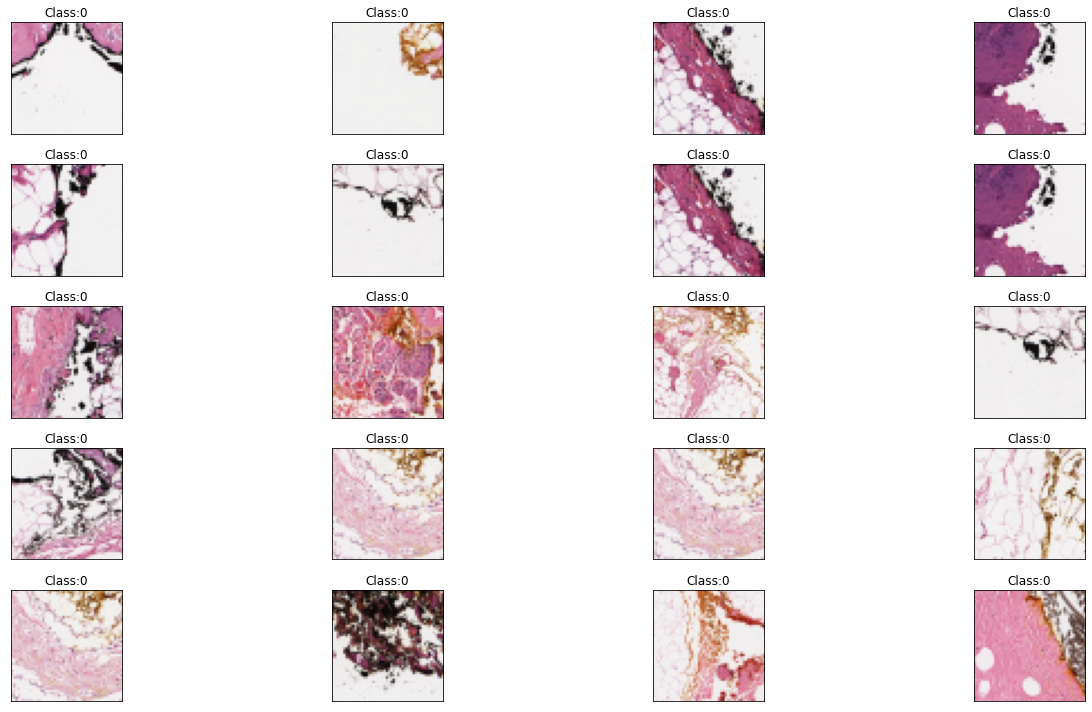

In [316]:
# Load a test image and visualize it
import cv2
import matplotlib.pyplot as plt
import math

def show_cluster(groups, cluster, N):
    N = min(N, len(groups[cluster]))
    threshold = 0.5
    samples = random.choices(groups[cluster], k=N)
    cols = math.floor(N ** 0.5)
    rows = math.ceil(N / cols) 
    
    fig, ax = plt.subplots(rows,cols,figsize=(20,10))
    counter = 0
    for sample in samples:
        col = counter % cols
        row = counter // cols

        # Predicted the class of the image
        test_img = tf.keras.utils.load_img(sample, target_size=(50, 50))
        test_array = get_array_from_img(test_img)

        ax[row,col].imshow(test_img)
        ax[row,col].set_title(f'Class:' + str(test[test['path'] == sample]['class'].iloc[0]))
        ax[row,col].get_xaxis().set_visible(False)
        ax[row,col].get_yaxis().set_visible(False)

        counter += 1
    fig.tight_layout()
    plt.show()

show_cluster(groups, 5, 20)

In [ ]:
# agregar al algoritmo de clustering 

# el promedio de color
# la prediccion obtenida
# el promedio del heatmap de grad cam
# la varianza

# sort heatmap de menor a mayor



In [208]:
original_model = tf.keras.models.load_model('classical_model.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         7385

In [209]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 0s 25ms/step
Predicted: [[0.00016943]]


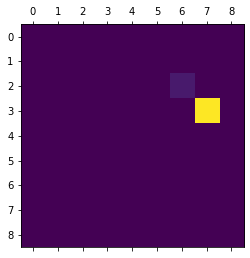

In [216]:
# Prepare image
img_path = test.sample(1)['path'].iloc[0]
img_array = keras.preprocessing.image.load_img(img_path, target_size=(50,50))
img_array = keras.preprocessing.image.img_to_array(img_array) / 255.0
img_array = np.expand_dims(img_array, axis=0)

last_conv_layer_name = "conv2d_2"

pred = original_model.predict(img_array)
print("Predicted:", pred)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, original_model, last_conv_layer_name, pred_index = 0)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [218]:
heatmap = make_gradcam_heatmap(img_array, original_model, last_conv_layer_name, pred_index = 0)
heatmap.shape

(9, 9)